In [1]:
import pandas as pd
import numpy as np
import goslate
import glob
import time
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime
from datetime import date, timedelta
from itertools import groupby
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from numpy import log
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR, VARMAX
import statsmodels.api as sm

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('./data/mdata030.txt', sep=",", header=None)

In [4]:
data.columns = ["date", "speed-min", "speed-max", "speed-average", "speed-std",
                "direction-min","direction-max","direction-average","direction-std"]

In [5]:
data.head()

date  speed-min  speed-max  speed-average  speed-std  \
0  01/01/98 00:10     999.99     999.99            1.4        0.4   
1  01/01/98 00:20     999.99     999.99            0.9        0.4   
2  01/01/98 00:30     999.99     999.99            0.1        0.3   
3  01/01/98 00:40     999.99     999.99            0.1        0.3   
4  01/01/98 00:50     999.99     999.99            0.5        0.5   

   direction-min  direction-max  direction-average  direction-std  
0         999.99         999.99               37.0         999.99  
1         999.99         999.99               37.0         999.99  
2         999.99         999.99               37.0         999.99  
3         999.99         999.99               37.0         999.99  
4         999.99         999.99               37.0         999.99

In [6]:
cities = pd.read_excel("./data/Syntetagmenes_344.xlsx")
cities.head()

Α/Α  ΚΩΔ.    ΟΝΟΜΑ       Γ.ΠΛ       Γ.ΜΚ  Γ.ΠΛ.1  Unnamed: 6  Unnamed: 7  \
0    1    13   ΑΝΔΡΟΣ  37.954167  24.748611      37          57          15   
1    2    14   ΑΝΔΡΟΣ  37.959722  24.754167      37          57          35   
2    3    30  ΛΕΥΚΑΔΑ  38.707778  20.650000      20          39           0   
3    4    33   ΣΚΥΡΟΣ  38.883333  24.577778      38          53           0   
4    5    49    ΚΡΗΤΗ  35.231944  26.219444      35          13          55   

   Μ.ΜΚ  Unnamed: 9  Unnamed: 10  
0    24          44           55  
1    24          45           15  
2    38          42           28  
3    24          34           40  
4    26          13           10

In [8]:
executor = concurrent.futures.ThreadPoolExecutor(max_workers=200)
gs = goslate.Goslate(executor=executor)
cities["city_name"] = list(gs.translate(list(cities["ΟΝΟΜΑ"].values), 'eng'))

In [9]:
missing_code = []
df = []
for file in glob.glob("./data/*.txt"):
    city_code = file.split(".txt")[0].split("mdata")[1]
    if city_code.startswith('0'):
        city_code = city_code.replace('0','',1)
    city_code = int(city_code)
    if city_code in cities["ΚΩΔ."].values:
        data = pd.read_csv(file, sep=",", header=None)
        data.columns = ["date", "speed-min", "speed-max", "speed-average", "speed-std",
                    "direction-min","direction-max","direction-average","direction-std"]
        city_name = cities[cities["ΚΩΔ."] == city_code].iloc[0]["city_name"]
        latitude = cities[cities["ΚΩΔ."] == city_code].iloc[0,3]
        longitude = cities[cities["ΚΩΔ."] == city_code].iloc[0,4]
        data["greek_city_name"] = cities[cities["ΚΩΔ."] == city_code].iloc[0]["ΟΝΟΜΑ"]
        data["city_name"] = [city_name] * len(data)
        data["latitude"] = [latitude] * len(data)
        data["longitude"] = [longitude] * len(data)
        data["city_code"] = [city_code] * len(data)
        data["cosine-speed"] = data["speed-average"] * np.cos((data["direction-average"] + 90) * math.pi / 180)
        data["sinus-speed"] = data["speed-average"] * np.sin((data["direction-average"] + 90) * math.pi / 180) 
        df.append(data)
    else:
        missing_code.append(city_code)
df = pd.concat(df, ignore_index=True)

In [10]:
df.head()

date  speed-min  speed-max  speed-average  speed-std  \
0  01/01/98 00:10     999.99     999.99         999.99     999.99   
1  01/01/98 00:20     999.99     999.99         999.99     999.99   
2  01/01/98 00:30     999.99     999.99         999.99     999.99   
3  01/01/98 00:40     999.99     999.99         999.99     999.99   
4  01/01/98 00:50     999.99     999.99         999.99     999.99   

   direction-min  direction-max  direction-average  direction-std  \
0         999.99         999.99             999.99         999.99   
1         999.99         999.99             999.99         999.99   
2         999.99         999.99             999.99         999.99   
3         999.99         999.99             999.99         999.99   
4         999.99         999.99             999.99         999.99   

  greek_city_name city_name  latitude  longitude  city_code  cosine-speed  \
0          ΙΚΑΡΙΑ    IKARIA   37.6375  26.278056        415    984.828197   
1          ΙΚΑΡΙΑ    IKARIA   37.6375  26.278056        415    984.828197   
2          ΙΚΑΡΙΑ    IKARIA   37.6375  26.278056        415    984.828197   
3          ΙΚΑΡΙΑ    IKARIA   37.6375  26.278056        415    984.828197   
4          ΙΚΑΡΙΑ    IKARIA   37.6375  26.278056        415    984.828197   

   sinus-speed  
0   173.474559  
1   173.474559  
2   173.474559  
3   173.474559  
4   173.474559

In [11]:
print(missing_code)

[52]


In [12]:
df['date'] = pd.to_datetime(df["date"], format="%d/%m/%y %H:%M")

In [13]:
df = df.sort_values(by=['date'])

In [14]:
df.to_pickle("./data/df.pkl")

# Filtering data

In [15]:
df = pd.read_pickle("./data/df.pkl")

In [16]:
df[(df['speed-min']!=999.99) & (df['speed-max']!=999.99) & (df['speed-average']!=999.99) & (df['speed-std']!=999.99) 
    & (df['direction-min']!=999.99) & (df['direction-max']!=999.99) & (df['direction-average']!=999.99) & 
   (df['direction-std']!=999.99)]

date  speed-min  speed-max  speed-average  speed-std  \
7306942 1998-07-02 15:50:00        0.2        0.2            0.2        0.0   
7306943 1998-07-02 16:00:00        0.2        0.2            0.2        0.0   
7306944 1998-07-02 16:10:00        0.2        0.2            0.2        0.0   
7306945 1998-07-02 16:20:00        0.2        0.2            0.2        0.0   
7306946 1998-07-02 16:30:00        0.2        0.2            0.2        0.0   
...                     ...        ...        ...            ...        ...   
7049486 2000-02-04 18:30:00        2.5        7.2            4.7        1.0   
7049487 2000-02-04 18:40:00        1.0        7.2            4.3        1.1   
7049488 2000-02-04 18:50:00        1.7        6.4            3.8        0.9   
7049489 2000-02-04 19:00:00        1.7        6.4            3.4        0.9   
7049490 2000-02-04 19:10:00        0.2        4.8            1.3        1.3   

         direction-min  direction-max  direction-average  direction-std  \
7306942          0.791          1.143              0.879          0.216   
7306943          0.879          0.967              0.879          0.044   
7306944          0.791          1.319              0.879          0.216   
7306945          0.879          0.967              0.879          0.044   
7306946          0.879          0.967              0.879          0.044   
...                ...            ...                ...            ...   
7049486         55.600         55.600             55.600          0.000   
7049487         55.600         55.600             55.600          0.000   
7049488         55.600         55.600             55.600          0.000   
7049489         55.600         55.600             55.600          0.000   
7049490         55.600         55.600             55.600          0.000   

        greek_city_name city_name   latitude  longitude  city_code  \
7306942         ΖΑΡΑΚΕΣ   ZARAKES  38.320833  24.220833         63   
7306943         ΖΑΡΑΚΕΣ   ZARAKES  38.320833  24.220833         63   
7306944         ΖΑΡΑΚΕΣ   ZARAKES  38.320833  24.220833         63   
7306945         ΖΑΡΑΚΕΣ   ZARAKES  38.320833  24.220833         63   
7306946         ΖΑΡΑΚΕΣ   ZARAKES  38.320833  24.220833         63   
...                 ...       ...        ...        ...        ...   
7049486          ΡΟΓΓΟΙ   ROUNGIA  38.091944  22.120000        315   
7049487          ΡΟΓΓΟΙ   ROUNGIA  38.091944  22.120000        315   
7049488          ΡΟΓΓΟΙ   ROUNGIA  38.091944  22.120000        315   
7049489          ΡΟΓΓΟΙ   ROUNGIA  38.091944  22.120000        315   
7049490          ΡΟΓΓΟΙ   ROUNGIA  38.091944  22.120000        315   

         cosine-speed  sinus-speed  
7306942     -0.003068     0.199976  
7306943     -0.003068     0.199976  
7306944     -0.003068     0.199976  
7306945     -0.003068     0.199976  
7306946     -0.003068     0.199976  
...               ...          ...  
7049486     -3.878033     2.655345  
7049487     -3.547988     2.429358  
7049488     -3.135431     2.146875  
7049489     -2.805386     1.920888  
7049490     -1.072648     0.734457  

[2440061 rows x 16 columns]

In [17]:
# calculate intersection of all different day with data
lst = {}
for file in glob.glob("./data/*.txt"):
    city_code = file.split(".txt")[0].split("mdata")[1]
    if city_code.startswith('0'):
        city_code = city_code.replace('0','',1)
    city_code = int(city_code)
    if city_code in cities["ΚΩΔ."].values:
        data = pd.read_csv(file, sep=",", header=None)
        data.columns = ["date", "speed-min", "speed-max", "speed-average", "speed-std",
                    "direction-min","direction-max","direction-average","direction-std"]
        data['date'] = pd.to_datetime(data["date"], format="%d/%m/%y %H:%M")
        data_no_na = data[(data['speed-min']!=999.99) & (data['speed-max']!=999.99) & (data['speed-average']!=999.99) & (data['speed-std']!=999.99) 
                        & (data['direction-min']!=999.99) & (data['direction-max']!=999.99) & (data['direction-average']!=999.99) & 
                           (data['direction-std']!=999.99) & (data['direction-max']<=360)]
        data_no_na = data_no_na.sort_values(by=['date'])
        data_no_na.index = data_no_na['date']
        lst.update({file:set([(date.year,date.month,date.day) for date in data_no_na['date']])})

In [18]:
lst

{'./data/mdata415.txt': {(1999, 8, 10),
  (1999, 8, 11),
  (1999, 8, 12),
  (1999, 8, 13),
  (1999, 8, 14),
  (1999, 8, 15),
  (1999, 8, 16),
  (1999, 8, 17),
  (1999, 8, 18),
  (1999, 8, 19),
  (1999, 8, 20),
  (1999, 8, 21),
  (1999, 8, 22),
  (1999, 8, 23),
  (1999, 8, 24),
  (1999, 8, 25),
  (1999, 8, 26),
  (1999, 8, 27),
  (1999, 8, 28),
  (1999, 8, 29),
  (1999, 8, 30),
  (1999, 8, 31),
  (1999, 9, 1),
  (1999, 9, 2),
  (1999, 9, 3),
  (1999, 9, 4),
  (1999, 9, 5),
  (1999, 9, 6),
  (1999, 9, 7),
  (1999, 9, 8),
  (1999, 9, 9),
  (1999, 9, 10),
  (1999, 9, 11),
  (1999, 9, 12),
  (1999, 9, 13),
  (1999, 9, 14),
  (1999, 9, 15),
  (1999, 9, 16),
  (1999, 9, 17),
  (1999, 9, 18),
  (1999, 9, 19),
  (1999, 9, 20),
  (1999, 9, 21),
  (1999, 9, 22),
  (1999, 9, 23),
  (1999, 9, 24),
  (1999, 9, 25),
  (1999, 9, 26),
  (1999, 9, 27),
  (1999, 9, 28),
  (1999, 9, 29),
  (1999, 9, 30),
  (1999, 10, 1),
  (1999, 10, 2),
  (1999, 10, 3),
  (1999, 10, 4),
  (1999, 10, 5),
  (1999, 10, 6),


In [19]:
# 7 files have no row without 999.99

In [20]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def intersection(start_date,end_date,lst):
    file_to_del = []
    for file, date in lst.items():
        if date == set():
            file_to_del.append(file)
    for file in file_to_del:
        del lst[file]        
    for date in daterange(start_date, end_date):
        lst_to_del = [key for key, date_lst in lst.items() if (date.year,date.month,date.day) not in date_lst]
        for to_del in lst_to_del:
            del lst[to_del]
    return lst

In [21]:
lst_ = lst.copy()
start_date = datetime.date(1999, 9, 1)
end_date = datetime.date(1999, 12, 16)
len(intersection(start_date,end_date,lst_))

60

In [22]:
# function that returns the longest period with at least 50 cities
def longest_common_period(start_date,end_date,lst,min_amount_location=50):
    i = 0
    while len(lst) >= min_amount_location:
        day_before = start_date - timedelta(days = 1)
        day_after = end_date + timedelta(days = 1)
        lst_before = intersection(day_before,end_date,lst)
        lst_after = intersection(start_date,day_after,lst)
        
        if len(lst_before) > len(lst_after):
            start_date = day_before
            lst = lst_before
            
        elif len(lst_before) < len(lst_after):
            end_date = day_after
            lst = lst_afer
            
        elif len(lst) > len(lst_before):
            if i % 2 == 0:
                start_date = day_before
                lst = lst_before
            else:
                end_date = day_after
                lst = lst_afer
            i = i + 1
        else:
            start_date = day_before 
            end_date = day_after
            
    return lst,start_date,end_date

In [23]:
lst_ = lst.copy()
start_date = datetime.date(1999, 10, 15)
end_date = datetime.date(1999, 10, 20)
lst_final, start_date_final, end_date_final = longest_common_period(start_date,end_date,lst_,70)

In [24]:
print(start_date_final)
print(end_date_final)
print((end_date_final - start_date_final).days)

1999-09-22
1999-11-12
51


In [25]:
lst_final

{'./data/mdata415.txt': {(1999, 8, 10),
  (1999, 8, 11),
  (1999, 8, 12),
  (1999, 8, 13),
  (1999, 8, 14),
  (1999, 8, 15),
  (1999, 8, 16),
  (1999, 8, 17),
  (1999, 8, 18),
  (1999, 8, 19),
  (1999, 8, 20),
  (1999, 8, 21),
  (1999, 8, 22),
  (1999, 8, 23),
  (1999, 8, 24),
  (1999, 8, 25),
  (1999, 8, 26),
  (1999, 8, 27),
  (1999, 8, 28),
  (1999, 8, 29),
  (1999, 8, 30),
  (1999, 8, 31),
  (1999, 9, 1),
  (1999, 9, 2),
  (1999, 9, 3),
  (1999, 9, 4),
  (1999, 9, 5),
  (1999, 9, 6),
  (1999, 9, 7),
  (1999, 9, 8),
  (1999, 9, 9),
  (1999, 9, 10),
  (1999, 9, 11),
  (1999, 9, 12),
  (1999, 9, 13),
  (1999, 9, 14),
  (1999, 9, 15),
  (1999, 9, 16),
  (1999, 9, 17),
  (1999, 9, 18),
  (1999, 9, 19),
  (1999, 9, 20),
  (1999, 9, 21),
  (1999, 9, 22),
  (1999, 9, 23),
  (1999, 9, 24),
  (1999, 9, 25),
  (1999, 9, 26),
  (1999, 9, 27),
  (1999, 9, 28),
  (1999, 9, 29),
  (1999, 9, 30),
  (1999, 10, 1),
  (1999, 10, 2),
  (1999, 10, 3),
  (1999, 10, 4),
  (1999, 10, 5),
  (1999, 10, 6),


In [26]:
def build_df_period(start_date,end_date):
    df = pd.read_pickle("./data/df.pkl")
    dict_dates = {}
    for city_code in df["city_code"].unique():
        data = df[df["city_code"] == city_code]
        data_no_na = data[(data['speed-min']!=999.99) & (data['speed-max']!=999.99) & (data['speed-average']!=999.99) & (data['speed-std']!=999.99) 
                        & (data['direction-min']!=999.99) & (data['direction-max']!=999.99) & (data['direction-average']!=999.99) & 
                           (data['direction-std']!=999.99) & (data['direction-max']<=360)]
        data_no_na = data_no_na[~((data_no_na["speed-max"] > 50) & (data_no_na["speed-average"] > 50))]
        dict_dates.update({city_code:set([(date.year,date.month,date.day) for date in data_no_na['date']])})
    dict_dates = intersection(start_date,end_date,dict_dates)
    df = df[df["city_code"].isin(dict_dates.keys())]
    df = df[(df['date'] < str(end_date + timedelta(days = 1))) & (df['date'] >= str(start_date))]
    longest_missing_sequence = 0
    for city_code in df["city_code"].unique():
        s = df[df["city_code"] == city_code]["speed-average"].values
        len_longest_sequence = len(max([list(group) for _, group in groupby(s) if 999.99 in group] or [[0]], key=len))
        if len_longest_sequence >= 6:
            del dict_dates[city_code]
        else:
            if len_longest_sequence > longest_missing_sequence:
                longest_missing_sequence = len_longest_sequence
    df = df[df["city_code"].isin(dict_dates.keys())]
    return df, longest_missing_sequence

In [27]:
start_date = datetime.date(1999, 9, 2)
end_date = datetime.date(1999, 12, 16)
test_df, longest_missing_sequence = build_df_period(start_date,end_date)

In [28]:
print("Number of cities : " + str(len(test_df["city_code"].unique())))
print("Number of days : " + str((end_date - start_date).days))
print("Number of missing values : " + str(len(test_df[test_df["direction-average"] == 999.99])))
print("Number of values : " + str(len(test_df)))
print("Ratio of missing values : " + str(65 / len(test_df)))
print("Length longest sequence of missing values for one location : " + str(longest_missing_sequence*10) +"min")

Number of cities : 48
Number of days : 105
Number of missing values : 65
Number of values : 732672
Ratio of missing values : 8.871636967155835e-05
Length longest sequence of missing values for one location : 40min


In [29]:
for city_code in test_df["city_code"].unique():
    s = test_df[test_df["city_code"] == city_code]["direction-average"].values
    if len(max([list(group) for _, group in groupby(s) if 999.99 in group] or [[0]], key=len)) >= 6:
        print(city_code)

In [30]:
test_df[(test_df["speed-max"] > 50) & (test_df["speed-max"] != 999.99) & (test_df["speed-average"] > 50)]

date  speed-min  speed-max  speed-average  speed-std  \
1795197 1999-09-09 15:40:00        8.6      178.1           56.0       18.8   

         direction-min  direction-max  direction-average  direction-std  \
1795197          359.1          165.0               31.8           12.5   

        greek_city_name city_name   latitude  longitude  city_code  \
1795197         Γλαφυρά    Glamor  39.433611  22.856944        211   

         cosine-speed  sinus-speed  
1795197    -29.509525    47.593991

In [31]:
def interpolate_df(df_1):
    df = df_1.copy()
    df.loc[((df["speed-max"] > 50) & (df["speed-average"] > 50)), 'speed-max'] = 999.99
    df.loc[((df["speed-max"] > 50) & (df["speed-average"] > 50)), 'speed-average'] = 999.99
    df.loc[(df["speed-max"] > 100), 'speed-max'] = 999.99
    df = df.replace(999.99,np.nan)
    for city_code in df['city_code'].unique():
        for column in df.columns[1:9]:
            df.loc[df['city_code'] == city_code,column] = df[df['city_code'] == city_code][column].interpolate()
    df["cosine-speed"] = df["speed-average"] * np.cos((df["direction-average"] + 90) * math.pi / 180)
    df["sinus-speed"] = df["speed-average"] * np.sin((df["direction-average"] + 90) * math.pi / 180) 
    return df

In [32]:
final_df = interpolate_df(test_df)

In [33]:
final_df[test_df['speed-average'] == 999.99]

date  speed-min  speed-max  speed-average  speed-std  \
3728093 1999-09-02 13:00:00       1.75     17.000       5.350000   1.800000   
6799766 1999-09-03 14:30:00       3.40      7.375       5.400000   0.600000   
6799767 1999-09-03 14:40:00       3.40      7.550       5.500000   0.600000   
6799768 1999-09-03 14:50:00       3.40      7.725       5.600000   0.600000   
3956624 1999-09-09 13:30:00       2.35     16.950       5.066667   1.316667   
...                     ...        ...        ...            ...        ...   
3853705 1999-11-23 20:20:00       3.30     23.500       7.700000   3.700000   
2375307 1999-11-27 04:40:00       0.30      0.800       0.366667   0.100000   
2375308 1999-11-27 04:50:00       0.30      1.300       0.433333   0.200000   
2375314 1999-11-27 05:50:00       0.30      1.850       0.750000   0.300000   
6814085 1999-12-12 01:00:00       0.30     28.800       7.300000   5.400000   

         direction-min  direction-max  direction-average  direction-std  \
3728093     136.150000     266.950000         211.300000      22.300000   
6799766      57.200000     108.150000          93.500000       7.350000   
6799767      58.600000     108.500000          93.200000       8.100000   
6799768      60.000000     108.850000          92.900000       8.850000   
3956624     300.966667      58.433333         332.016667      10.483333   
...                ...            ...                ...            ...   
3853705     234.600000     332.300000         283.550000      25.800000   
2375307     277.100000     319.266667         290.666667      15.433333   
2375308     253.200000     291.133333         261.533333      11.766667   
2375314     247.600000     155.450000         139.600000      21.050000   
6814085     150.000000     272.350000         222.200000      11.250000   

        greek_city_name  city_name   latitude  longitude  city_code  \
3728093         Μαλούνι       Male  39.626389  20.501389        217   
6799766         ΠΡΑΣΙΝΟ      Green  38.341667  24.088889        101   
6799767         ΠΡΑΣΙΝΟ      Green  38.341667  24.088889        101   
6799768         ΠΡΑΣΙΝΟ      Green  38.341667  24.088889        101   
3956624      Πτολεμαίδα  Ptolemaid  40.535556  21.627500        161   
...                 ...        ...        ...        ...        ...   
3853705         Ερατηνή     Senate  38.394444  22.234722        203   
2375307        Καστοριά   Kastoria  40.493889  21.251667        163   
2375308        Καστοριά   Kastoria  40.493889  21.251667        163   
2375314        Καστοριά   Kastoria  40.493889  21.251667        163   
6814085         ΠΡΑΣΙΝΟ      Green  38.341667  24.088889        101   

         cosine-speed  sinus-speed  
3728093      2.779427    -4.571355  
6799766     -5.389928    -0.329662  
6799767     -5.491424    -0.307018  
6799768     -5.592828    -0.283320  
3956624      2.377354     4.474293  
...               ...          ...  
3853705      7.485677     1.804062  
2375307      0.343071     0.129408  
2375308      0.428611    -0.063801  
2375314     -0.486090    -0.571154  
6814085      4.903560    -5.407874  

[65 rows x 16 columns]

In [34]:
final_df[(test_df["speed-max"] > 50) & (test_df["speed-max"] != 999.99) & (test_df["speed-average"] > 50)]

date  speed-min  speed-max  speed-average  speed-std  \
1795197 1999-09-09 15:40:00        8.6       47.9          18.45       18.8   

         direction-min  direction-max  direction-average  direction-std  \
1795197          359.1          165.0               31.8           12.5   

        greek_city_name city_name   latitude  longitude  city_code  \
1795197         Γλαφυρά    Glamor  39.433611  22.856944        211   

         cosine-speed  sinus-speed  
1795197     -9.722334     15.68052

In [35]:
final_df.to_pickle("./data/final_df.pkl")

# Prevailing direction

In [11]:
final_df = pd.read_pickle("./data/final_df.pkl")

In [12]:
C = np.cos((final_df['direction-average'].values + 90) * math.pi / 180).sum()
S = np.sin((final_df['direction-average'].values + 90) * math.pi / 180).sum()
assert(C > 0)
assert(S > 0)
theta_bar = np.arctan(S/C)
theta_bar

1.4761378219934103

In [9]:
final_df["cosine-speed"] = final_df["speed-average"] * np.cos((final_df["direction-average"] + 90) * math.pi / 180 - theta_bar)
final_df["sinus-speed"] = final_df["speed-average"] * np.sin((final_df["direction-average"] + 90) * math.pi / 180 - theta_bar) 

In [10]:
final_df["cosine-speed_heatmap"] = final_df["speed-average"] * np.cos((final_df["direction-average"] + 90) * math.pi / 180)
final_df["sinus-speed_heatmap"] = final_df["speed-average"] * np.sin((final_df["direction-average"] + 90) * math.pi / 180) 

In [10]:
final_df.to_pickle("./data/final_df.pkl")

In [11]:
final_df.head()

date  speed-min  speed-max  speed-average  speed-std  \
5434415 1999-09-02        1.7        4.0            3.1        0.4   
7709615 1999-09-02        0.2        0.2            0.2        0.0   
8847215 1999-09-02        4.1        9.5            6.9        0.9   
3728015 1999-09-02        7.9       11.7           10.5        0.5   
1794095 1999-09-02        4.8        8.6            7.1        0.7   

         direction-min  direction-max  direction-average  direction-std  \
5434415          319.1            9.7              349.7            8.2   
7709615          157.5          167.3              160.2            4.5   
8847215          356.8           48.8               18.7            8.4   
3728015           24.4           44.1               35.6            6.7   
1794095          287.3          339.4              306.6            9.3   

        greek_city_name city_name   latitude  longitude  city_code  \
5434415         Σιθωνία  Sithonia  40.011389  23.944167        105   
7709615         ΒΛΟΓΓΟΣ   Balogen  37.582778  22.005833        314   
8847215           Πλάκα     Plate  40.900000  25.745000        123   
3728015         Μαλούνι      Male  39.626389  20.501389        217   
1794095         Γλαφυρά    Glamor  39.433611  22.856944        211   

         cosine-speed  sinus-speed  cosine-speed_heatmap  sinus-speed_heatmap  
5434415      3.088779    -0.263524              0.554287             3.050044  
7709615     -0.193737     0.049658             -0.067748            -0.188176  
8847215      6.297398     2.820067             -2.212230             6.535751  
3728015      7.921621     6.891874             -6.112291             8.537558  
1794095      4.752994    -5.274377              5.700004             4.233197

# Statistical analysis and distribution plots

In [12]:
final_df = pd.read_pickle("./data/final_df.pkl")

In [13]:
final_df.describe()

speed-min      speed-max  speed-average      speed-std  \
count  732672.000000  732672.000000  732672.000000  732672.000000   
mean        3.250347       7.850591       5.456251       0.823952   
std         3.220332       5.514638       4.281540       0.562151   
min         0.100000       0.100000       0.100000       0.000000   
25%         0.900000       4.000000       2.300000       0.400000   
50%         2.500000       6.400000       4.400000       0.700000   
75%         4.800000      10.900000       7.600000       1.100000   
max        31.700000      98.400000      37.700000      26.600000   

       direction-min  direction-max  direction-average  direction-std  \
count  732672.000000  732672.000000      732672.000000  732672.000000   
mean      202.595050     172.336920         180.506712      12.532619   
std       110.385398     111.395803         115.480555      11.188520   
min         0.000000       0.000000           0.000000       0.000000   
25%       110.200000      66.600000          71.200000       6.700000   
50%       211.700000     172.600000         180.900000       9.500000   
75%       306.600000     271.000000         293.400000      14.400000   
max       359.900000     359.900000         359.900000     131.600000   

            latitude      longitude      city_code   cosine-speed  \
count  732672.000000  732672.000000  732672.000000  732672.000000   
mean       38.516291      23.860914     259.812500       1.459110   
std         1.542818       1.732026     122.506317       5.293558   
min        35.446111      20.501389      64.000000     -29.474572   
25%        37.379931      22.569931     151.750000      -1.529941   
50%        38.367361      23.499583     259.500000       0.726270   
75%        39.960347      25.163403     405.250000       4.433205   
max        41.512778      27.751389     418.000000      29.146688   

         sinus-speed  cosine-speed_heatmap  sinus-speed_heatmap  
count  732672.000000         732672.000000        732672.000000  
mean       -0.060313              0.197954             1.446878  
std         4.236496              4.224203             5.303373  
min       -36.946245            -30.642440           -30.170441  
25%        -2.121250             -1.812133            -1.557749  
50%         0.030333              0.012906             0.741609  
75%         1.965254              2.198070             4.454667  
max        31.195242             36.071872            29.105822

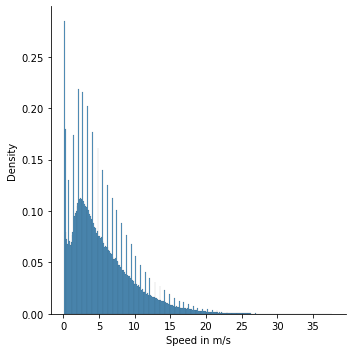

In [146]:
ax = sns.displot(final_df['speed-average'], stat="density") 
ax.set(xlabel="Speed in m/s")
plt.savefig('density-speed-average.pdf') 
plt.show()

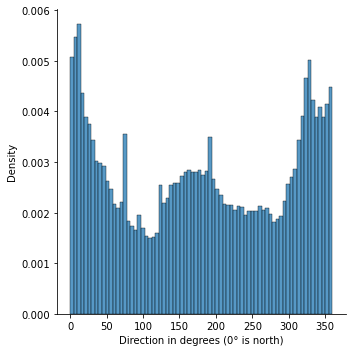

In [149]:
ax = sns.displot(final_df['direction-average'], stat="density")
ax.set(xlabel="Direction in degrees (0° is north)")
plt.savefig('density-direction-average.pdf') 
plt.show()

105


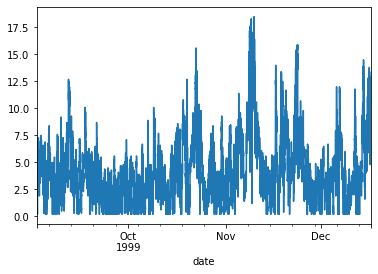

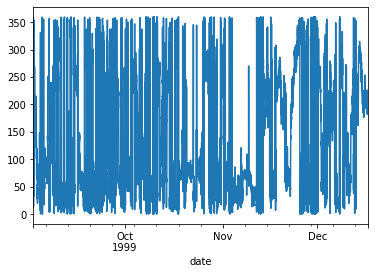

314


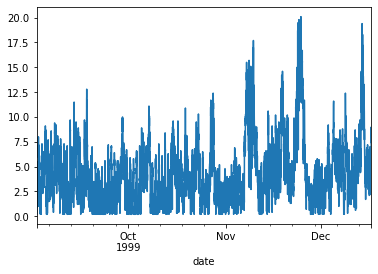

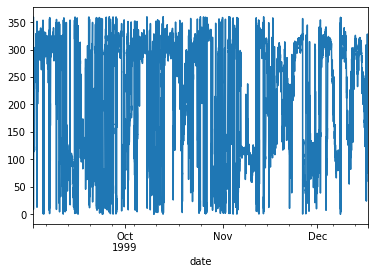

123


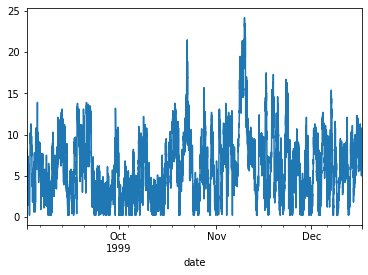

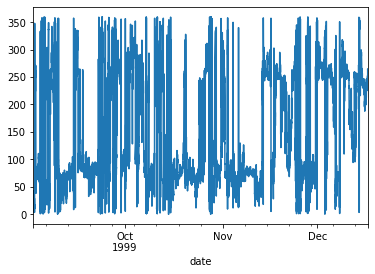

217


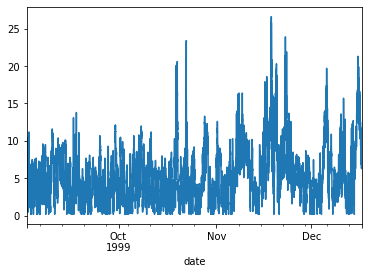

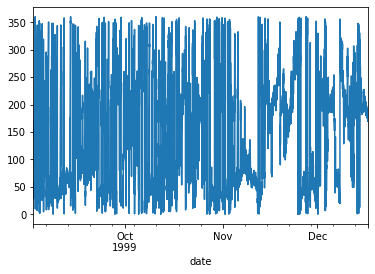

211


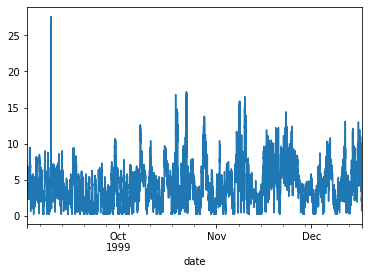

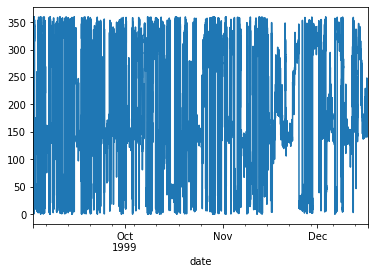

201


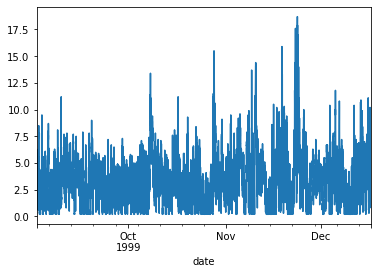

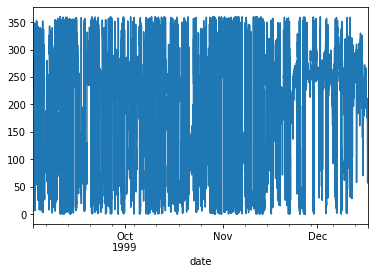

203


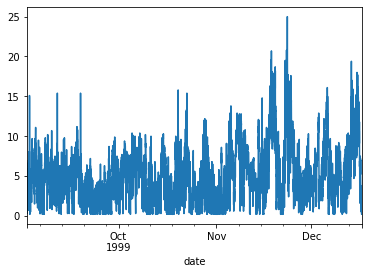

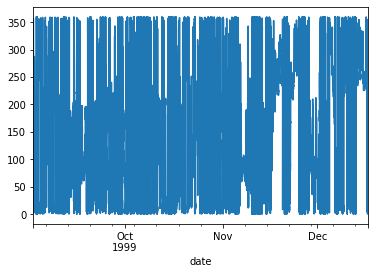

407


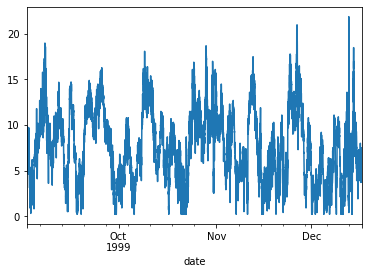

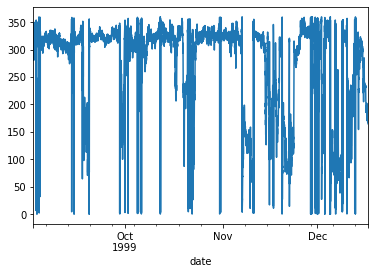

416


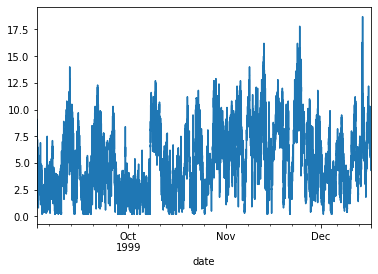

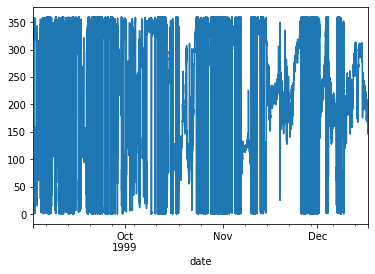

404


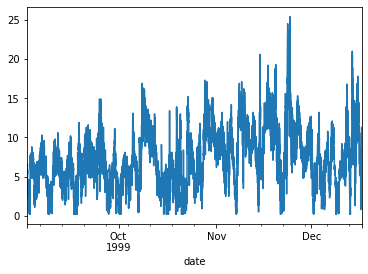

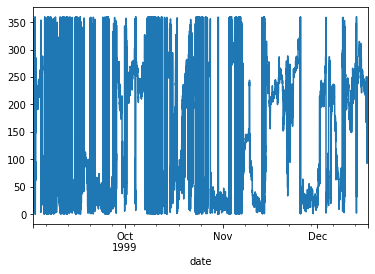

301


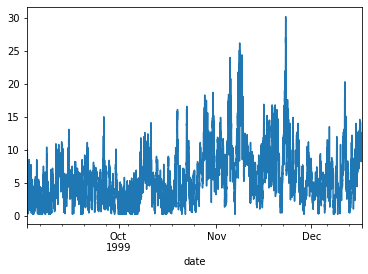

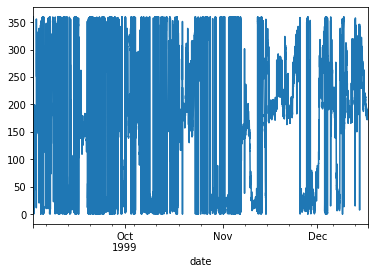

405


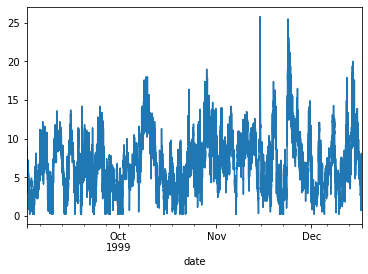

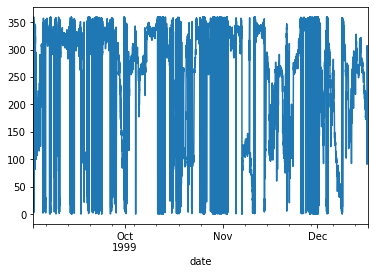

406


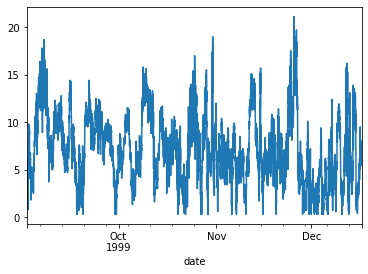

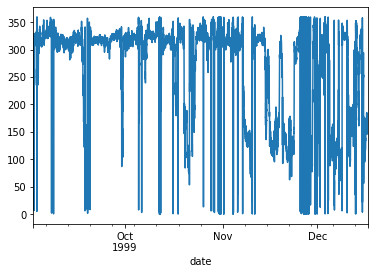

308


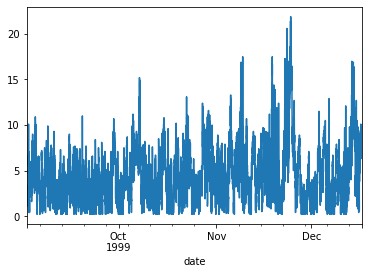

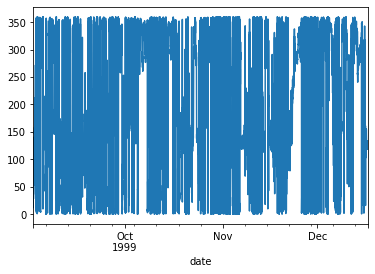

218


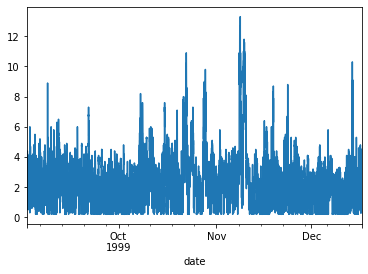

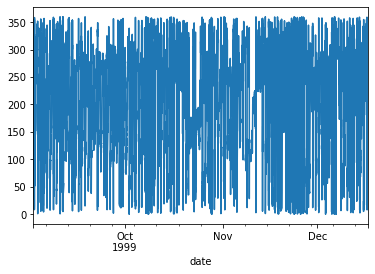

412


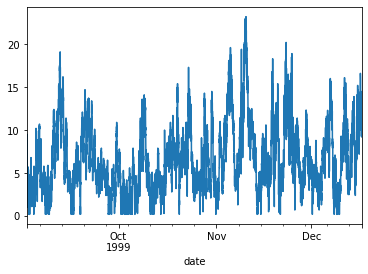

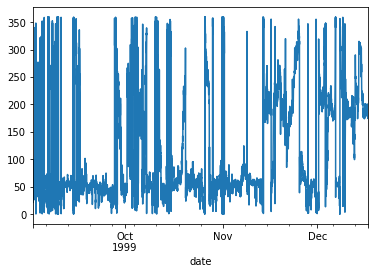

163


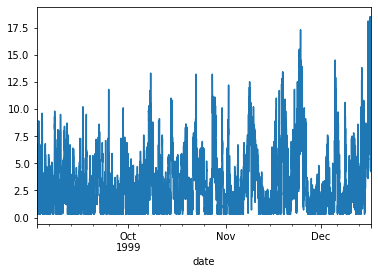

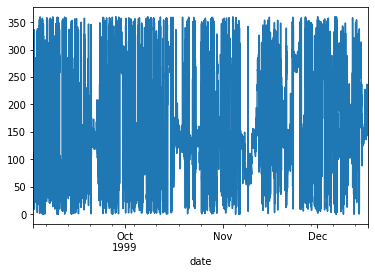

101


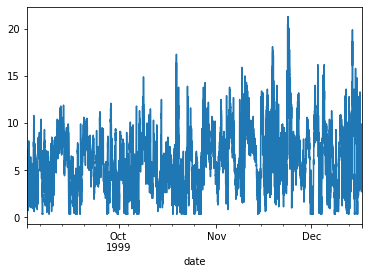

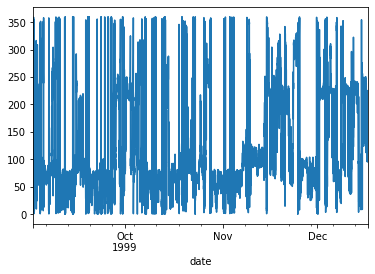

102


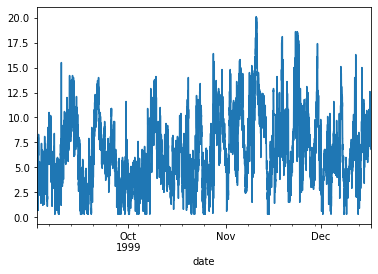

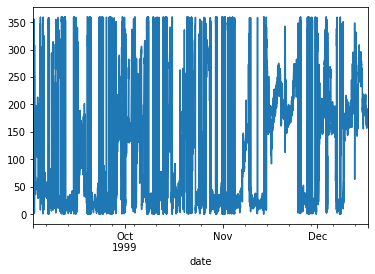

160


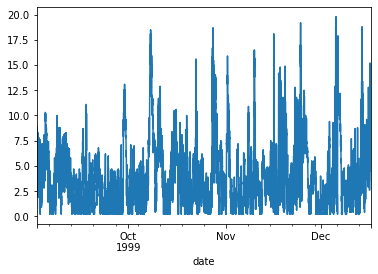

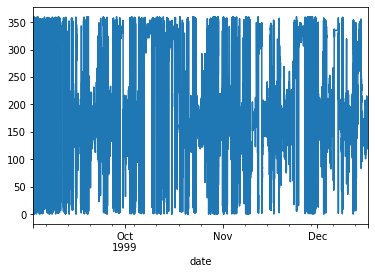

312


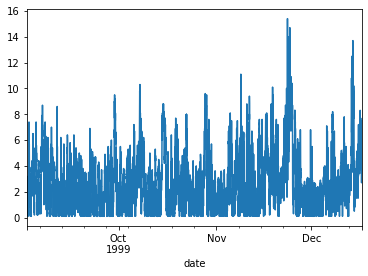

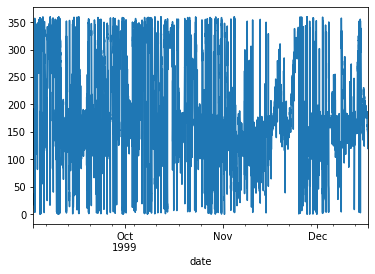

152


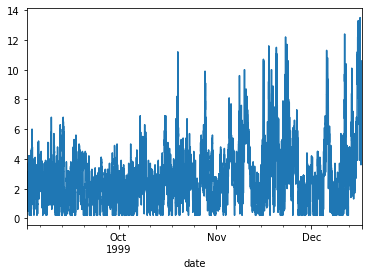

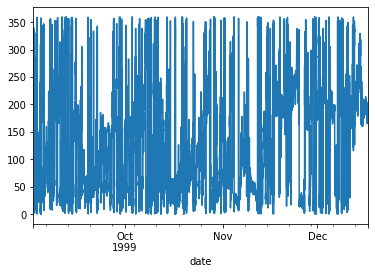

150


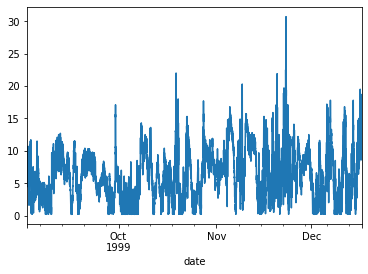

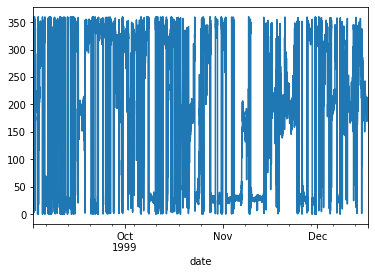

125


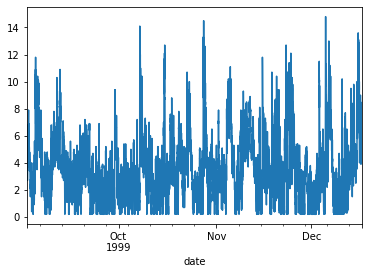

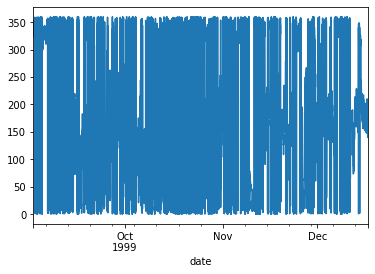

164


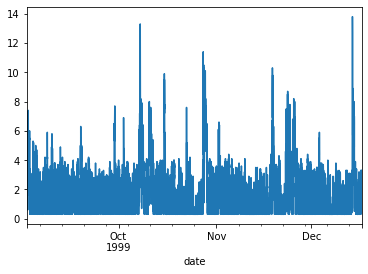

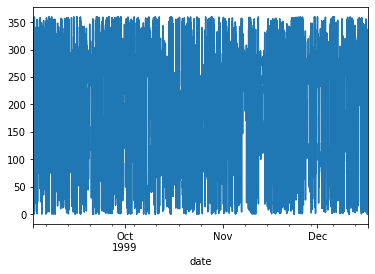

311


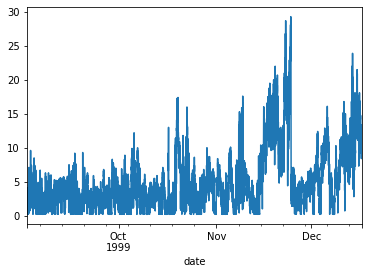

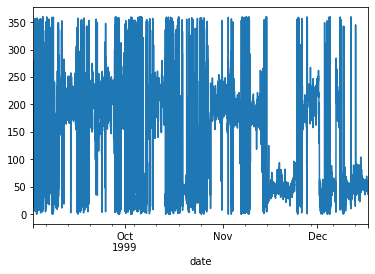

205


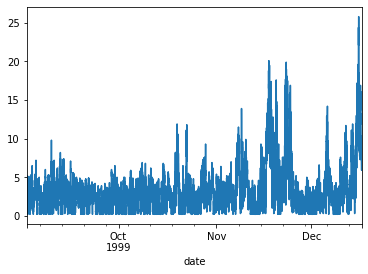

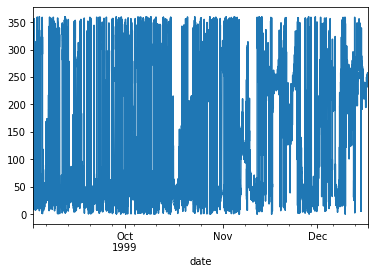

417


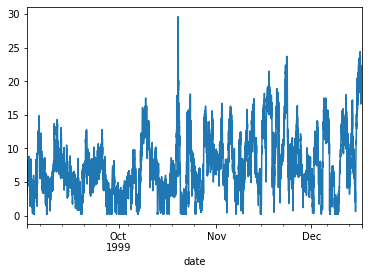

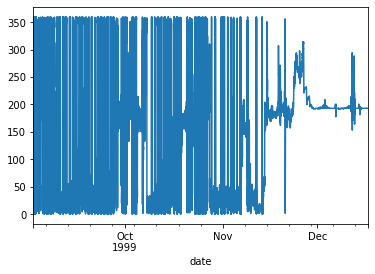

64


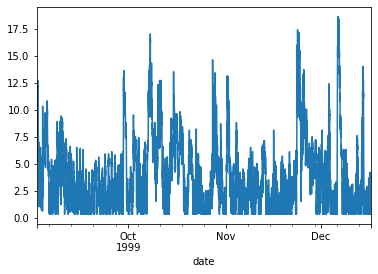

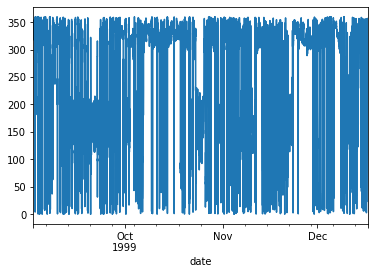

65


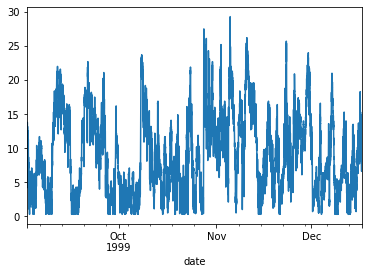

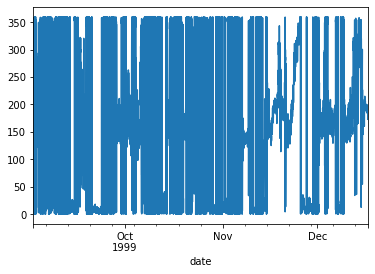

310


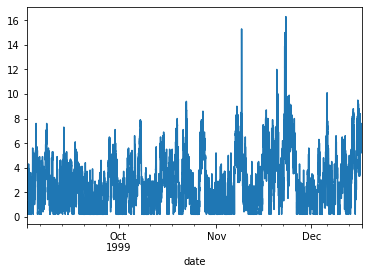

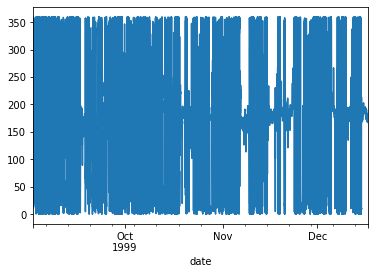

402


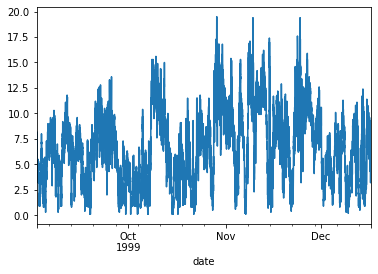

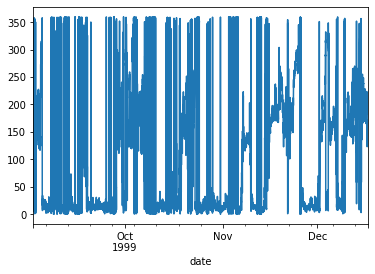

415


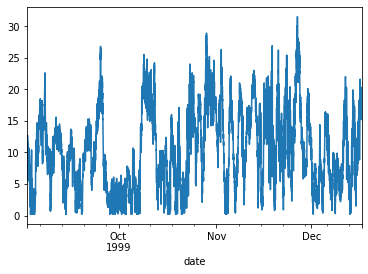

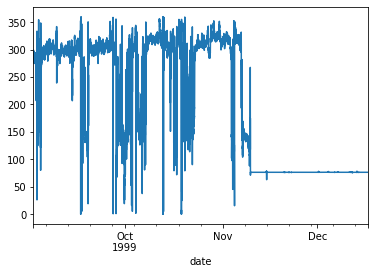

151


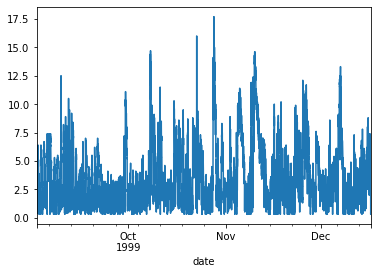

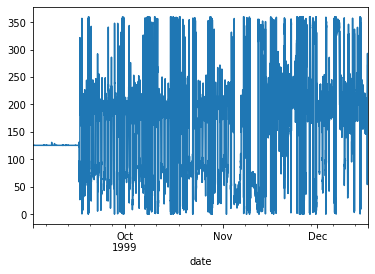

418


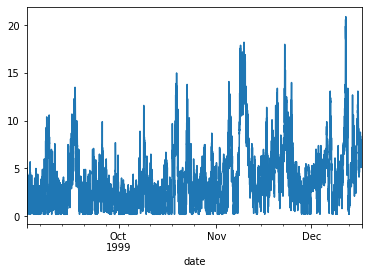

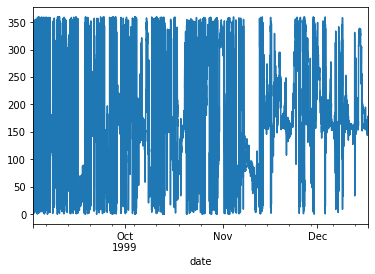

202


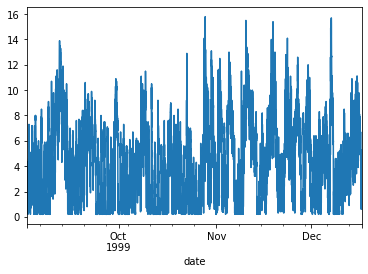

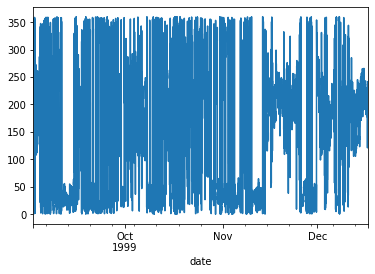

304


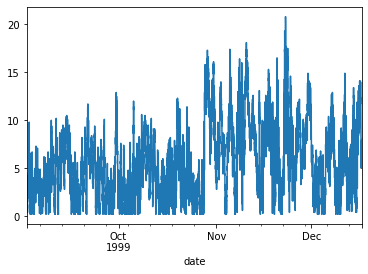

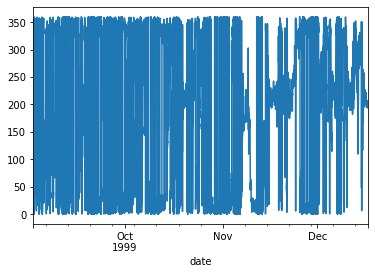

161


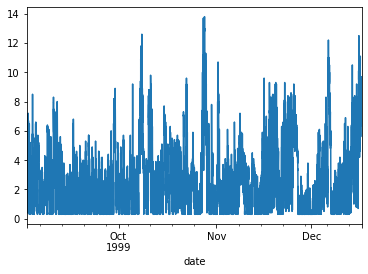

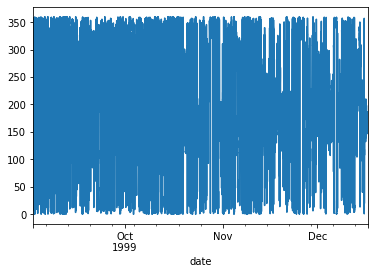

413


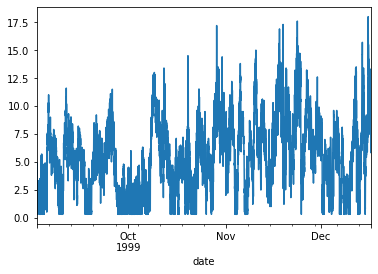

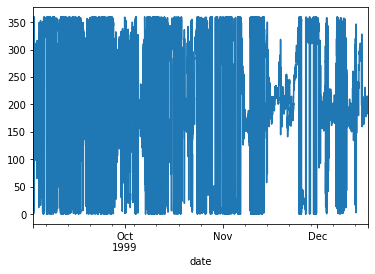

108


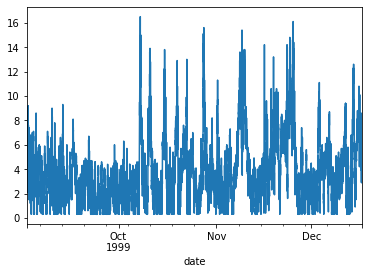

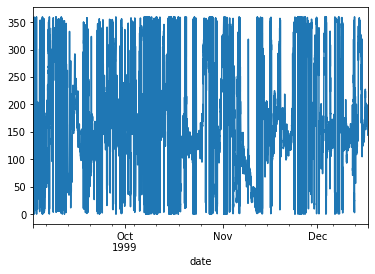

414


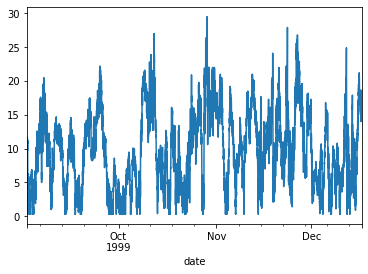

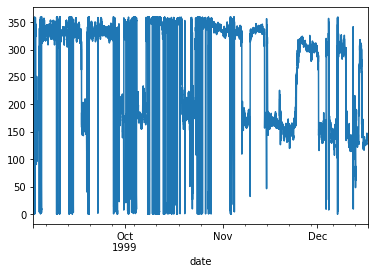

305


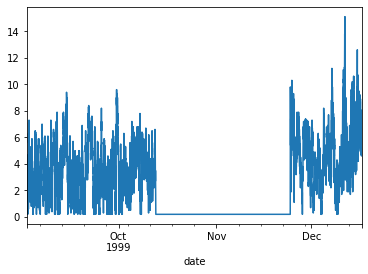

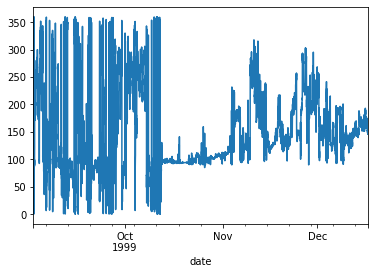

408


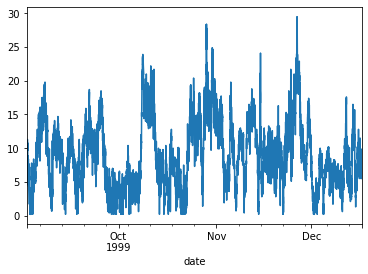

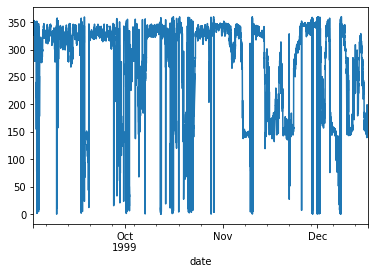

306


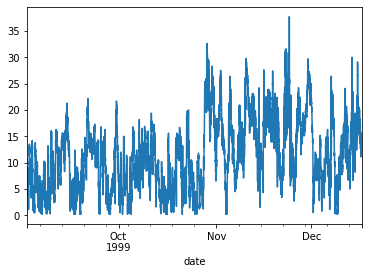

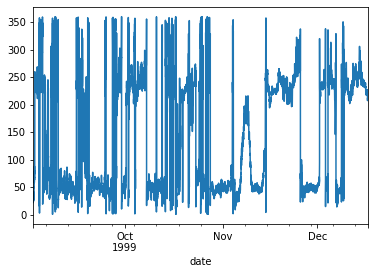

71


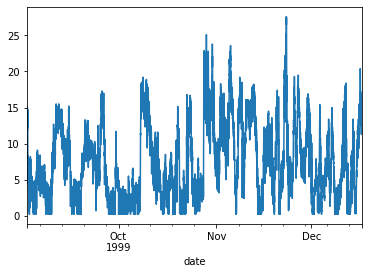

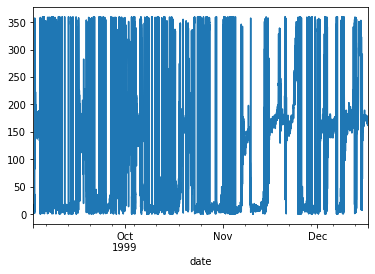

410


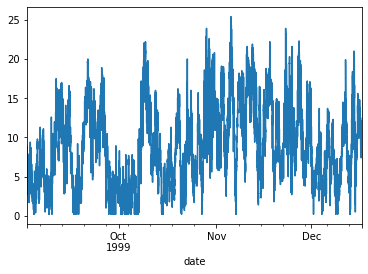

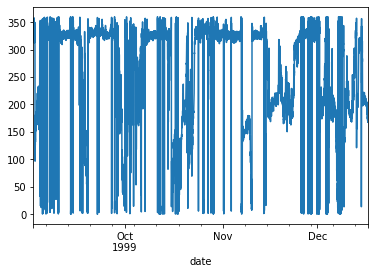

411


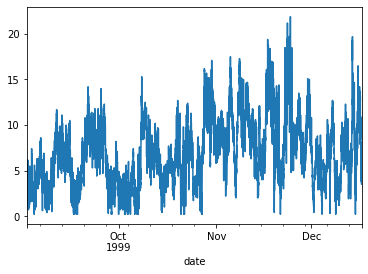

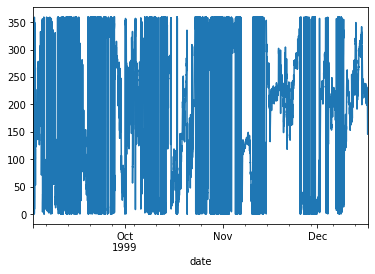

120


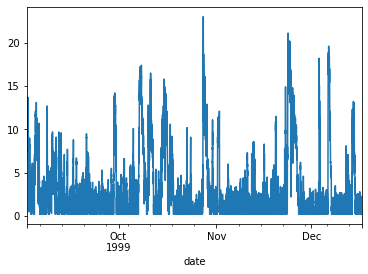

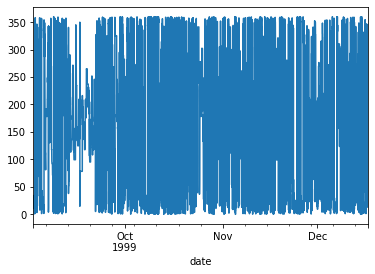

In [984]:
for city_code in final_df['city_code'].unique():
    print(city_code)
    data = final_df[final_df['city_code'] == city_code]
    data.index = data['date']
    data['speed-average'].plot()
    plt.show()
    data['direction-average'].plot()
    plt.show()

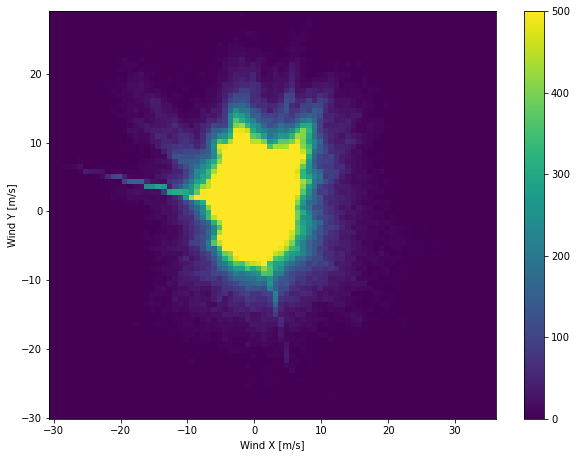

In [152]:
plt.rcParams["figure.figsize"] = (10,7.5)
plt.hist2d(final_df['cosine-speed_heatmap'], final_df['sinus-speed_heatmap'], bins=(80, 80), vmax=500)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
plt.savefig('heatmap.pdf') 

# Build dataset for the single entity approach

In [17]:
def create_final_df_grouped(final_df):
    df_grouped = pd.DataFrame(index=final_df['date'].unique())
    for city_code in final_df['city_code'].unique():
        df = final_df[final_df['city_code'] == city_code]
        df.index = df['date']
        df = df[['cosine-speed','sinus-speed']]
        df.columns = [column_name+"_"+str(city_code) for column_name in df.columns]
        df_grouped = df_grouped.join(df)
    return df_grouped

In [15]:
final_df_grouped = create_final_df_grouped(final_df)
final_df_grouped.head()

cosine-speed_105  sinus-speed_105  cosine-speed_314  \
1999-09-02 00:00:00          3.088779        -0.263524         -0.193737   
1999-09-02 00:10:00          3.198379         0.101828         -0.199519   
1999-09-02 00:20:00          2.691590         0.212945          0.199954   
1999-09-02 00:30:00          2.211162        -0.633058          0.199954   
1999-09-02 00:40:00          2.299187         0.061151          0.199954   

                     sinus-speed_314  cosine-speed_123  sinus-speed_123  \
1999-09-02 00:00:00         0.049658          6.297398         2.820067   
1999-09-02 00:10:00         0.013869          5.590197         4.694646   
1999-09-02 00:20:00         0.004271          6.072335         5.510603   
1999-09-02 00:30:00         0.004271          5.793546         4.762859   
1999-09-02 00:40:00         0.004271          5.931533         3.525183   

                     cosine-speed_217  sinus-speed_217  cosine-speed_211  \
1999-09-02 00:00:00          7.921621         6.891874          4.752994   
1999-09-02 00:10:00          7.131551         6.426583          4.706786   
1999-09-02 00:20:00          6.896585         5.936929          3.588640   
1999-09-02 00:30:00          7.079665         5.717372          3.400361   
1999-09-02 00:40:00          7.345172         5.539716          3.344271   

                     sinus-speed_211  ...  cosine-speed_306  sinus-speed_306  \
1999-09-02 00:00:00        -5.274377  ...          6.004058         3.400189   
1999-09-02 00:10:00        -5.315653  ...          5.881168         3.209651   
1999-09-02 00:20:00        -4.556496  ...          5.438831         2.762086   
1999-09-02 00:30:00        -4.574663  ...          4.625425         2.587556   
1999-09-02 00:40:00        -4.111673  ...          3.701671         2.378578   

                     cosine-speed_71  sinus-speed_71  cosine-speed_410  \
1999-09-02 00:00:00        11.532103        3.663413          7.203980   
1999-09-02 00:10:00        10.705383        2.933388          7.757178   
1999-09-02 00:20:00        10.298808        3.251853          7.815798   
1999-09-02 00:30:00        10.214812        3.803631          7.545153   
1999-09-02 00:40:00         9.699481        3.155957          7.281690   

                     sinus-speed_410  cosine-speed_411  sinus-speed_411  \
1999-09-02 00:00:00        -3.478890          3.863000        -1.373765   
1999-09-02 00:10:00        -4.155261          2.831272        -1.491275   
1999-09-02 00:20:00        -4.257148          2.506996        -1.457728   
1999-09-02 00:30:00        -4.126823          2.300244        -1.413817   
1999-09-02 00:40:00        -3.547816          2.186051        -1.407544   

                     cosine-speed_120  sinus-speed_120  
1999-09-02 00:00:00          8.393967         5.435193  
1999-09-02 00:10:00          9.328990         5.240224  
1999-09-02 00:20:00          9.581750         3.778898  
1999-09-02 00:30:00          8.477032         3.309068  
1999-09-02 00:40:00          9.721277         3.088166  

[5 rows x 96 columns]

# Choice of parameters

Check stationarity for each time series.

In [57]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)
    
    print(name)
    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [59]:
for city_code in final_df['city_code'].unique():
    print(city_code)
    data = final_df[final_df['city_code'] == city_code]
    data.index = data['date']
    data = data.drop(columns=['date'])
    for name, column in data[["cosine-speed","sinus-speed"]].iteritems():
        adfuller_test(column, name=column.name)
        print('\n')

105
cosine-speed
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


sinus-speed
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


314
cosine-speed
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


sinus-speed
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


123
cosine-speed
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


sinus-speed
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


217
cosine-speed
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


sinus-speed
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


211
cosine-speed
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


sinus-speed
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


201
cosine-speed
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


sinus-speed
 => P-Value 

sinus-speed
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


120
cosine-speed
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


sinus-speed
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




## ARMA model

### Location-wise

105
cosine-speed


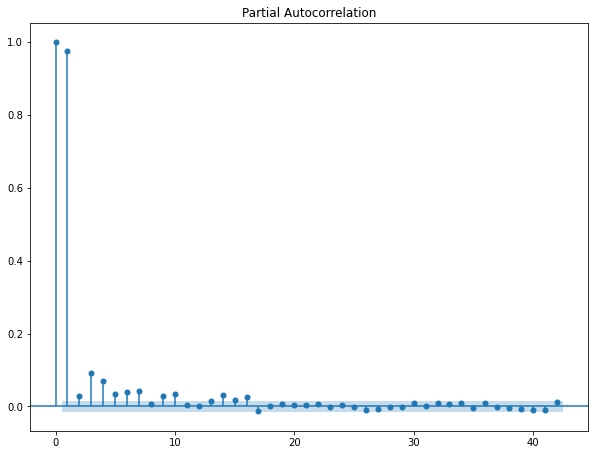

sinus-speed


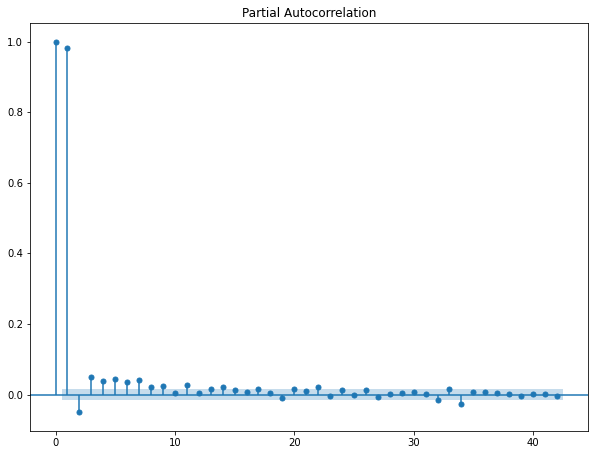

314
cosine-speed


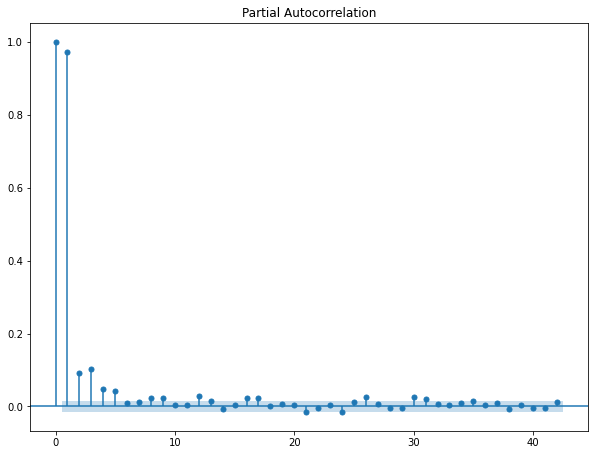

sinus-speed


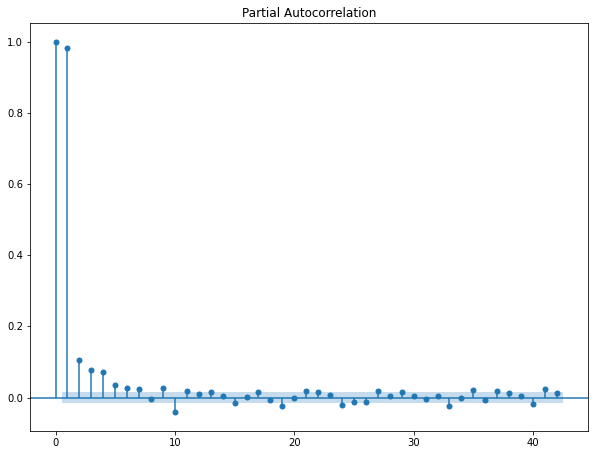

123
cosine-speed


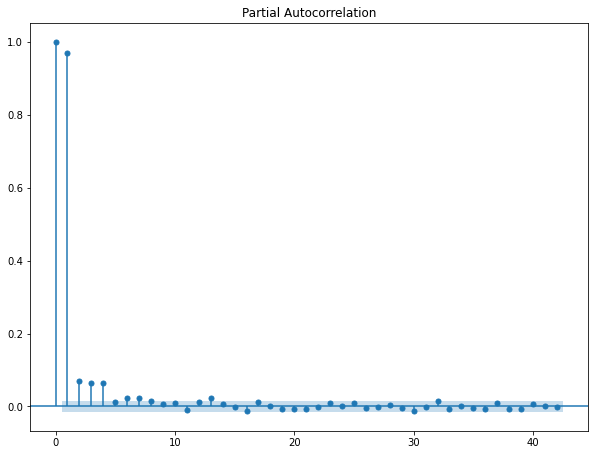

sinus-speed


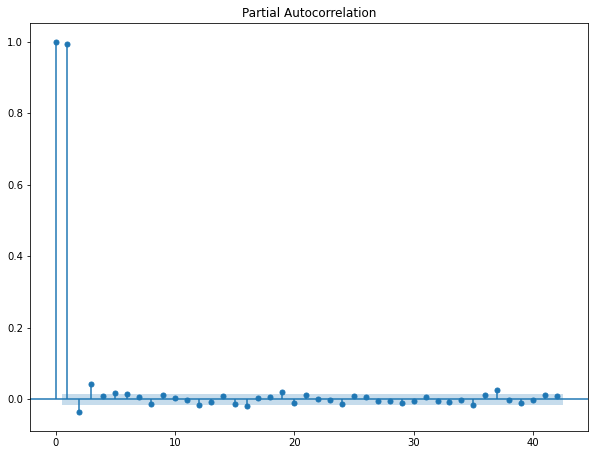

217
cosine-speed


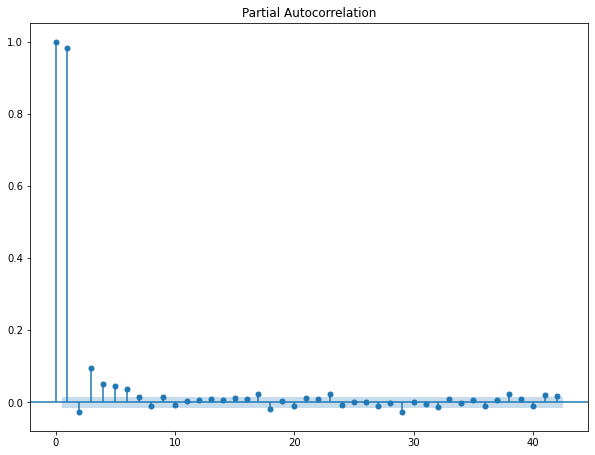

sinus-speed


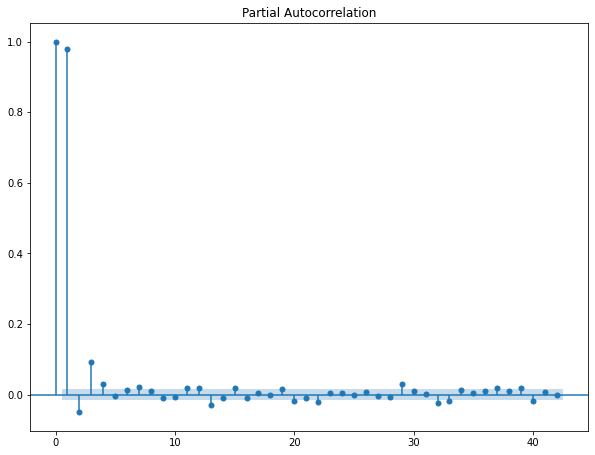

211
cosine-speed


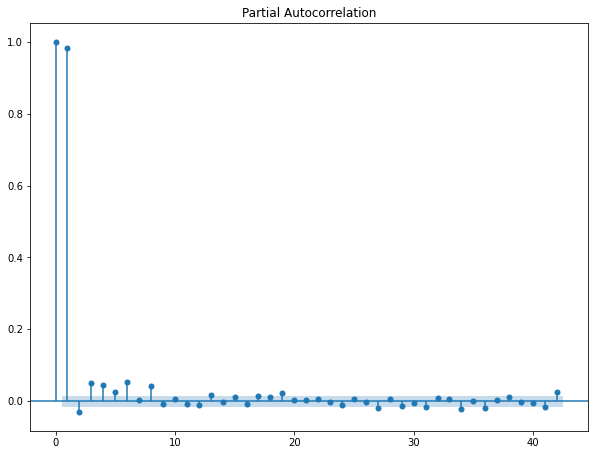

sinus-speed


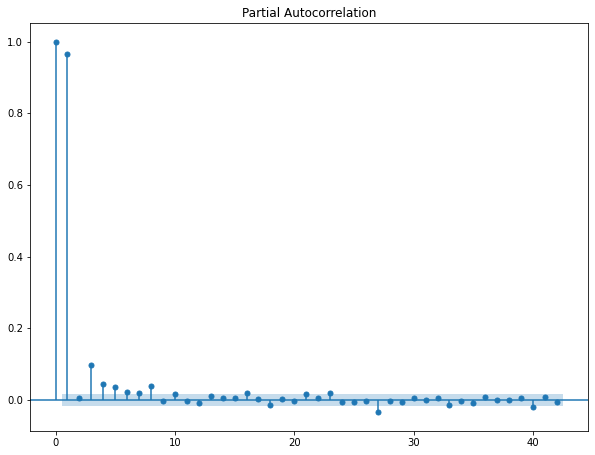

201
cosine-speed


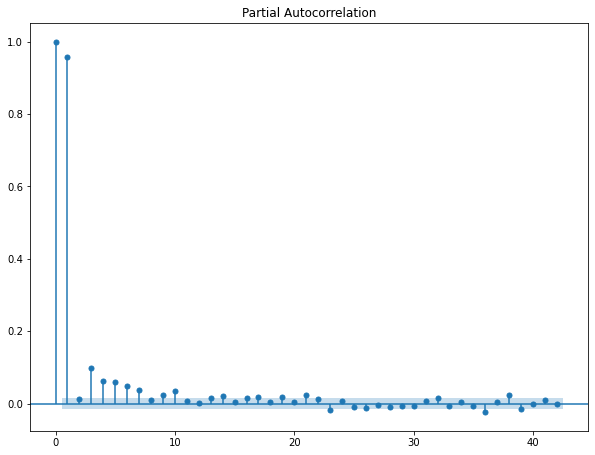

sinus-speed


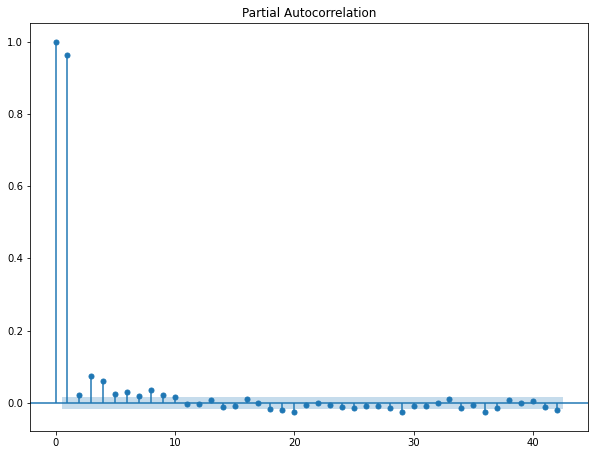

203
cosine-speed


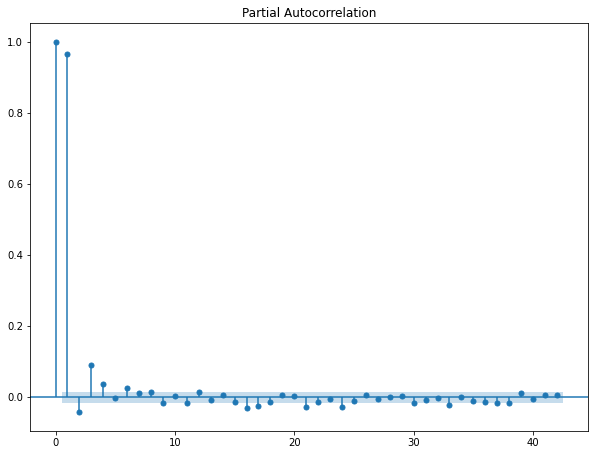

sinus-speed


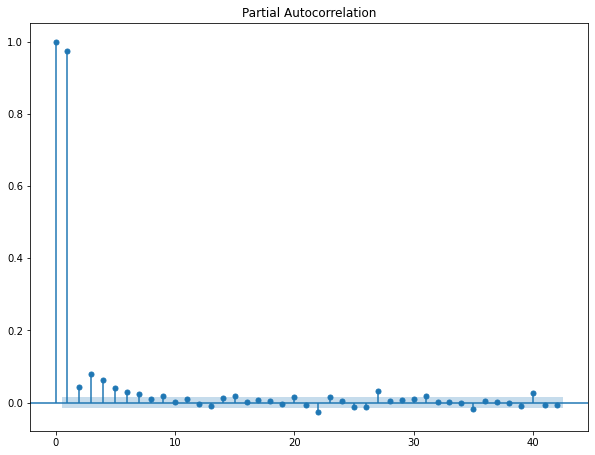

407
cosine-speed


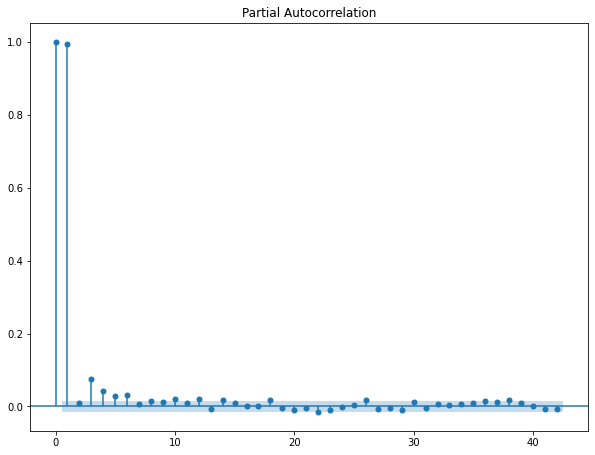

sinus-speed


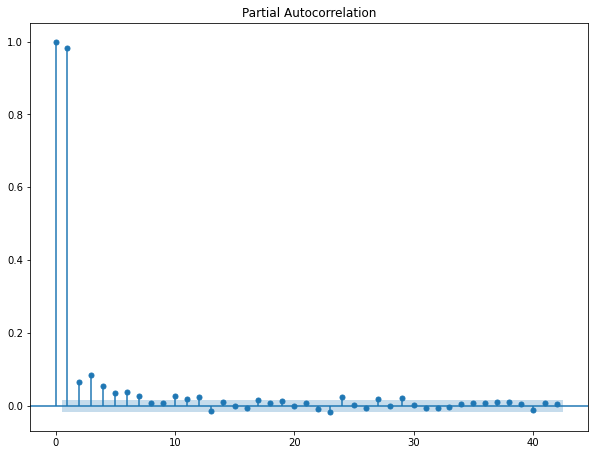

416
cosine-speed


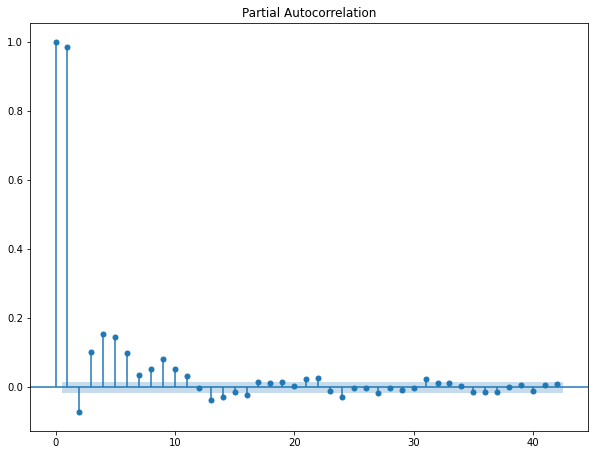

sinus-speed


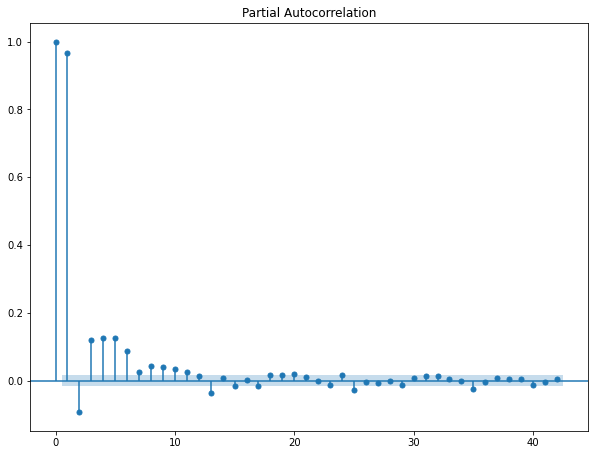

404
cosine-speed


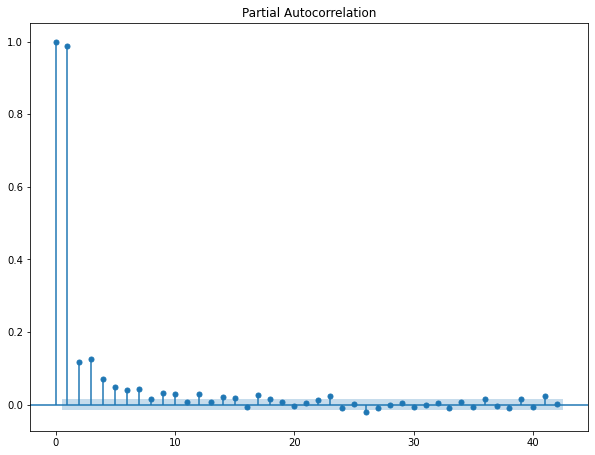

sinus-speed


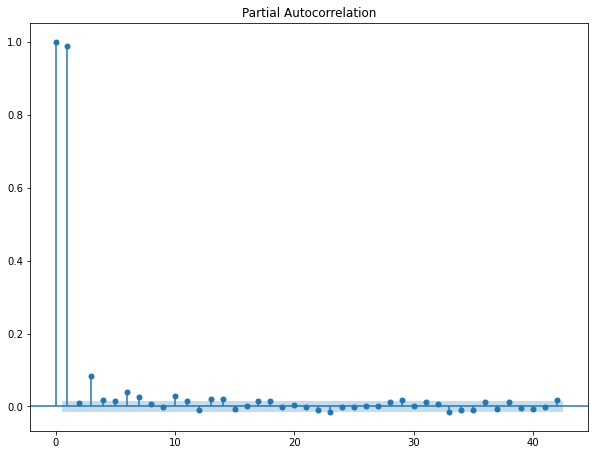

301
cosine-speed


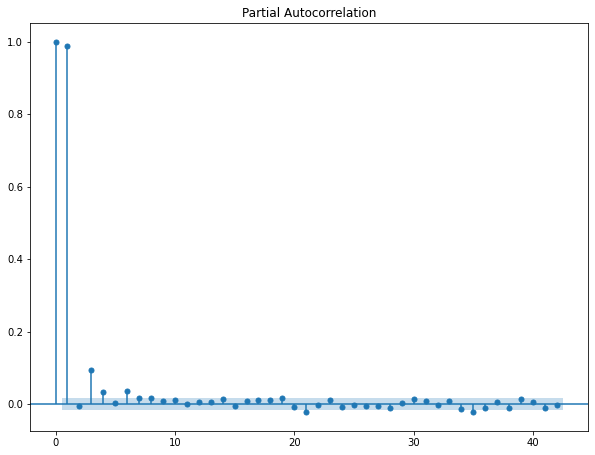

sinus-speed


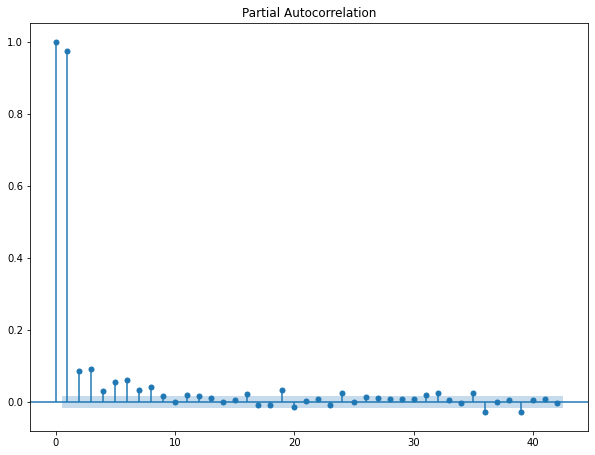

405
cosine-speed


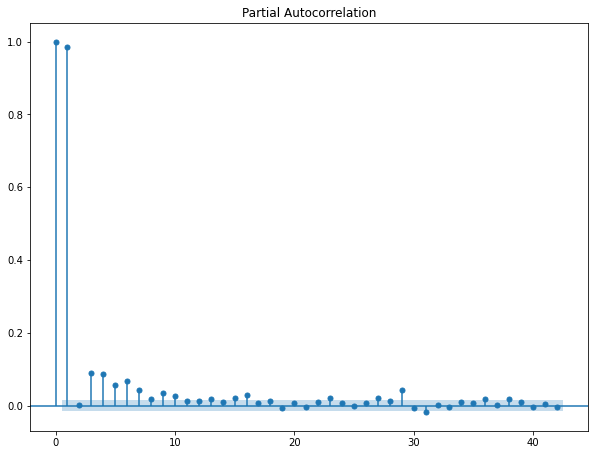

sinus-speed


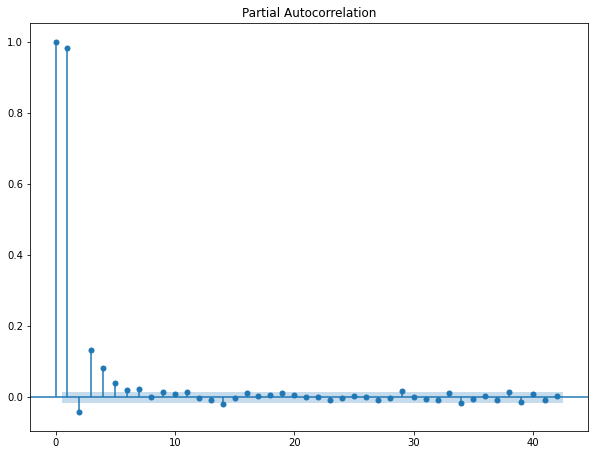

406
cosine-speed


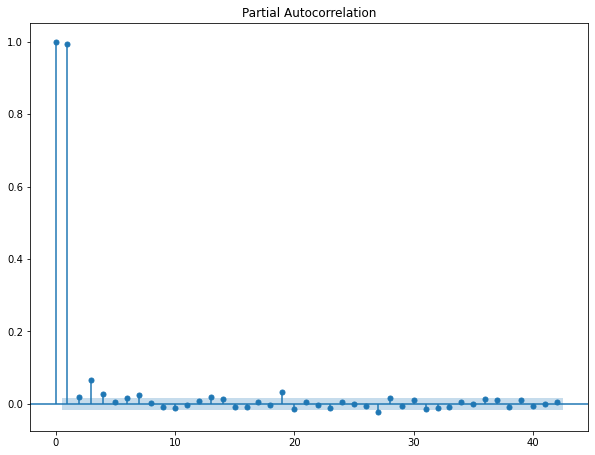

sinus-speed


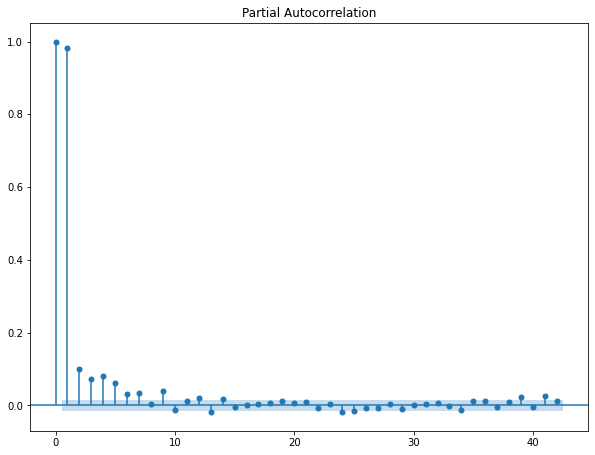

308
cosine-speed


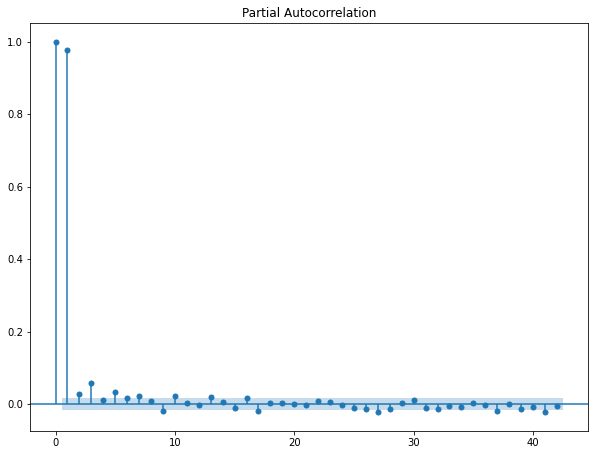

sinus-speed


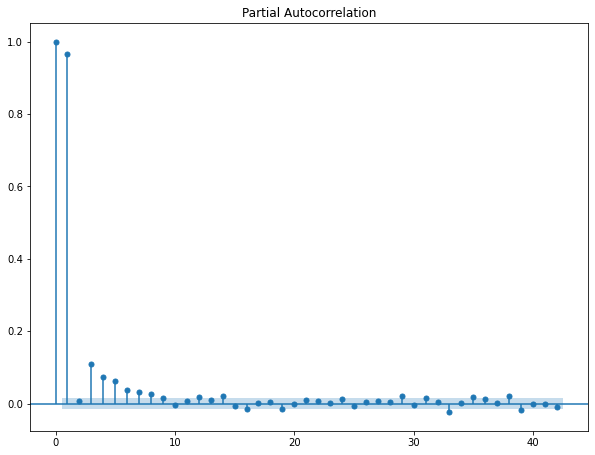

218
cosine-speed


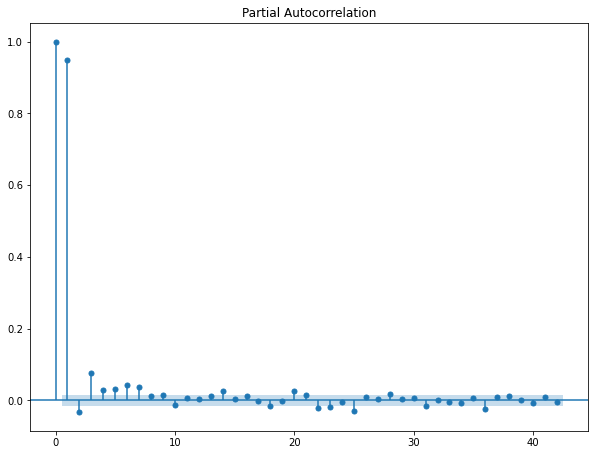

sinus-speed


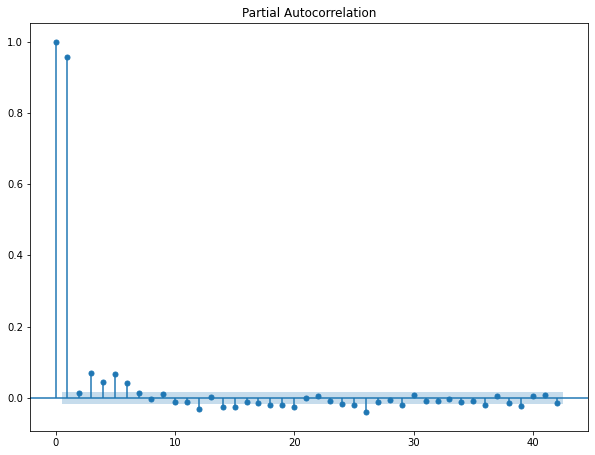

412
cosine-speed


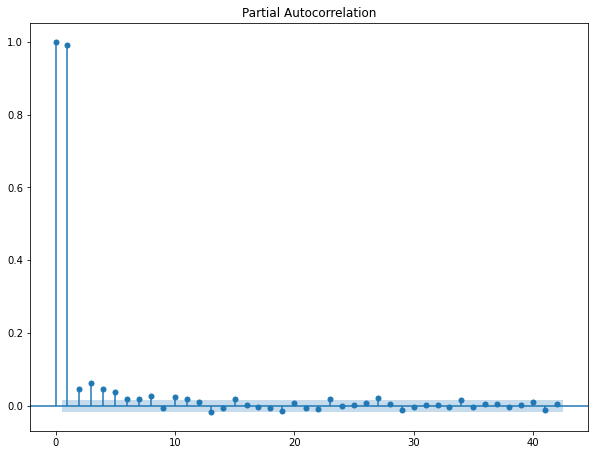

sinus-speed


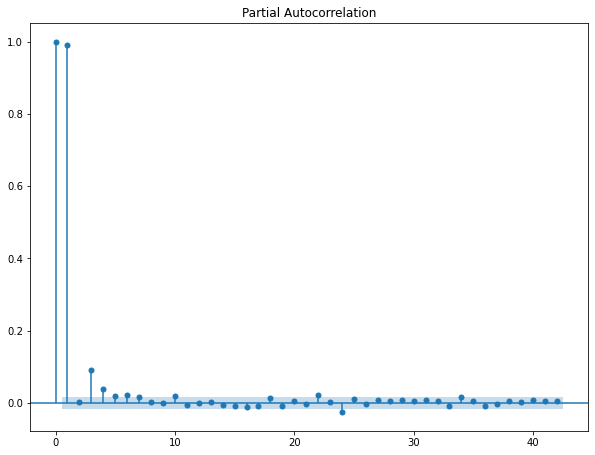

163
cosine-speed


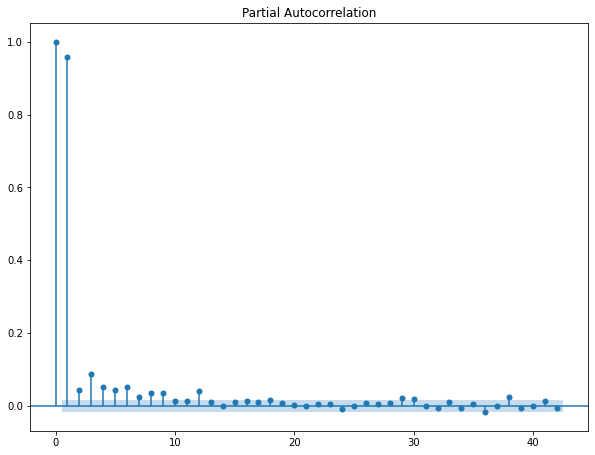

sinus-speed


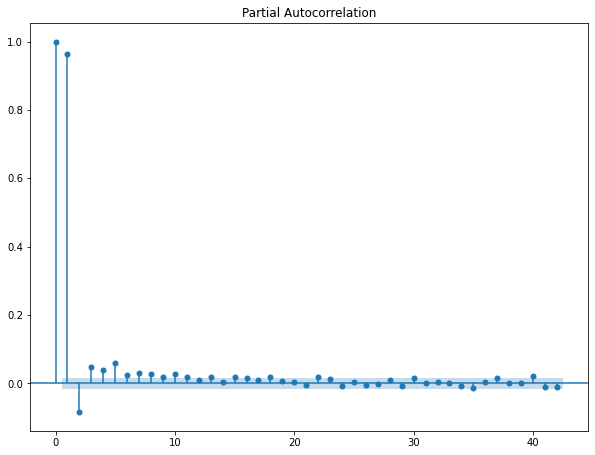

101
cosine-speed


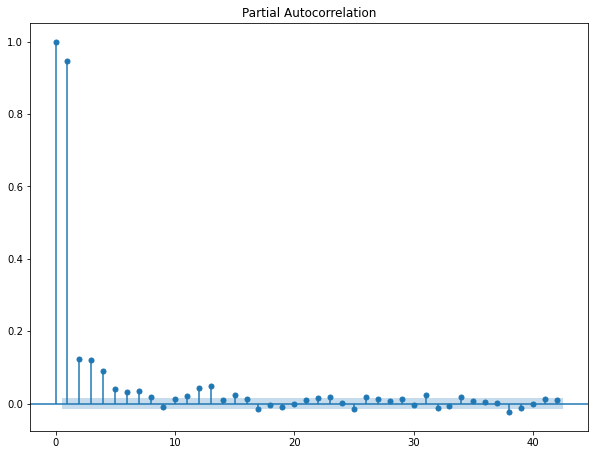

sinus-speed


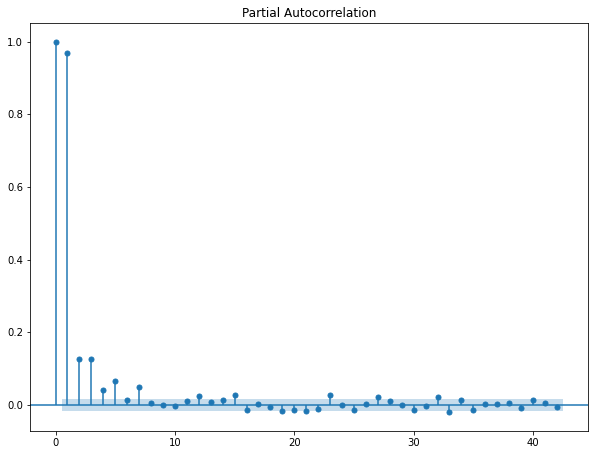

102
cosine-speed


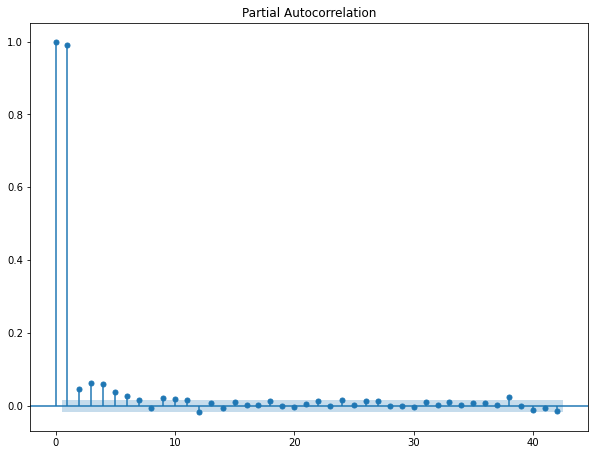

sinus-speed


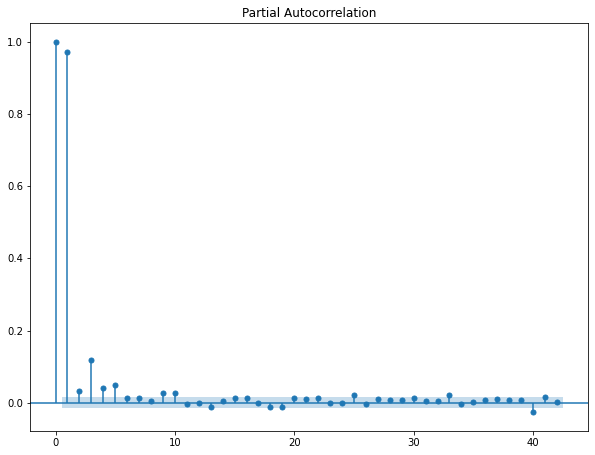

160
cosine-speed


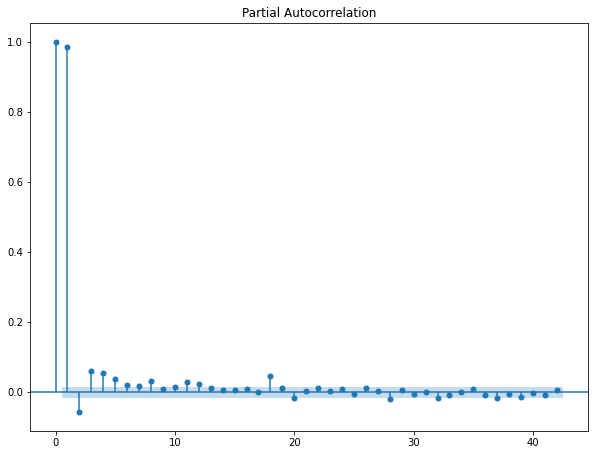

sinus-speed


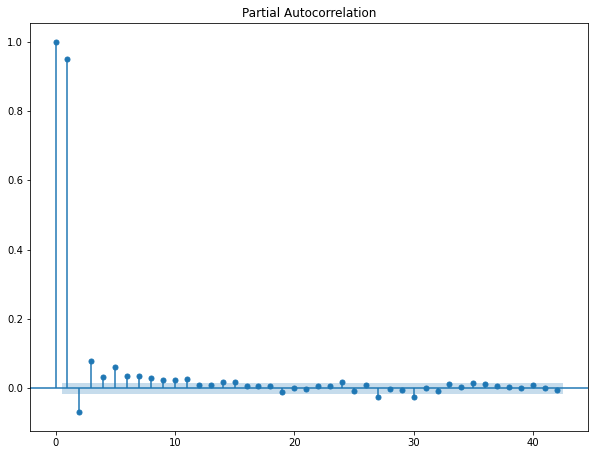

312
cosine-speed


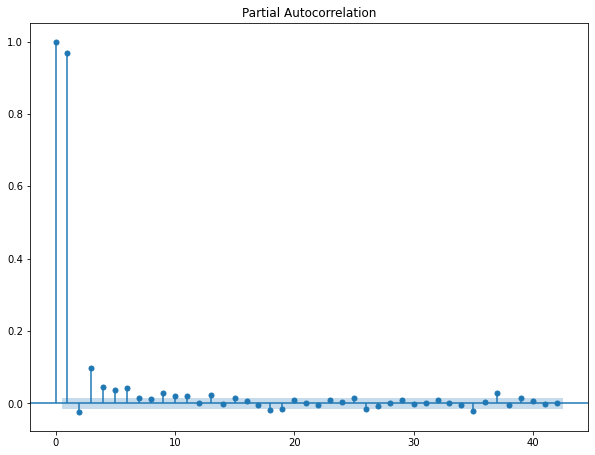

sinus-speed


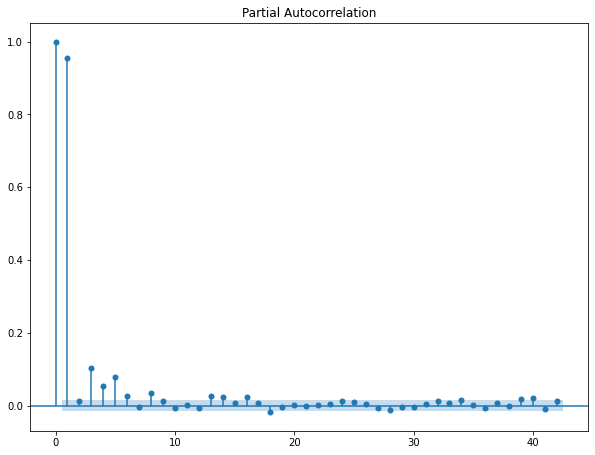

152
cosine-speed


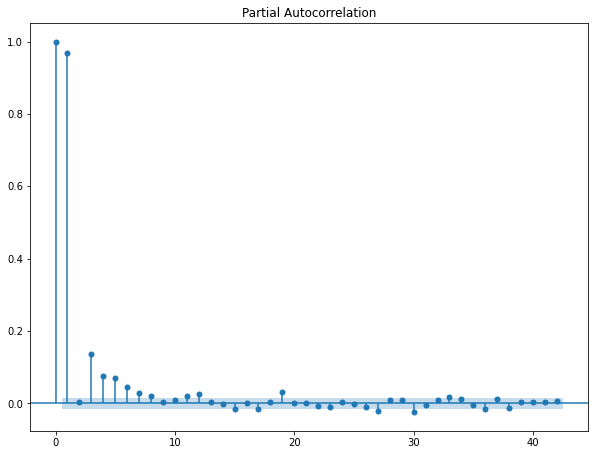

sinus-speed


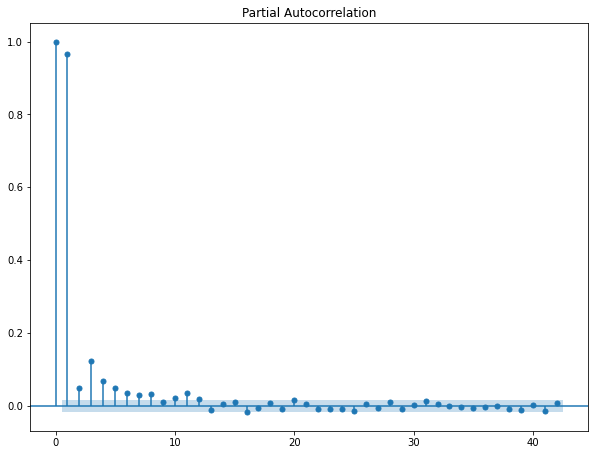

150
cosine-speed


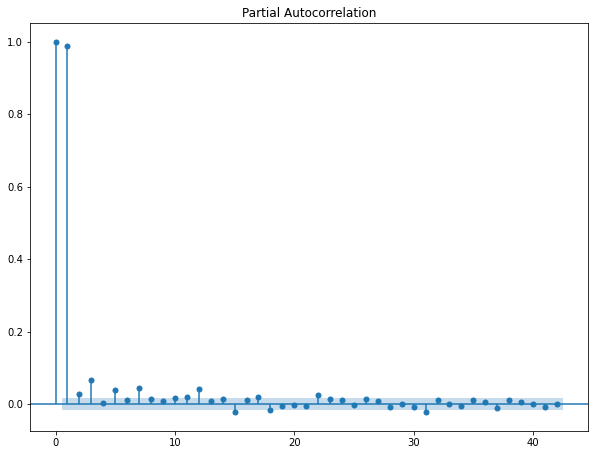

sinus-speed


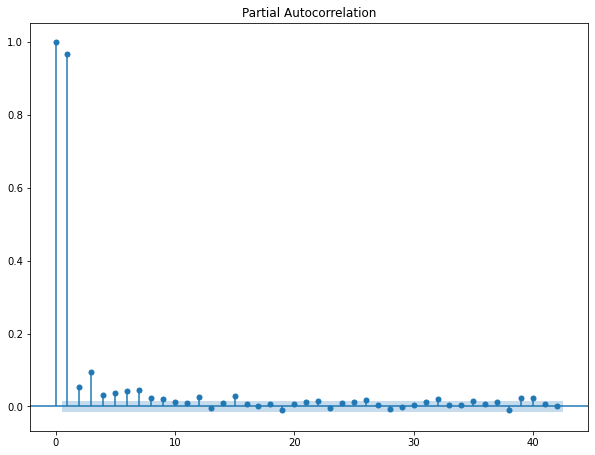

125
cosine-speed


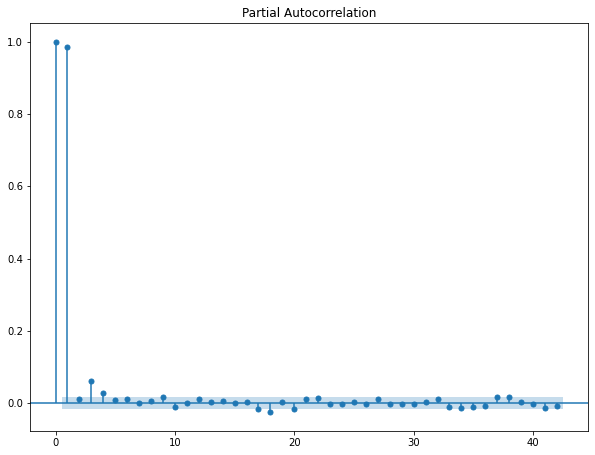

sinus-speed


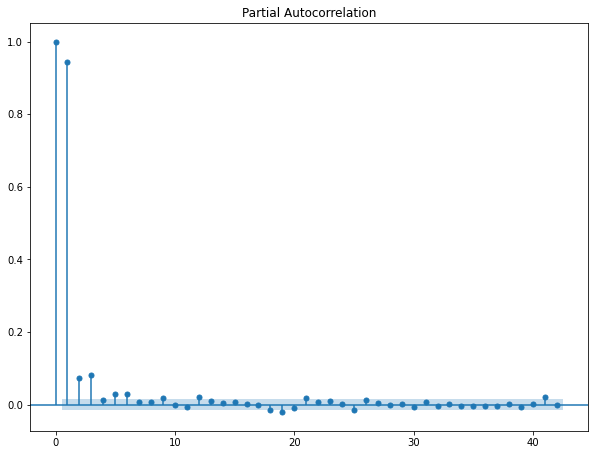

164
cosine-speed


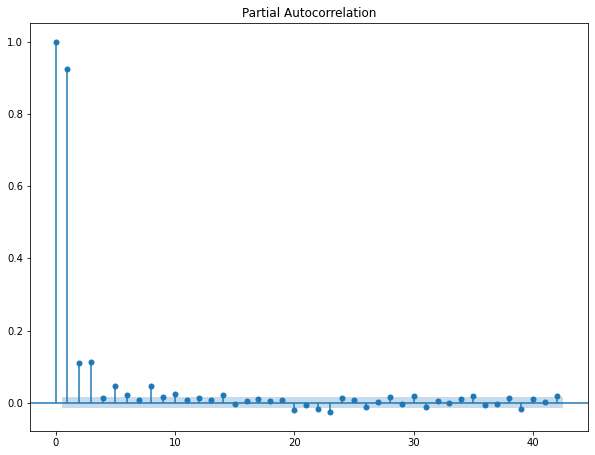

sinus-speed


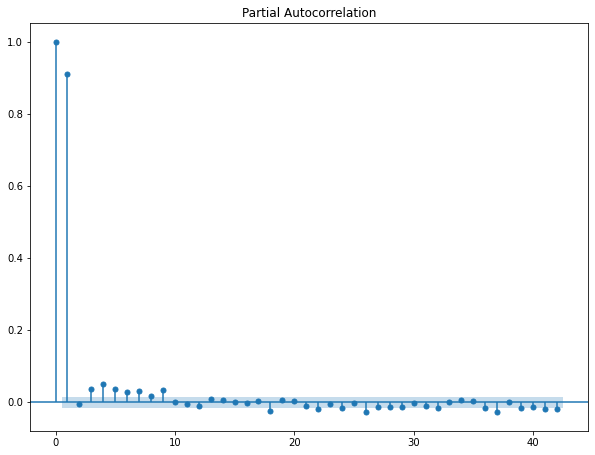

311
cosine-speed


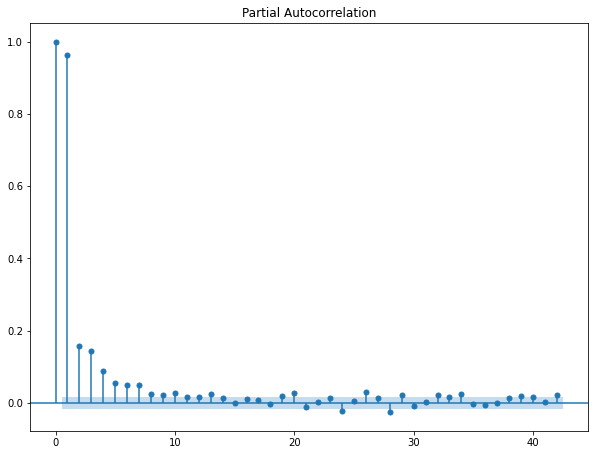

sinus-speed


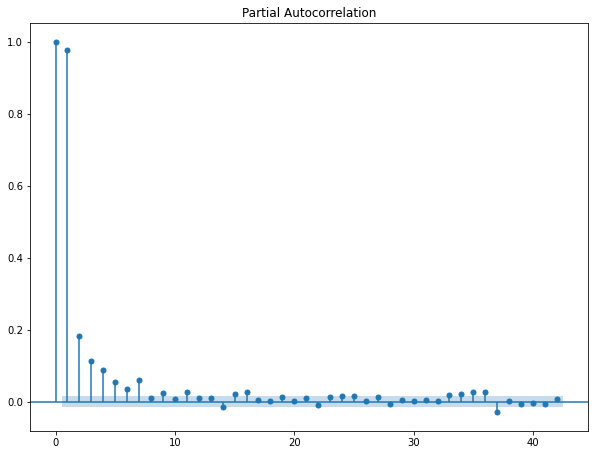

205
cosine-speed


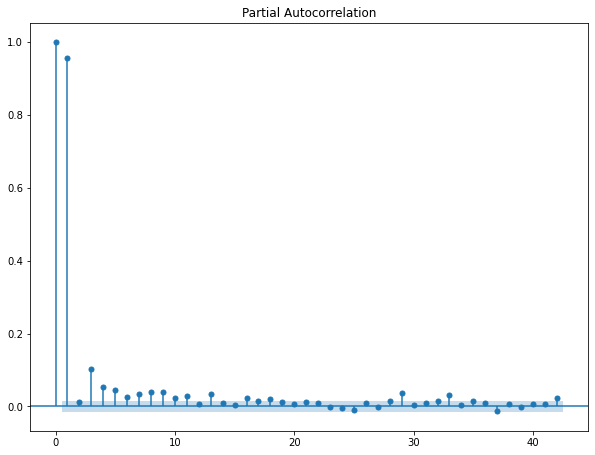

sinus-speed


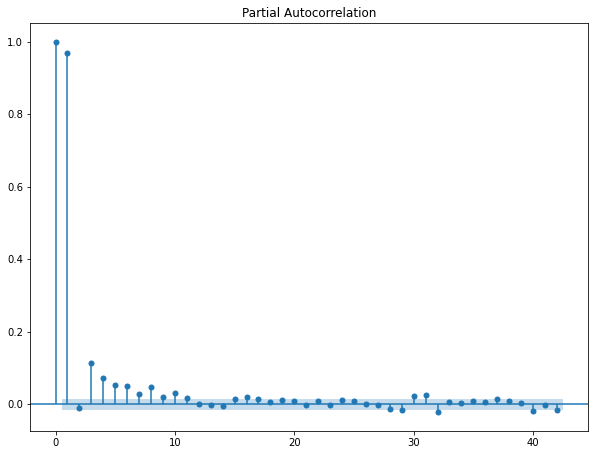

417
cosine-speed


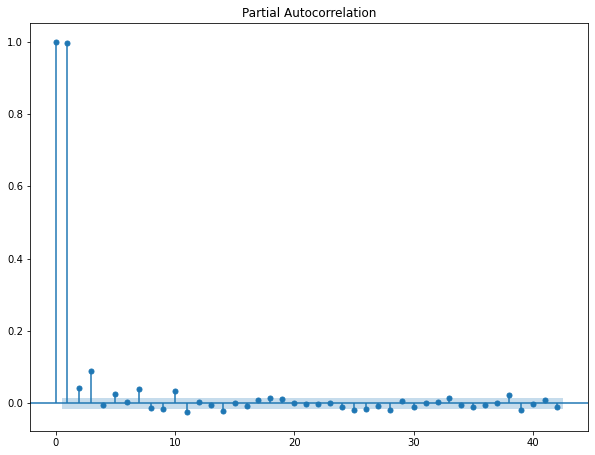

sinus-speed


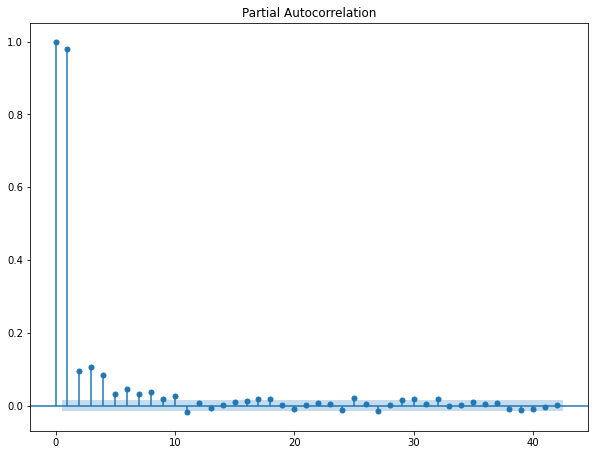

64
cosine-speed


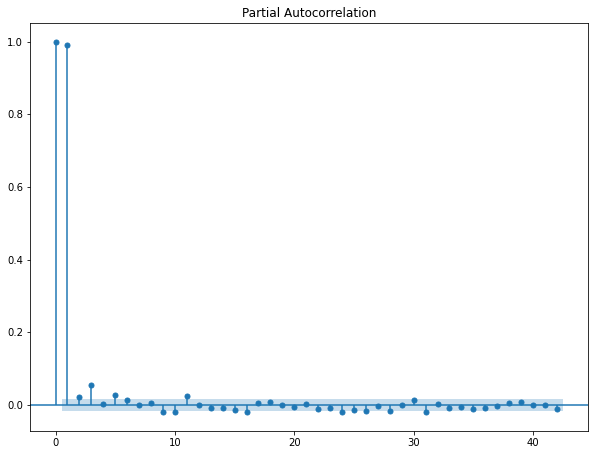

sinus-speed


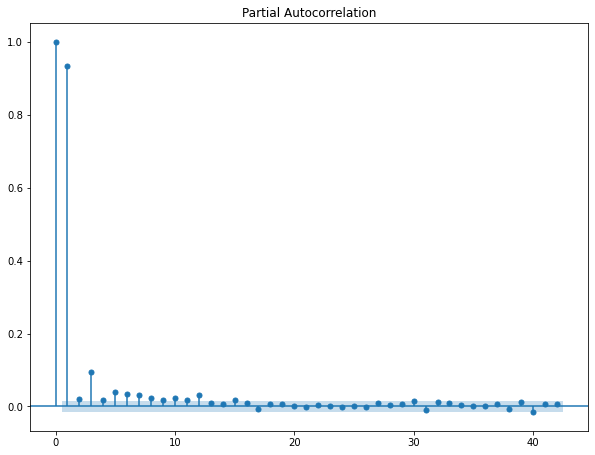

65
cosine-speed


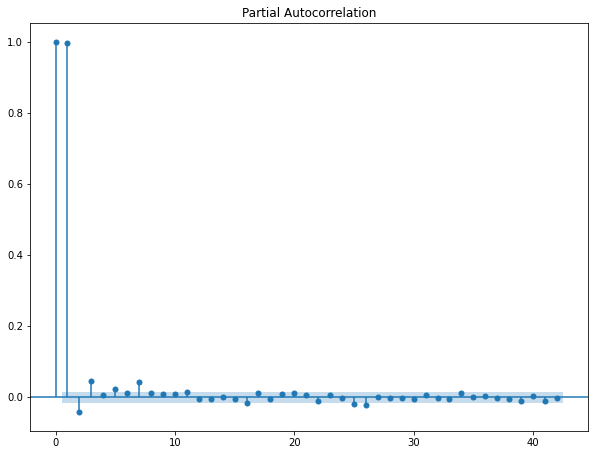

sinus-speed


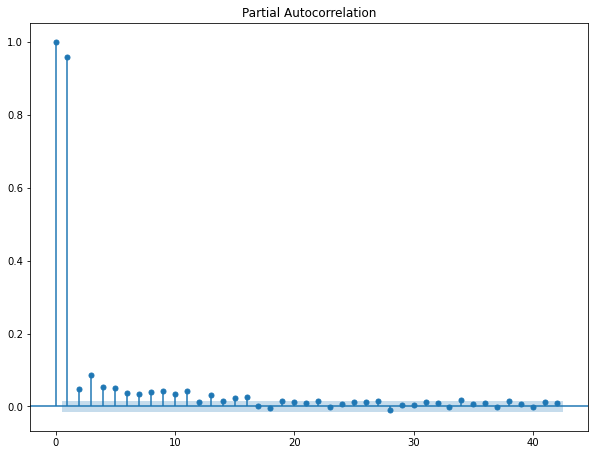

310
cosine-speed


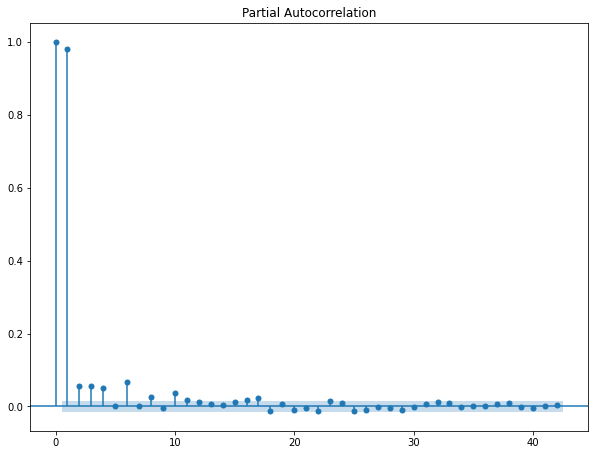

sinus-speed


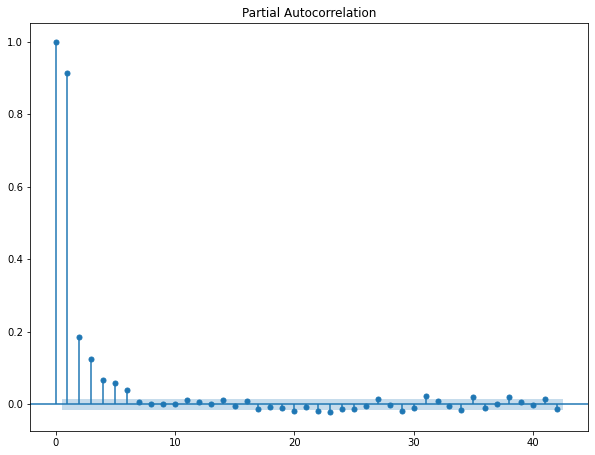

402
cosine-speed


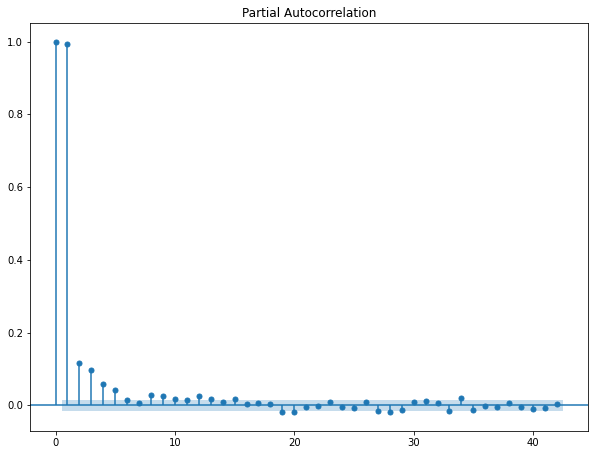

sinus-speed


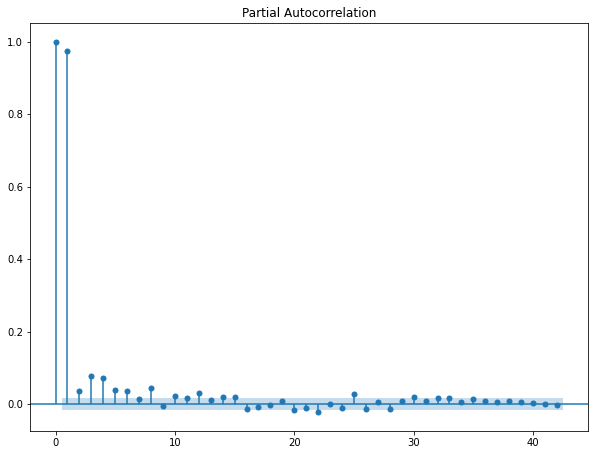

415
cosine-speed


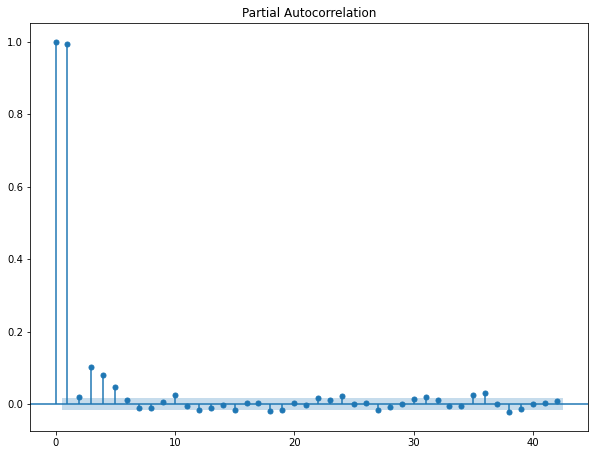

sinus-speed


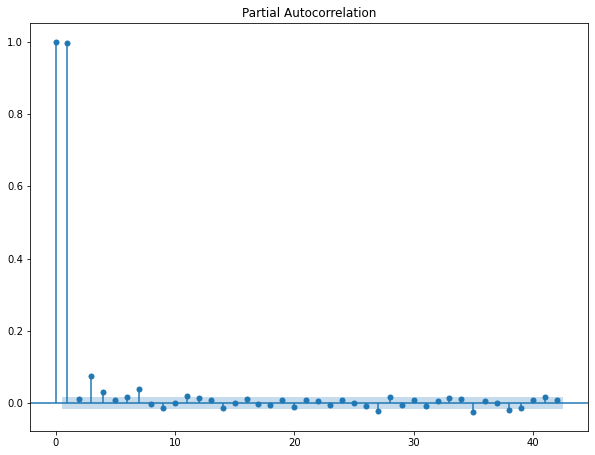

151
cosine-speed


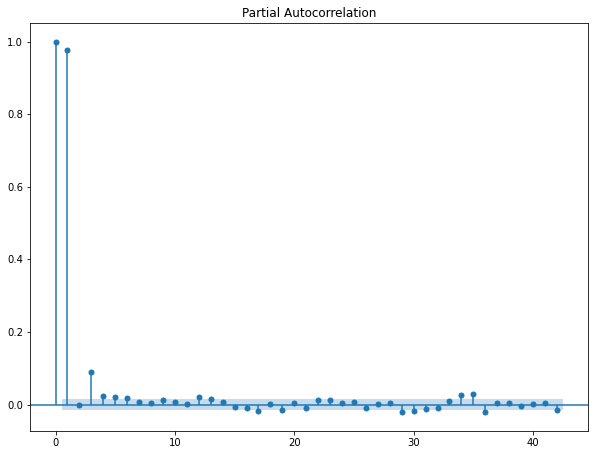

sinus-speed


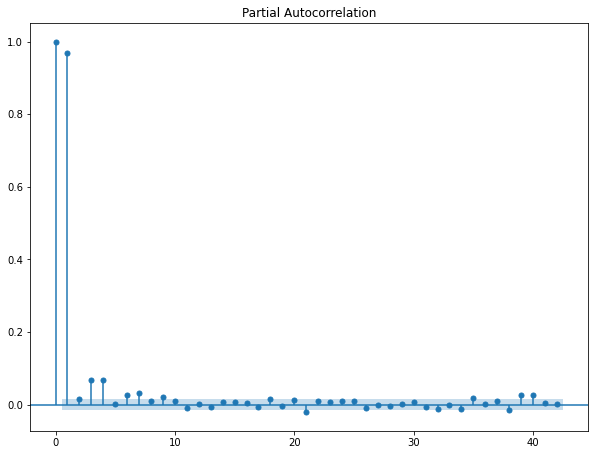

418
cosine-speed


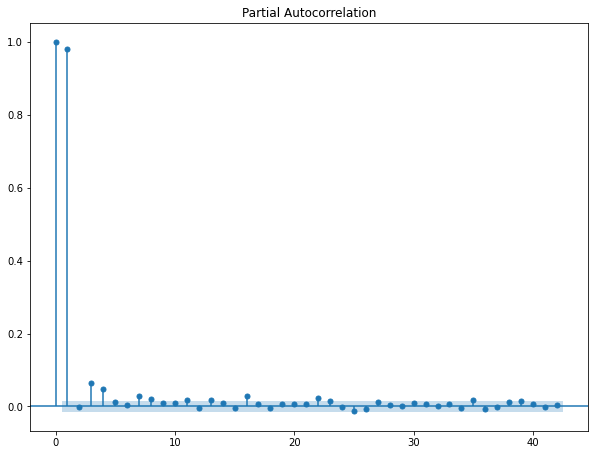

sinus-speed


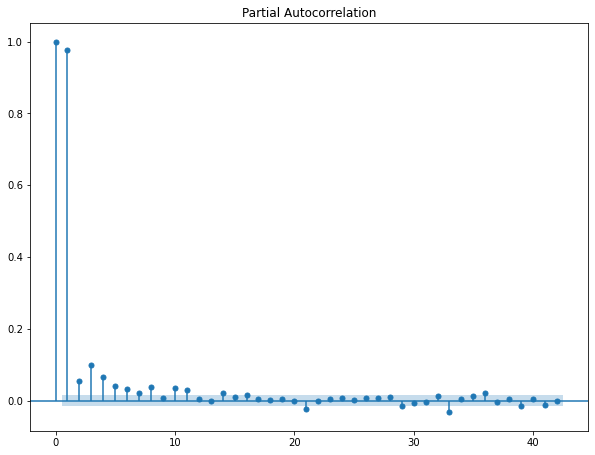

202
cosine-speed


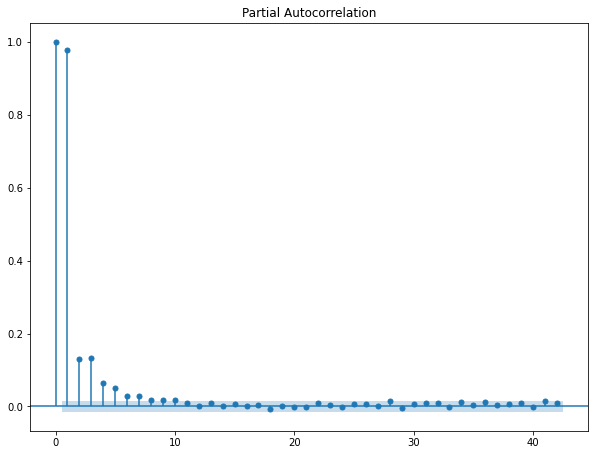

sinus-speed


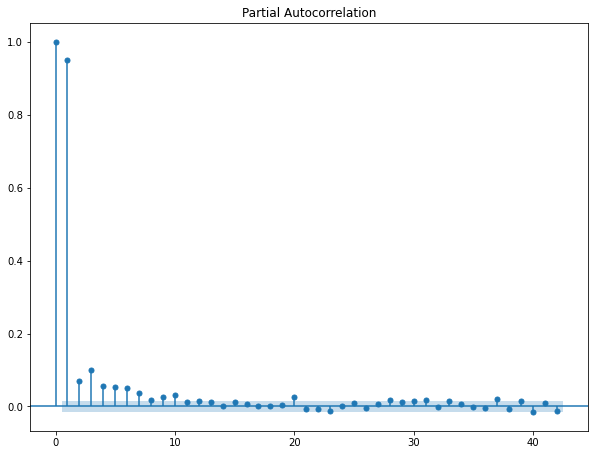

304
cosine-speed


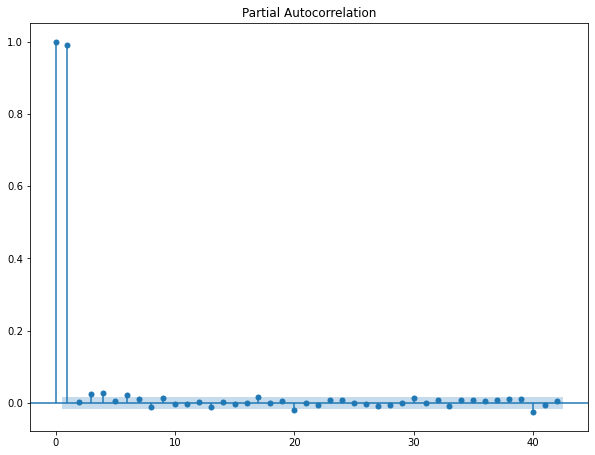

sinus-speed


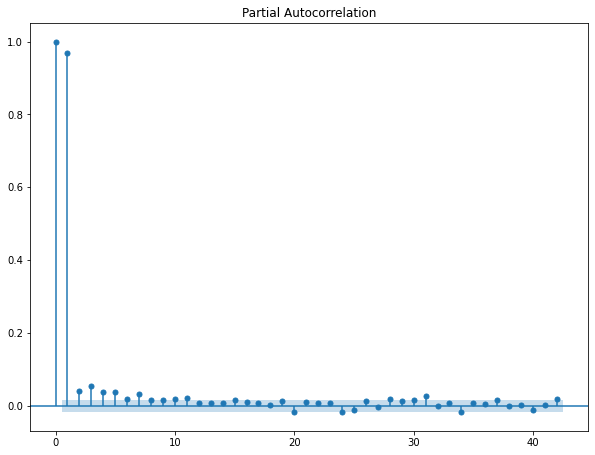

161
cosine-speed


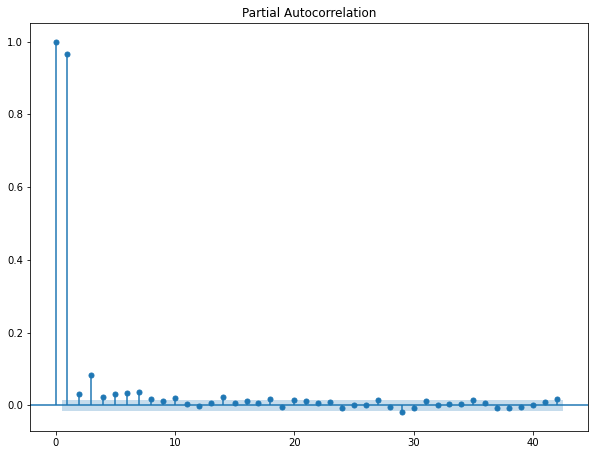

sinus-speed


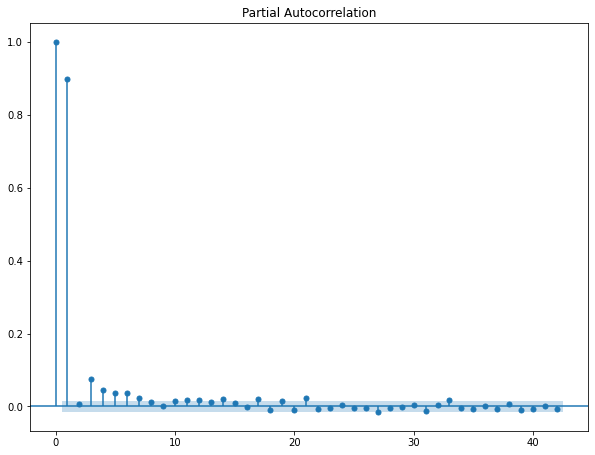

413
cosine-speed


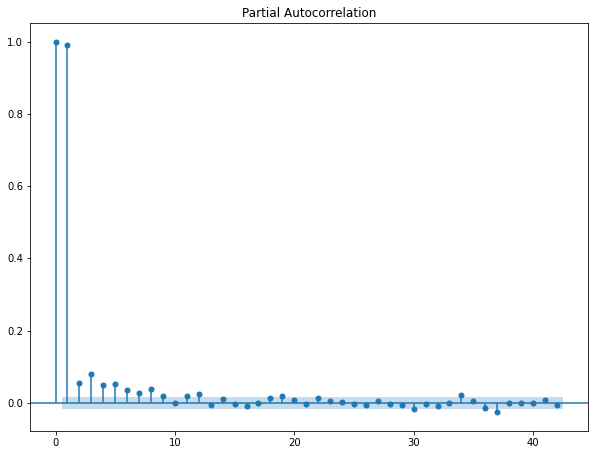

sinus-speed


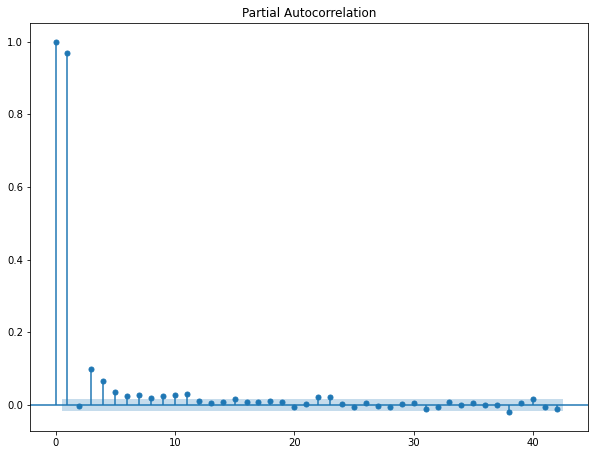

108
cosine-speed


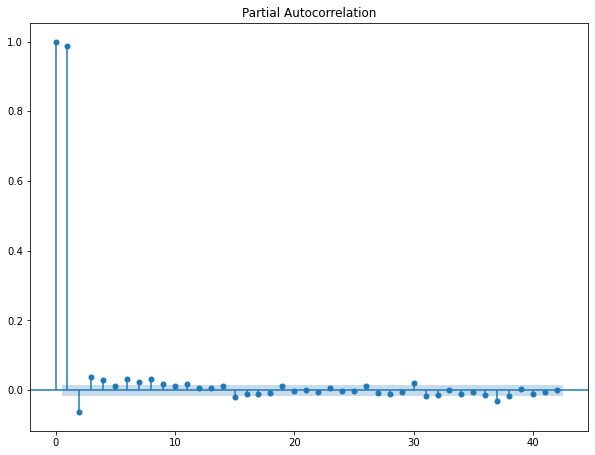

sinus-speed


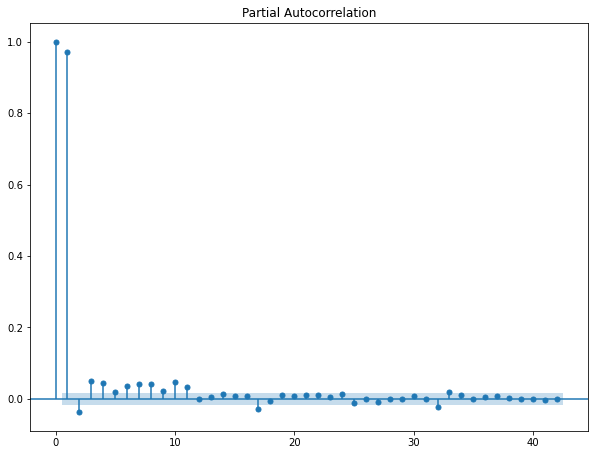

414
cosine-speed


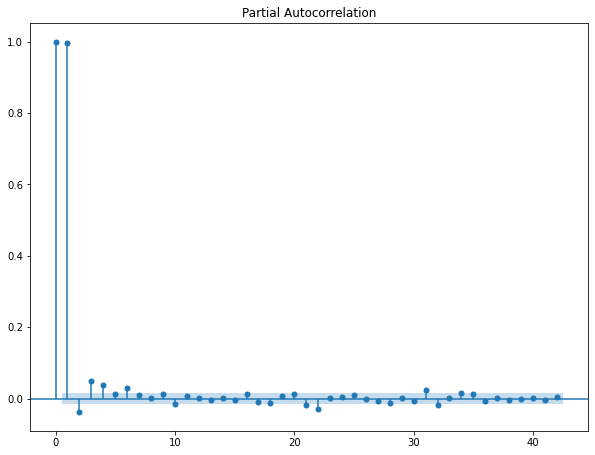

sinus-speed


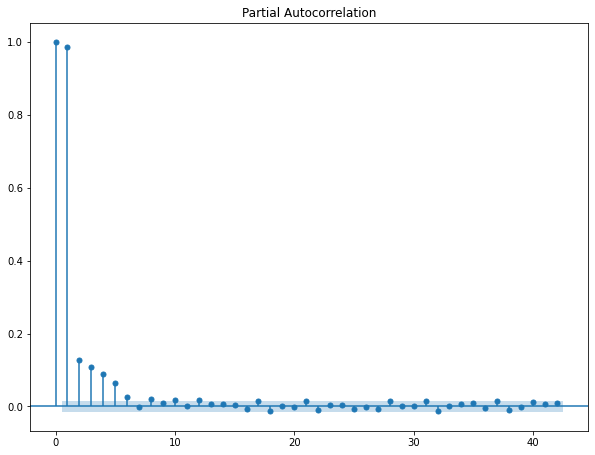

305
cosine-speed


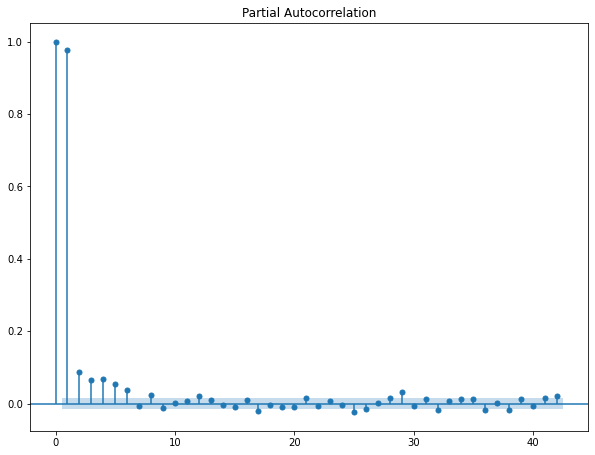

sinus-speed


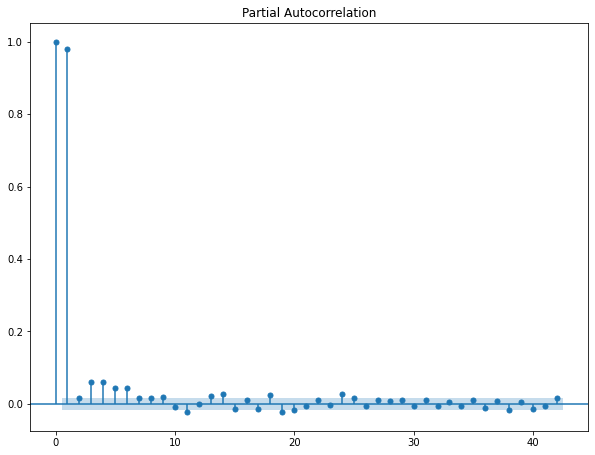

408
cosine-speed


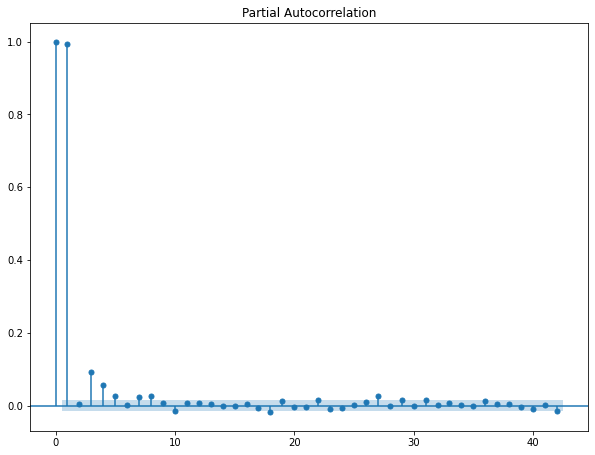

sinus-speed


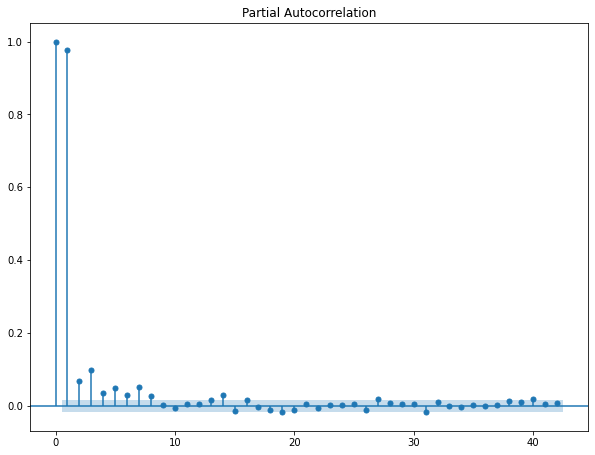

306
cosine-speed


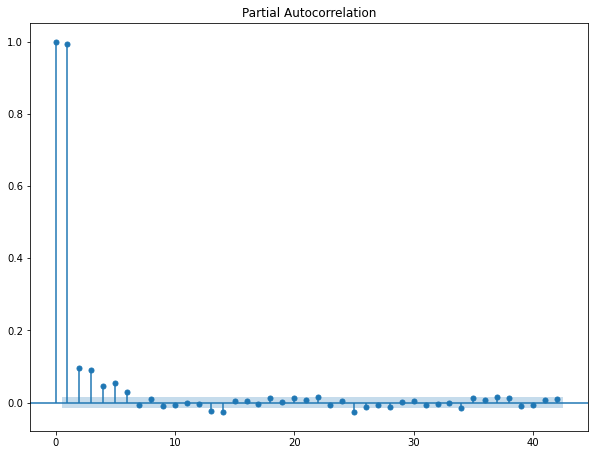

sinus-speed


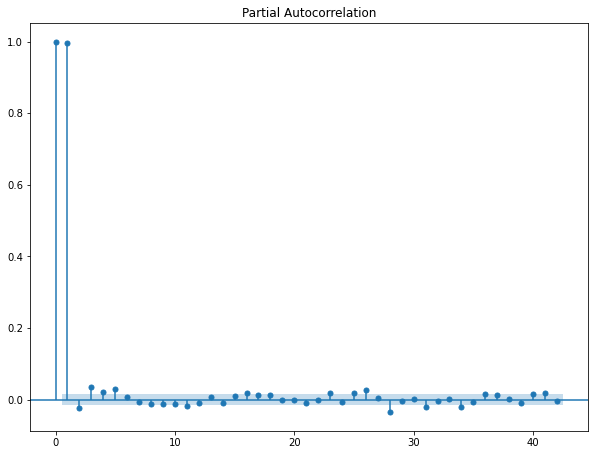

71
cosine-speed


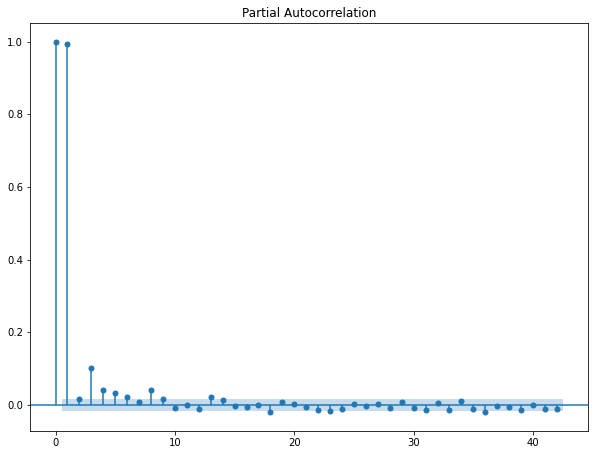

sinus-speed


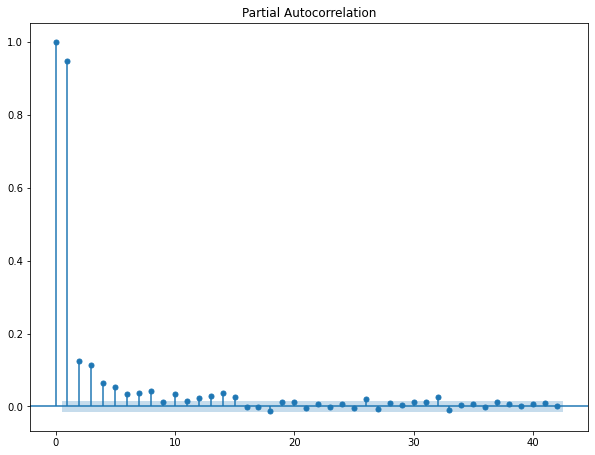

410
cosine-speed


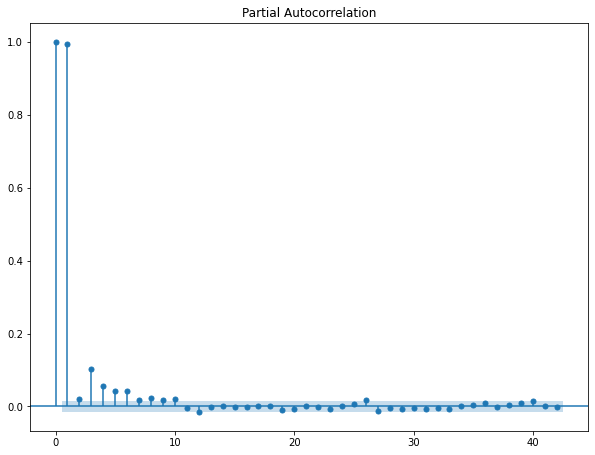

sinus-speed


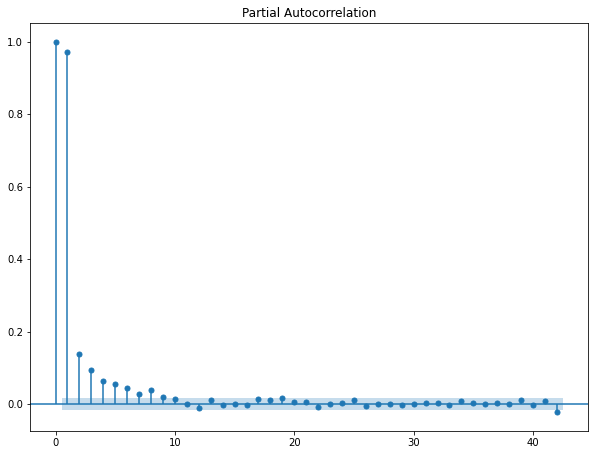

411
cosine-speed


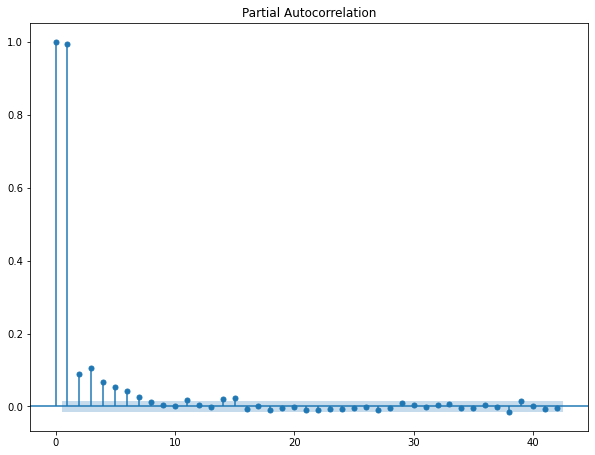

sinus-speed


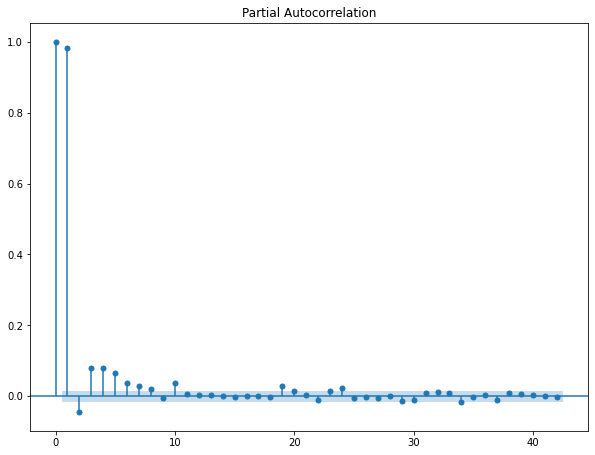

120
cosine-speed


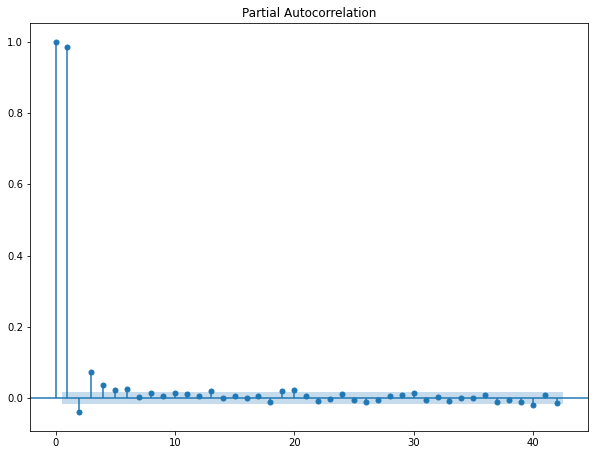

sinus-speed


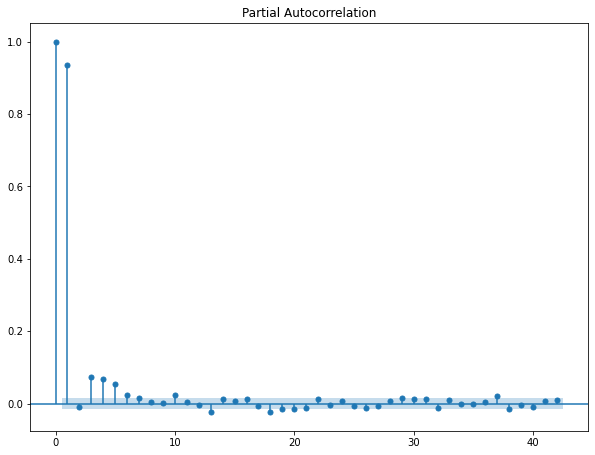

In [162]:
for city_code in final_df['city_code'].unique():
    data = final_df[final_df['city_code'] == city_code]
    data.index = data['date']
    data = data.drop(columns=['date'])
    print(city_code)
    for name, column in data[["cosine-speed","sinus-speed"]].iteritems():
        print(name)
        plot_pacf(column)
        if city_code == 105:
            plt.savefig('pacf' + name + '.pdf') 
        plt.show()

105
cosine-speed


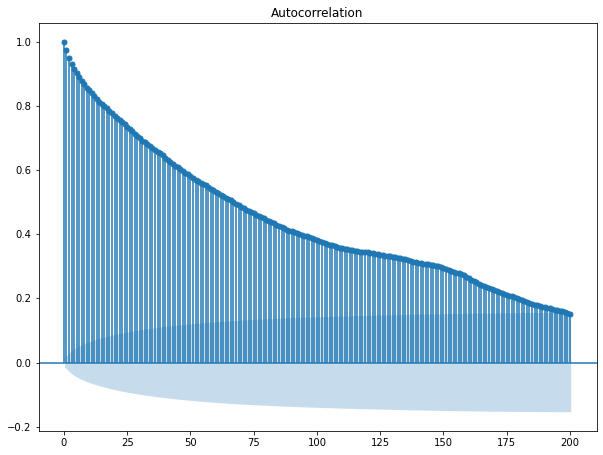

sinus-speed


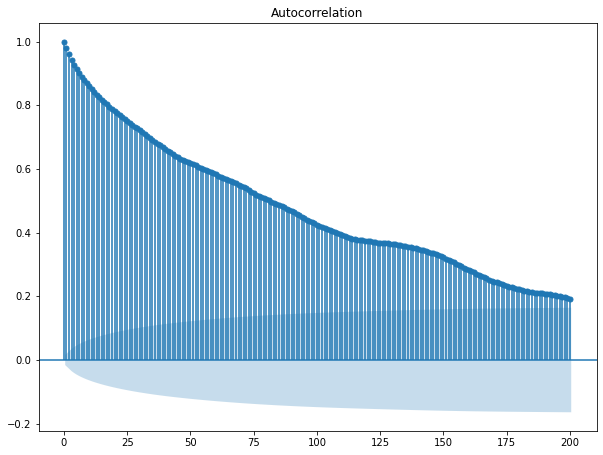

314
cosine-speed


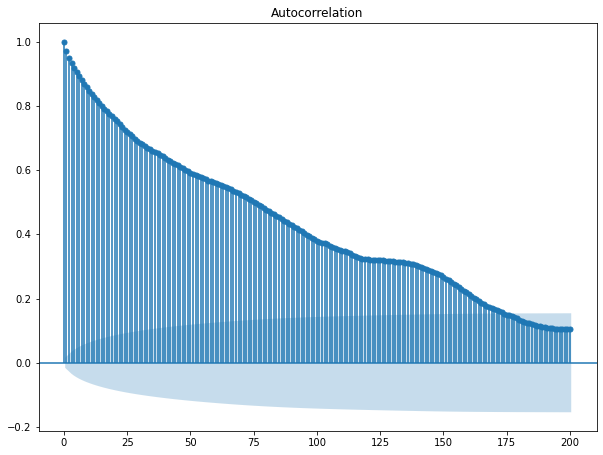

sinus-speed


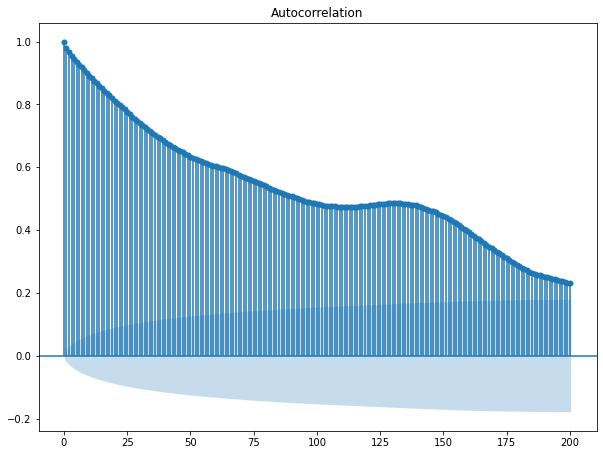

123
cosine-speed


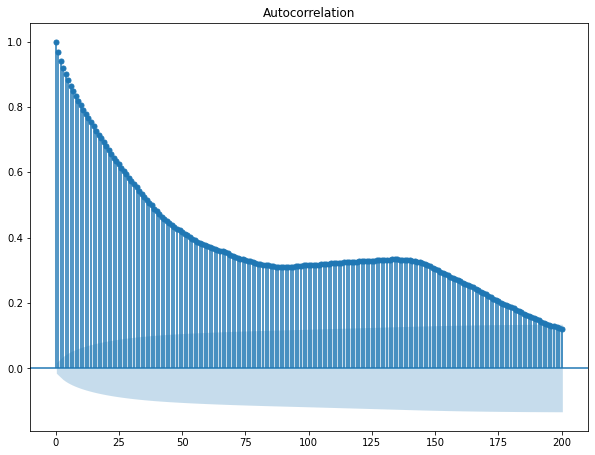

sinus-speed


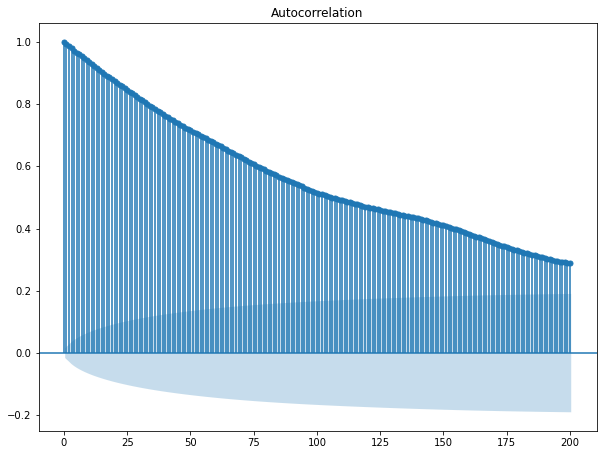

217
cosine-speed


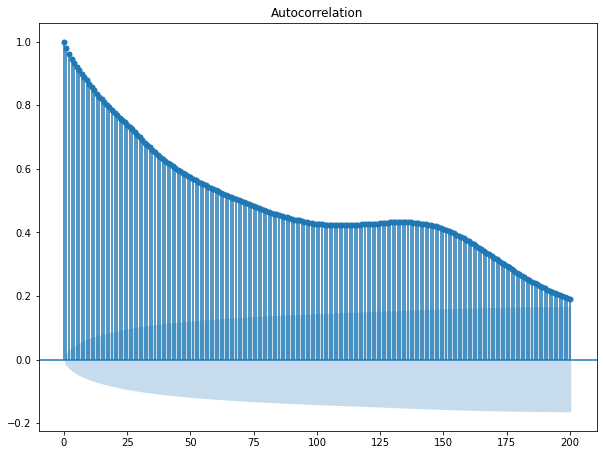

sinus-speed


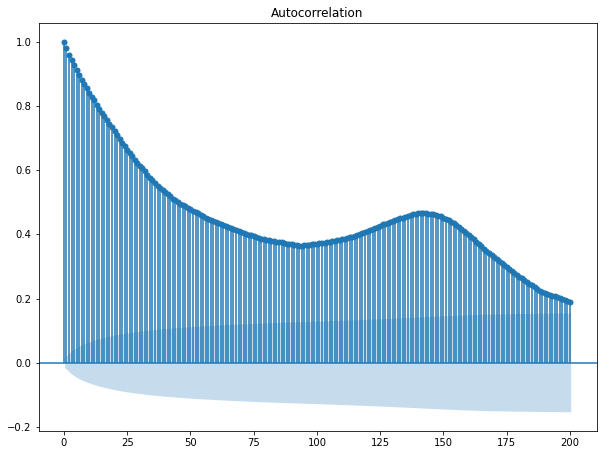

211
cosine-speed


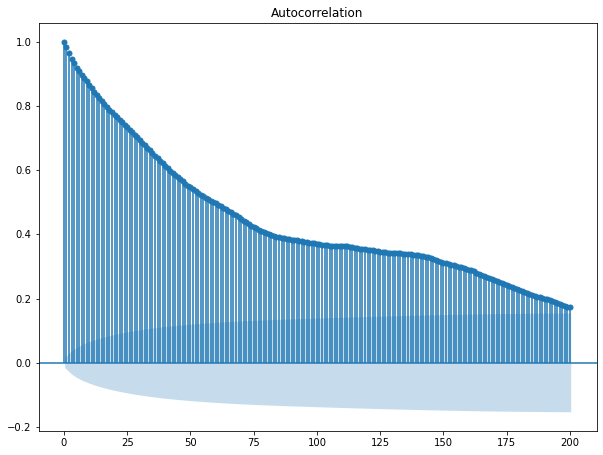

sinus-speed


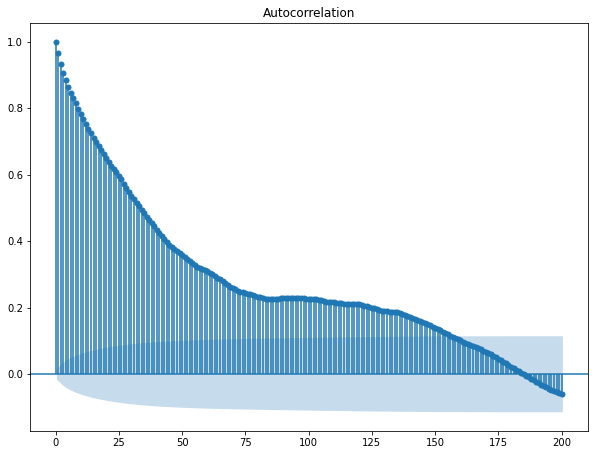

201
cosine-speed


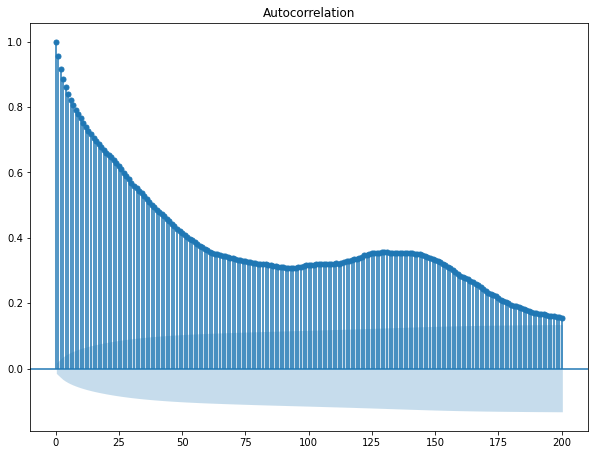

sinus-speed


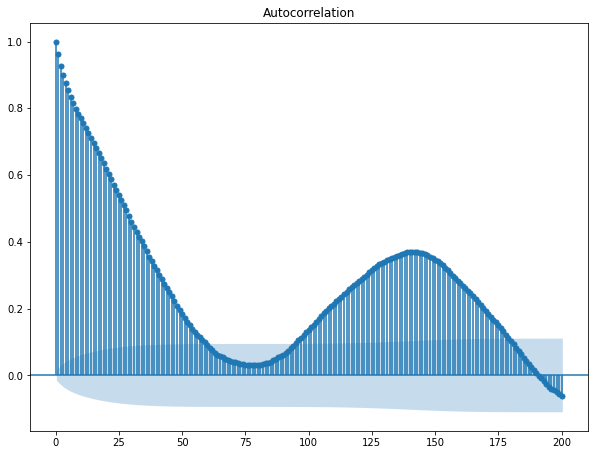

203
cosine-speed


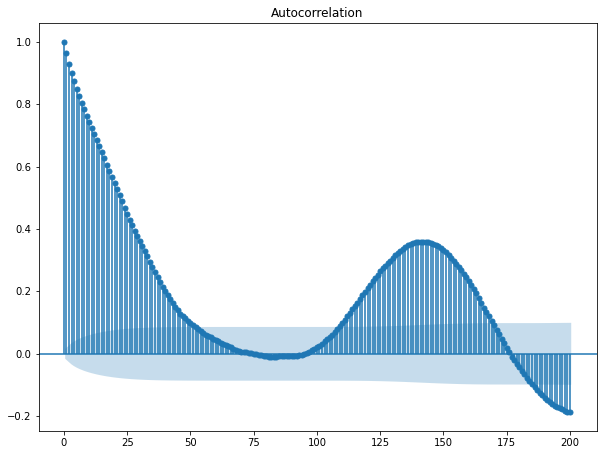

sinus-speed


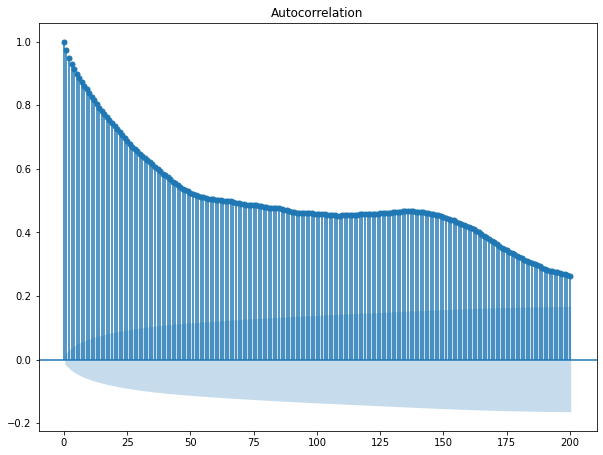

407
cosine-speed


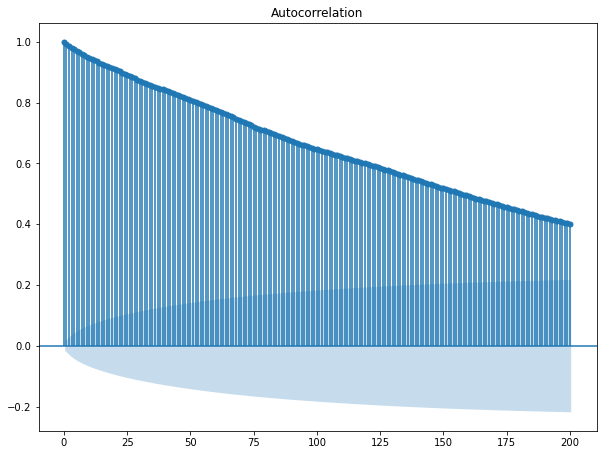

sinus-speed


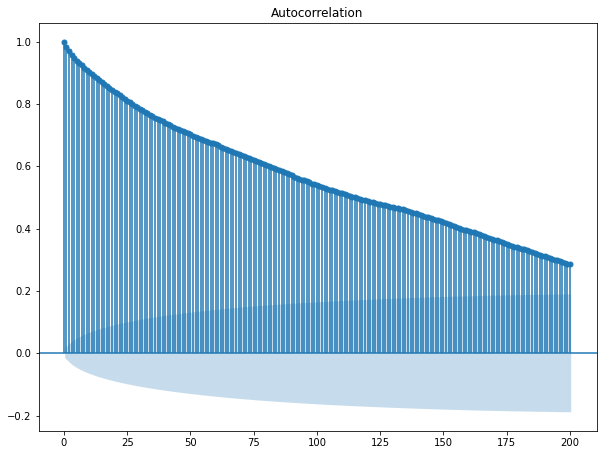

416
cosine-speed


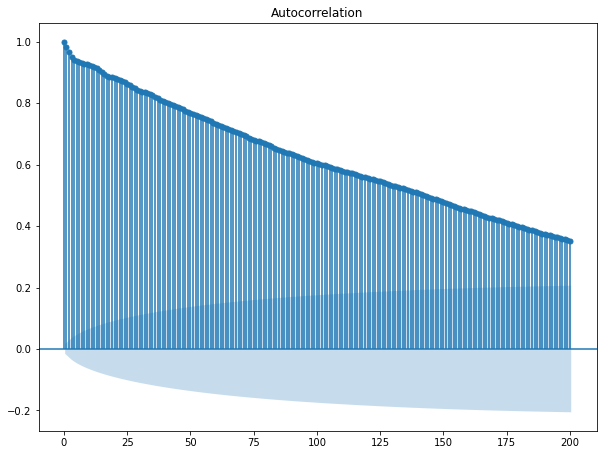

sinus-speed


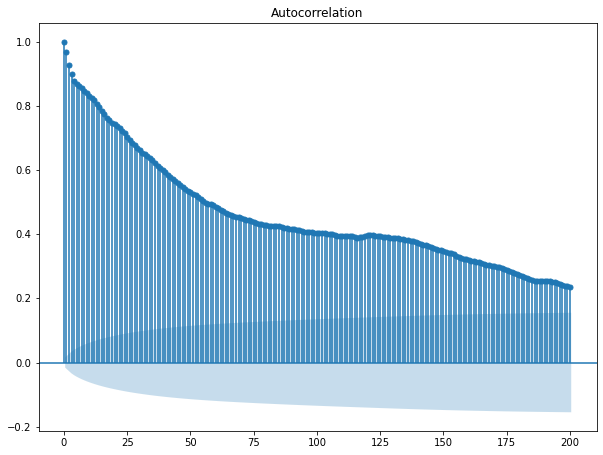

404
cosine-speed


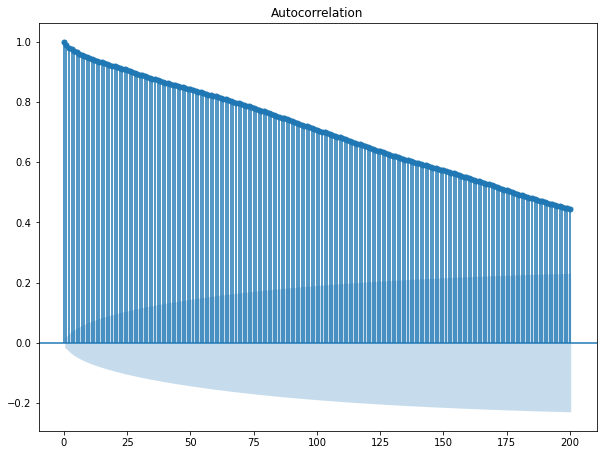

sinus-speed


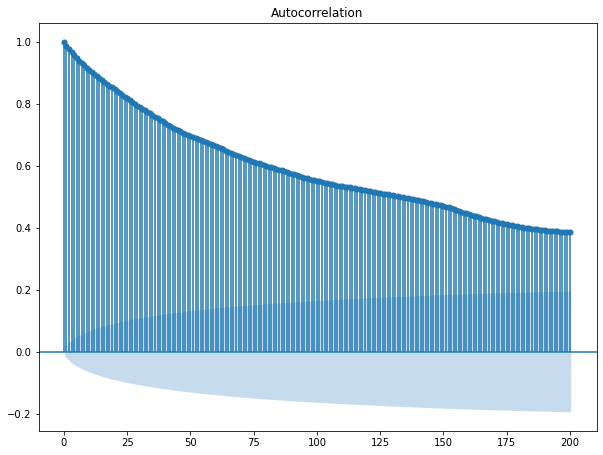

301
cosine-speed


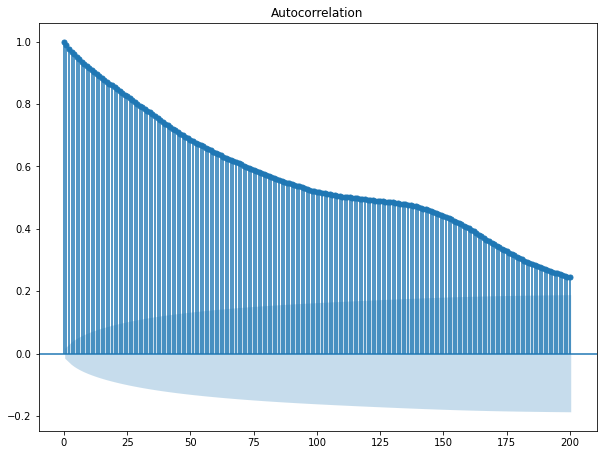

sinus-speed


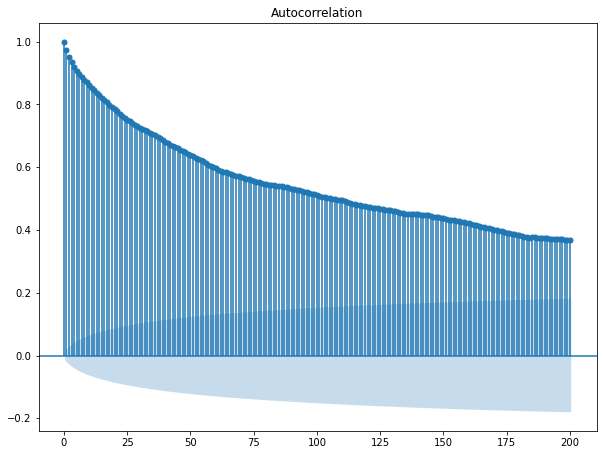

405
cosine-speed


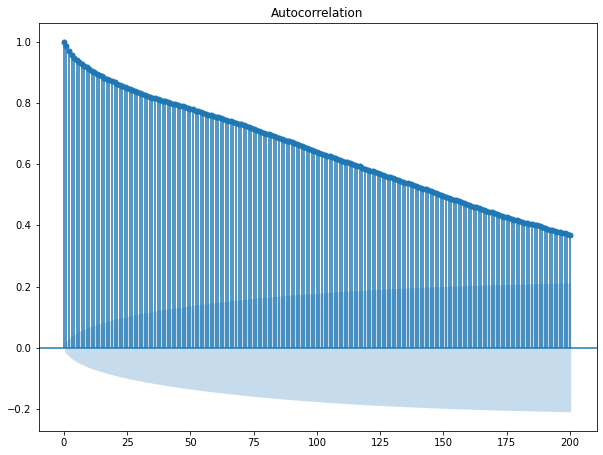

sinus-speed


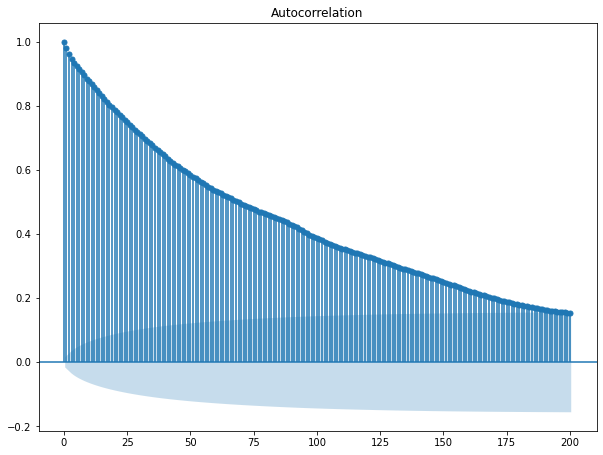

406
cosine-speed


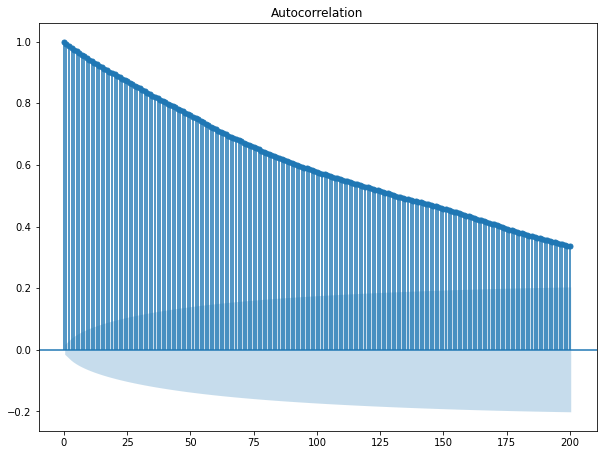

sinus-speed


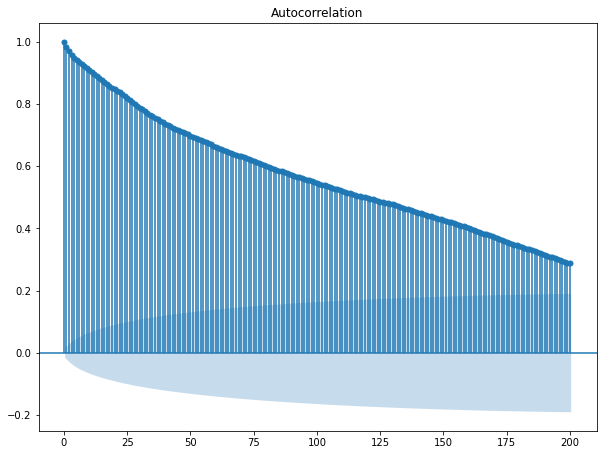

308
cosine-speed


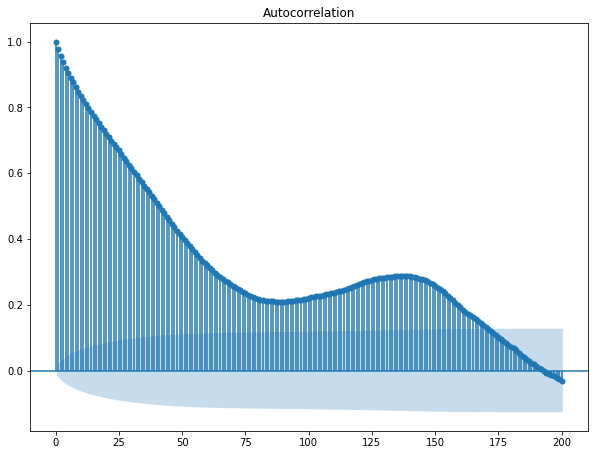

sinus-speed


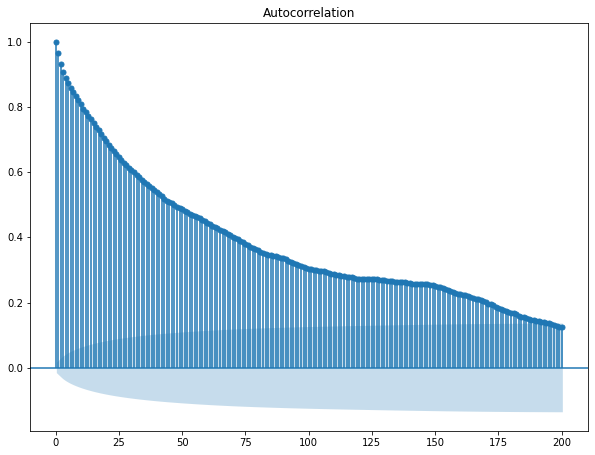

218
cosine-speed


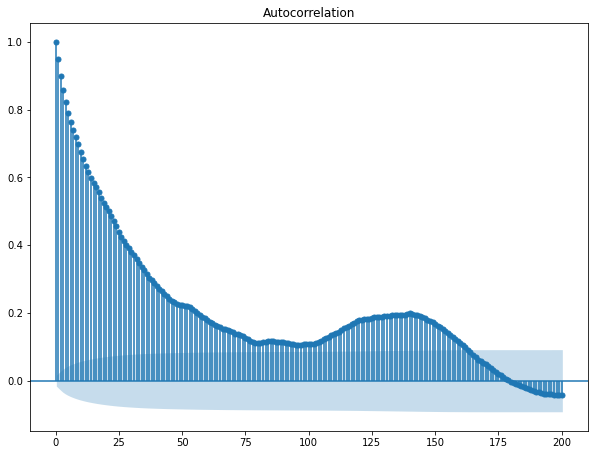

sinus-speed


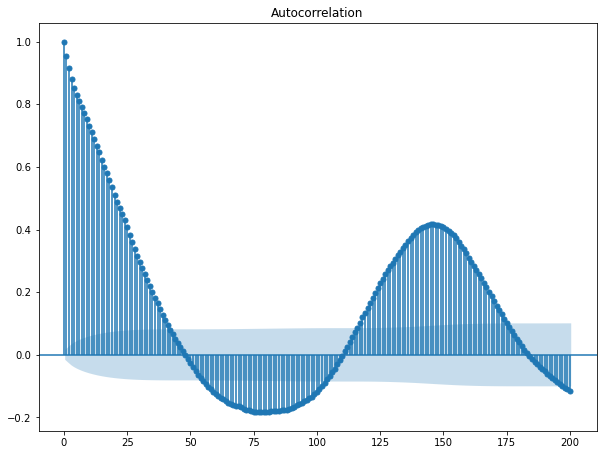

412
cosine-speed


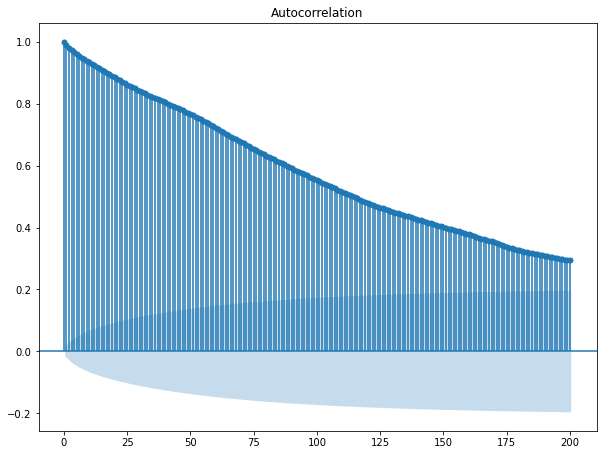

sinus-speed


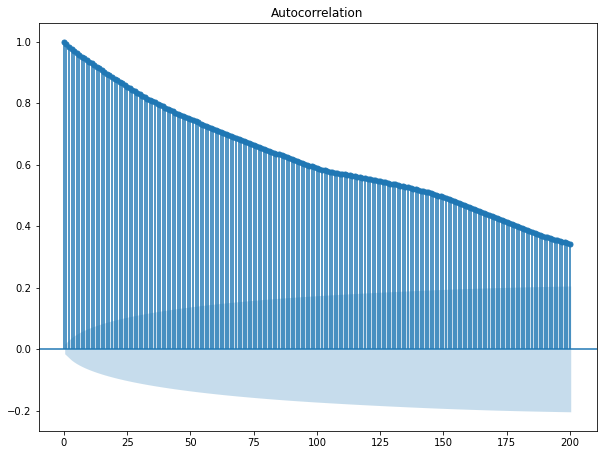

163
cosine-speed


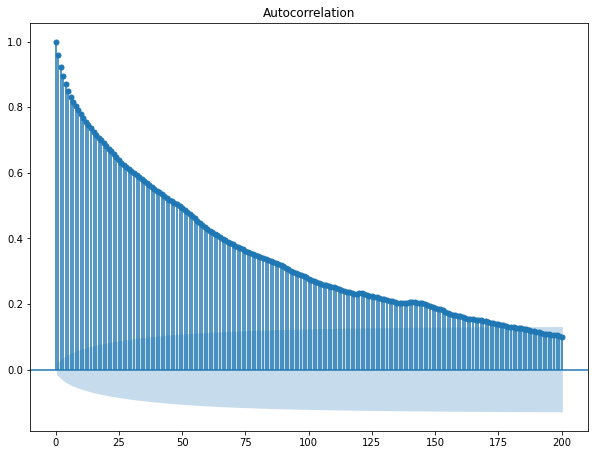

sinus-speed


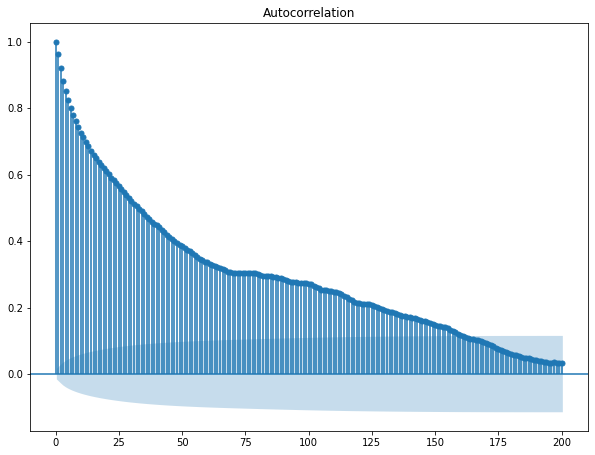

101
cosine-speed


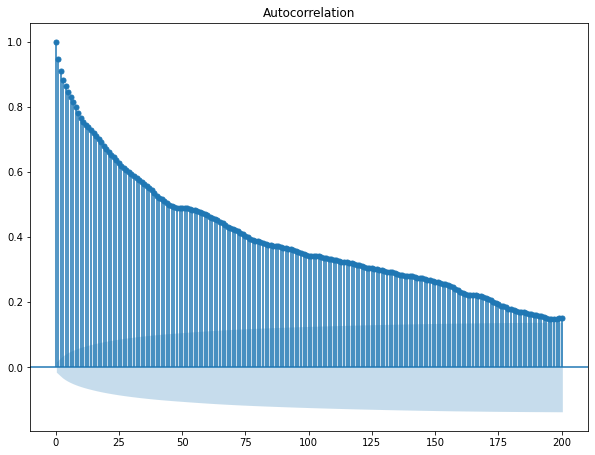

sinus-speed


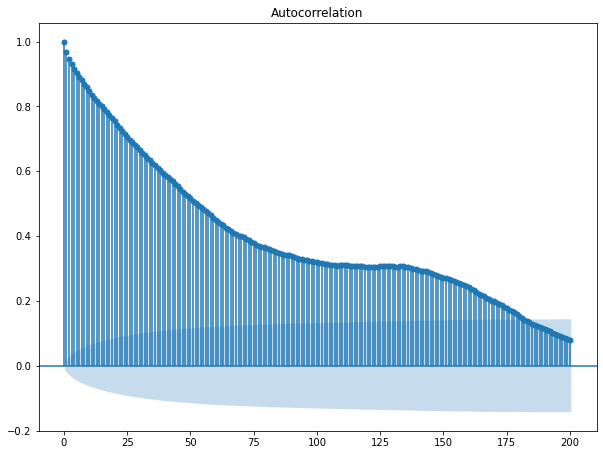

102
cosine-speed


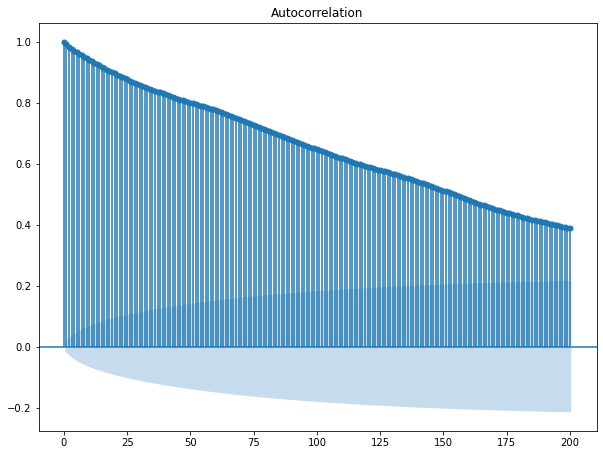

sinus-speed


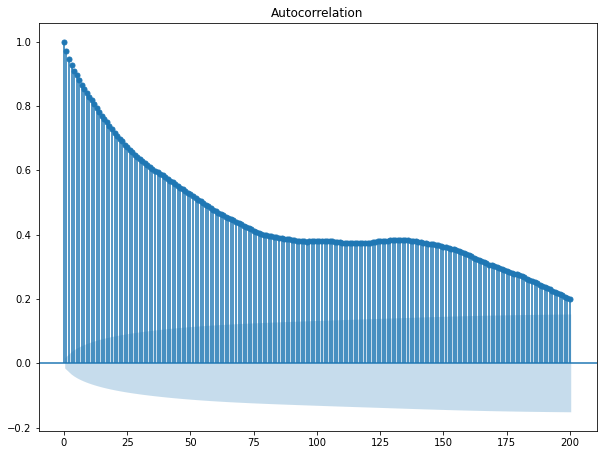

160
cosine-speed


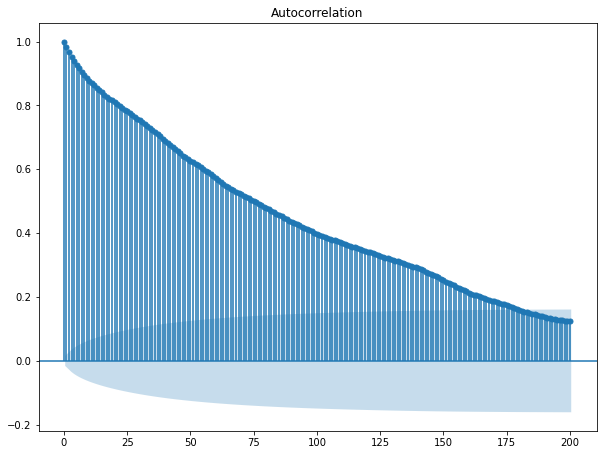

sinus-speed


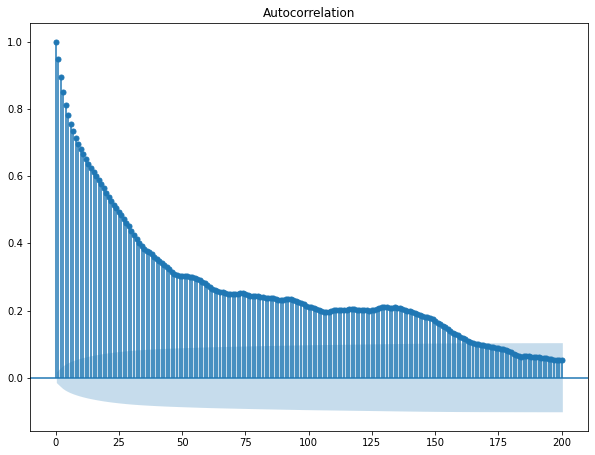

312
cosine-speed


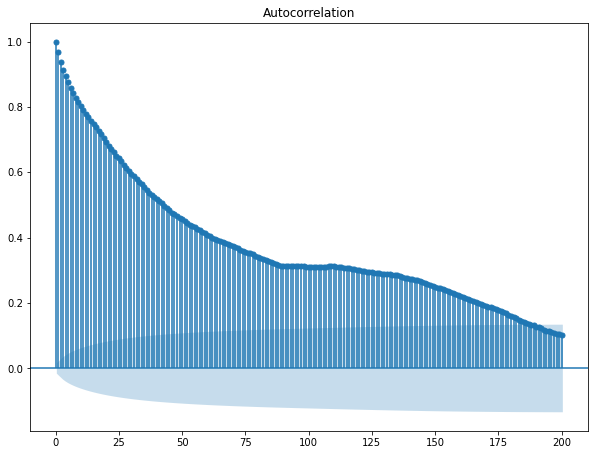

sinus-speed


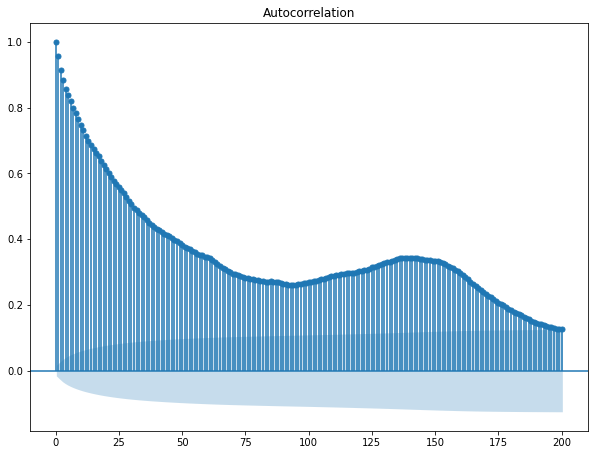

152
cosine-speed


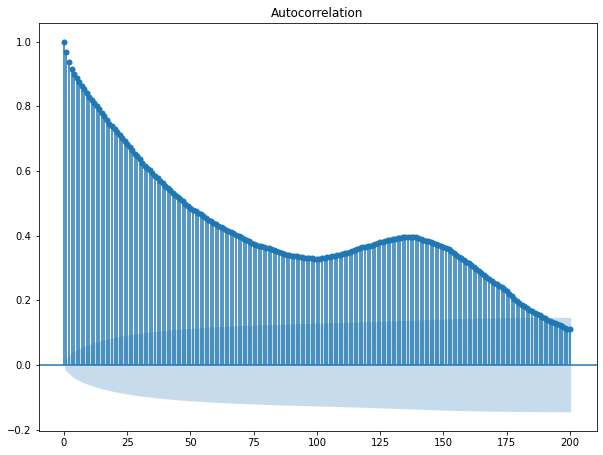

sinus-speed


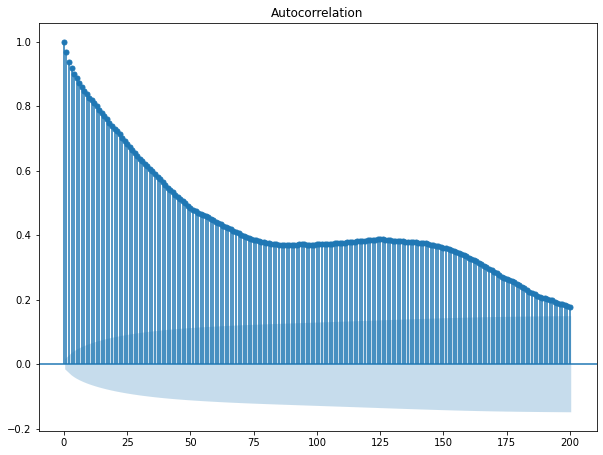

150
cosine-speed


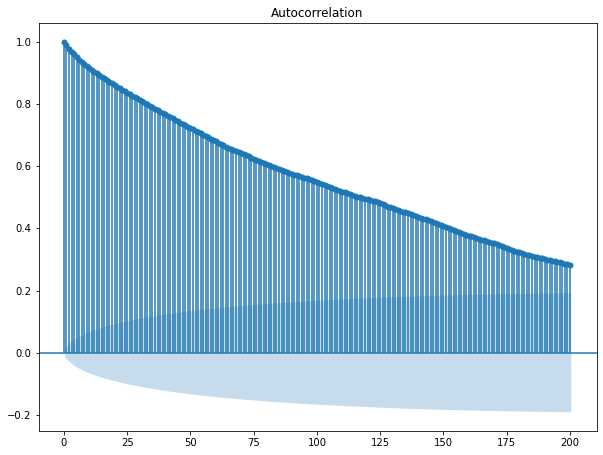

sinus-speed


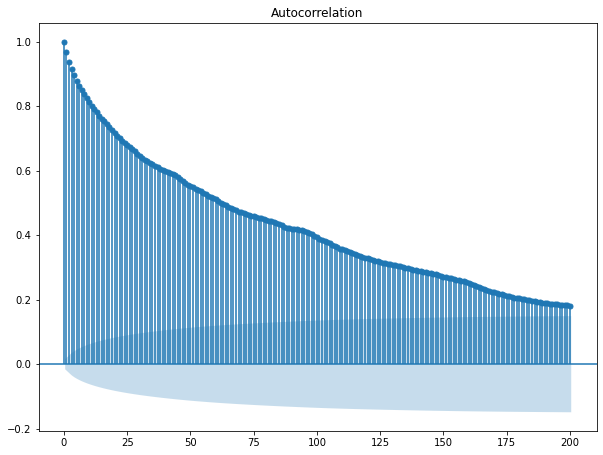

125
cosine-speed


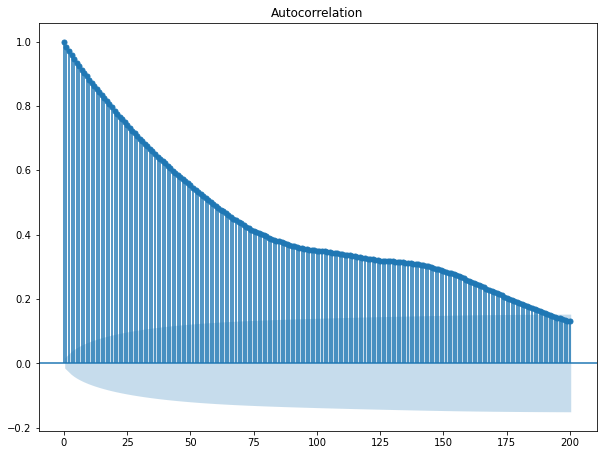

sinus-speed


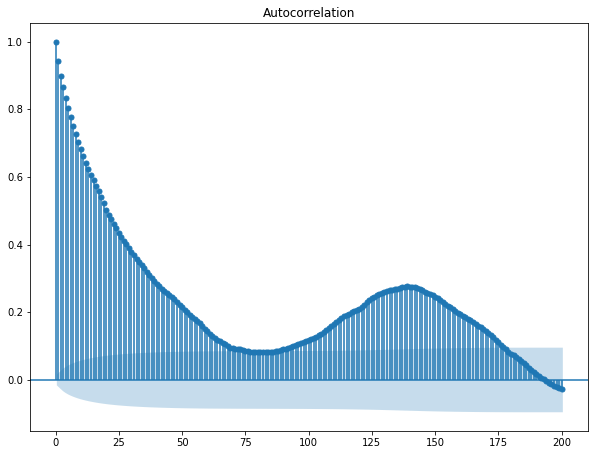

164
cosine-speed


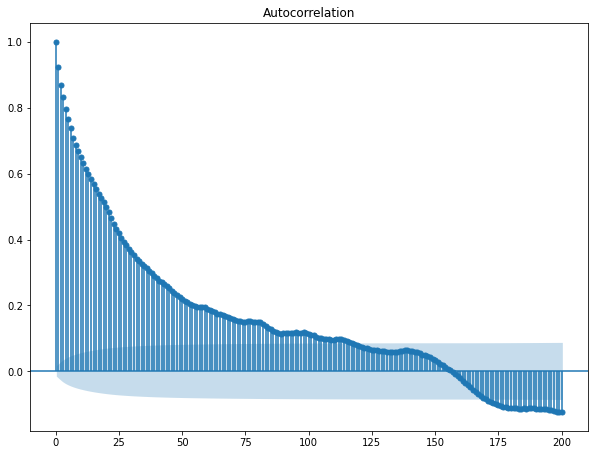

sinus-speed


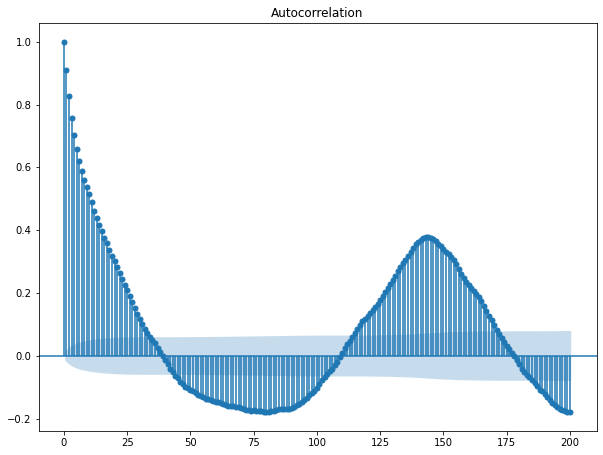

311
cosine-speed


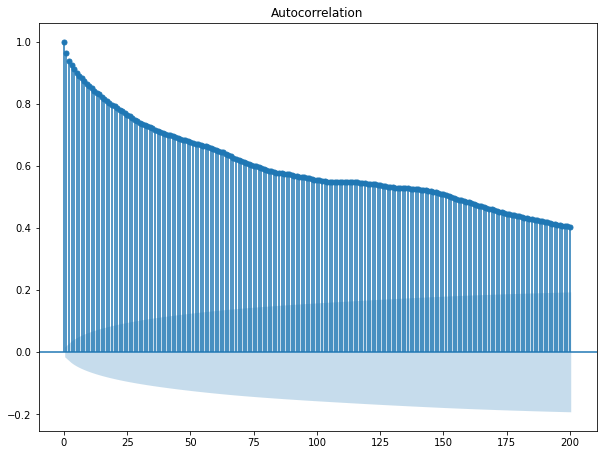

sinus-speed


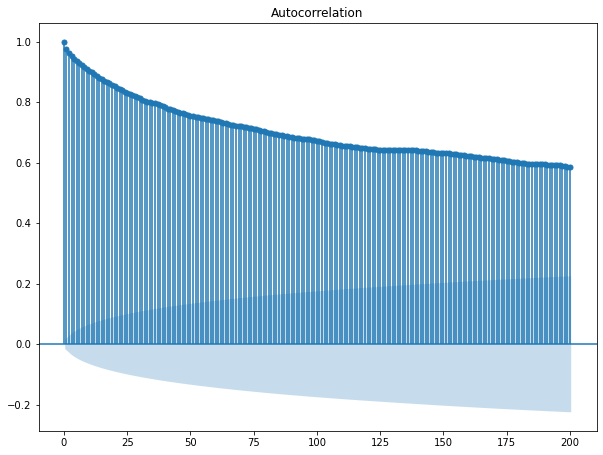

205
cosine-speed


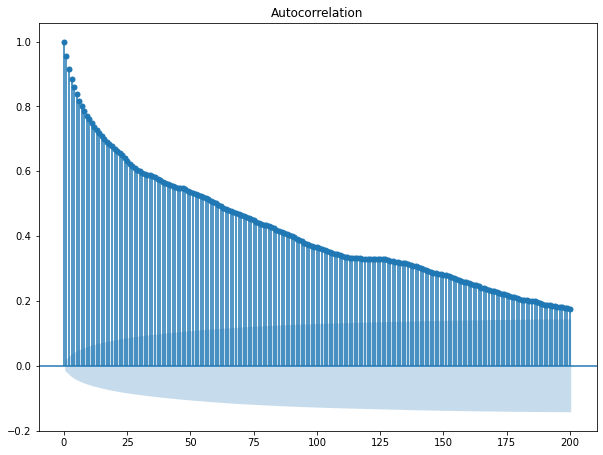

sinus-speed


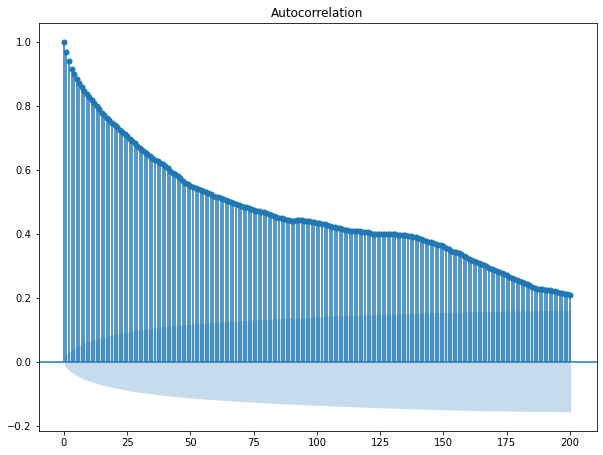

417
cosine-speed


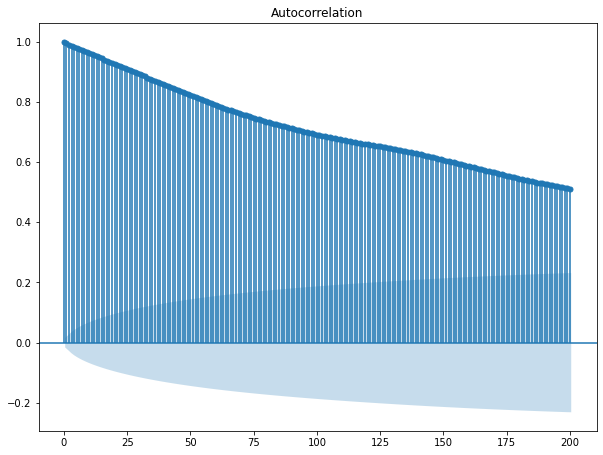

sinus-speed


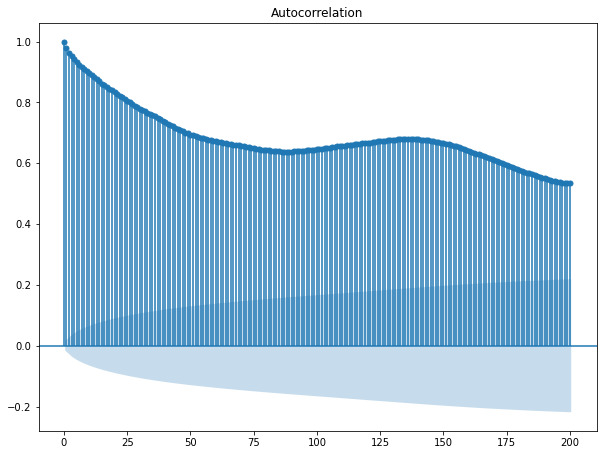

64
cosine-speed


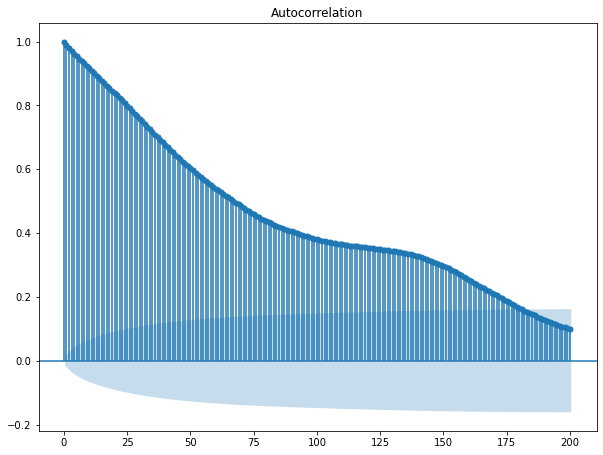

sinus-speed


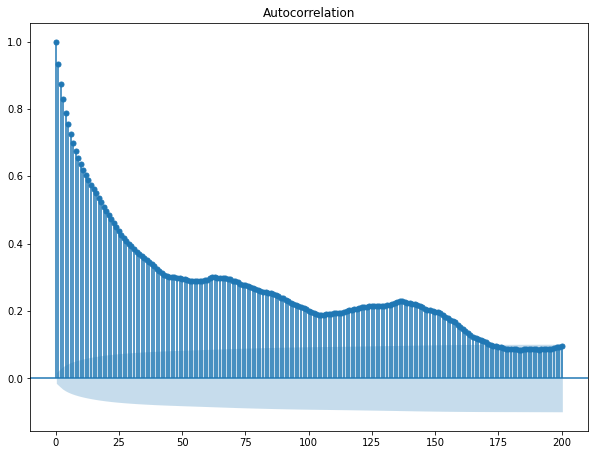

65
cosine-speed


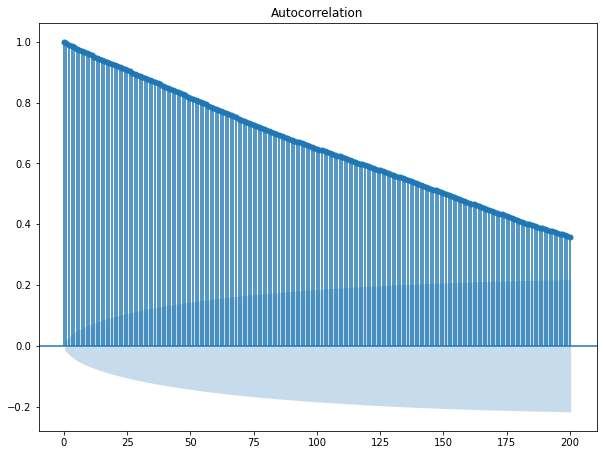

sinus-speed


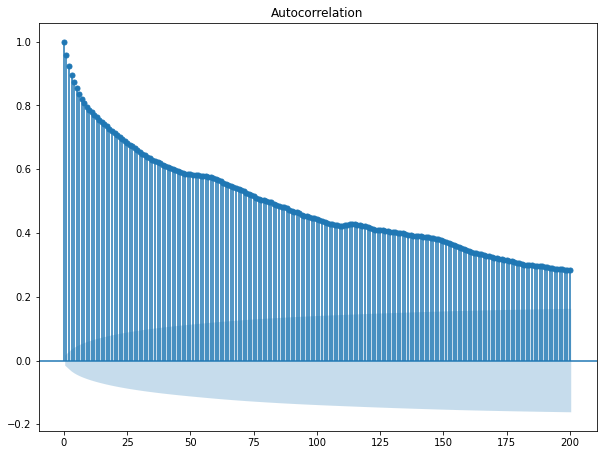

310
cosine-speed


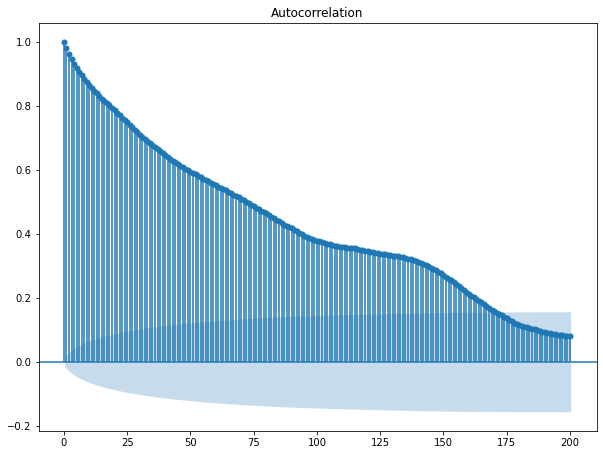

sinus-speed


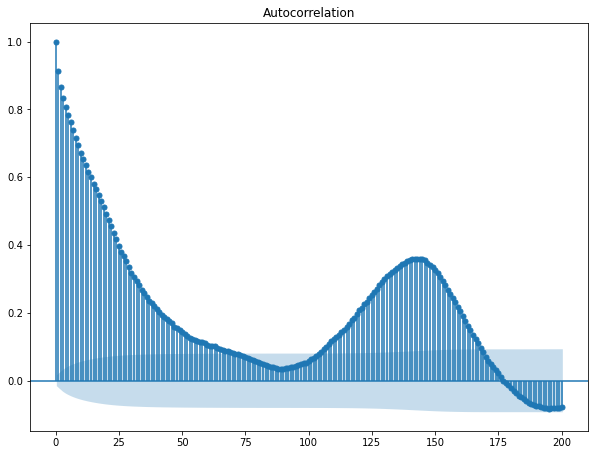

402
cosine-speed


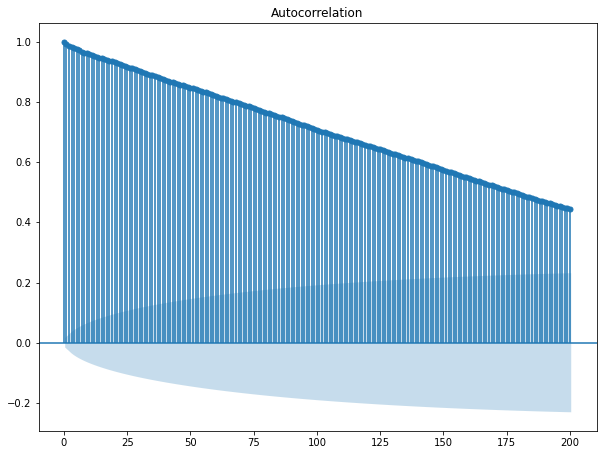

sinus-speed


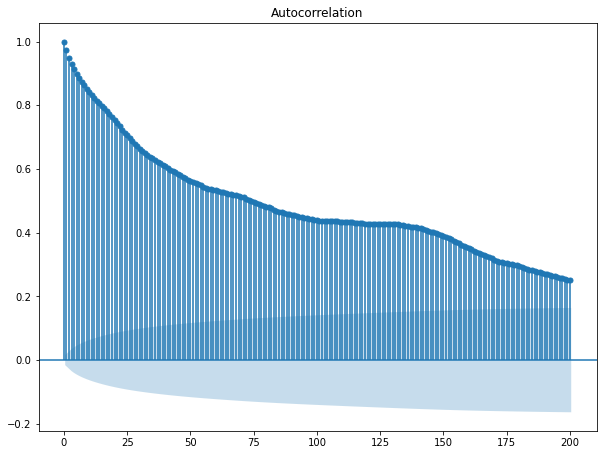

415
cosine-speed


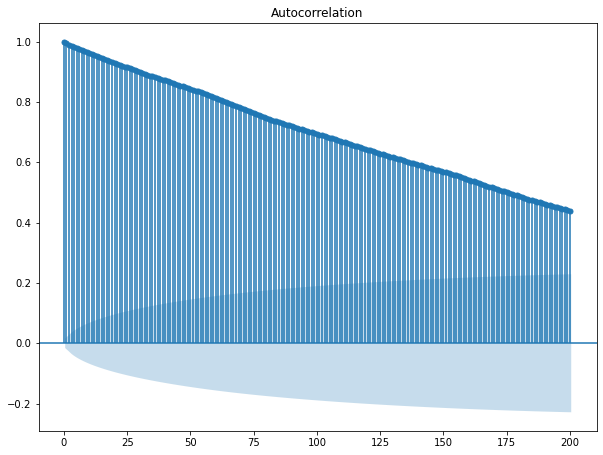

sinus-speed


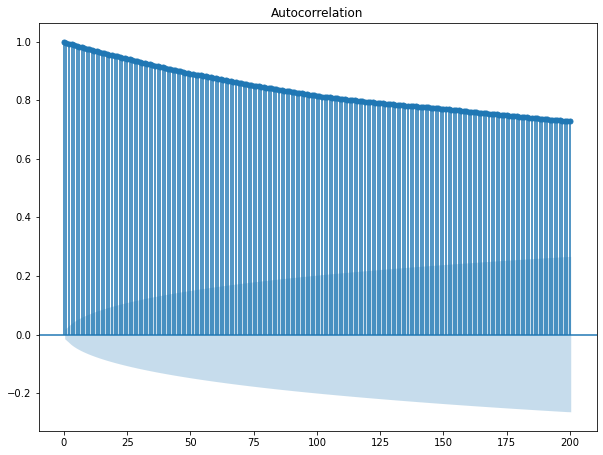

151
cosine-speed


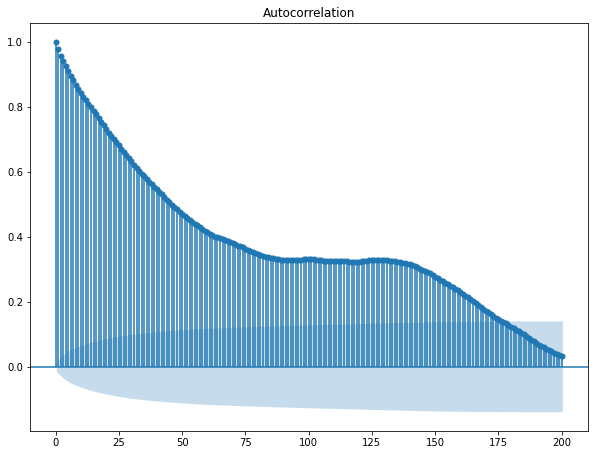

sinus-speed


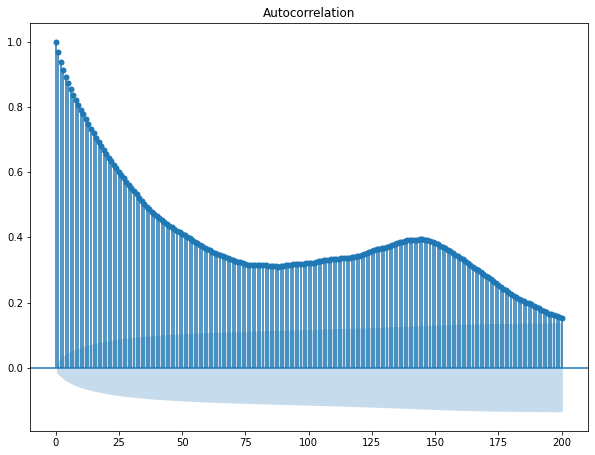

418
cosine-speed


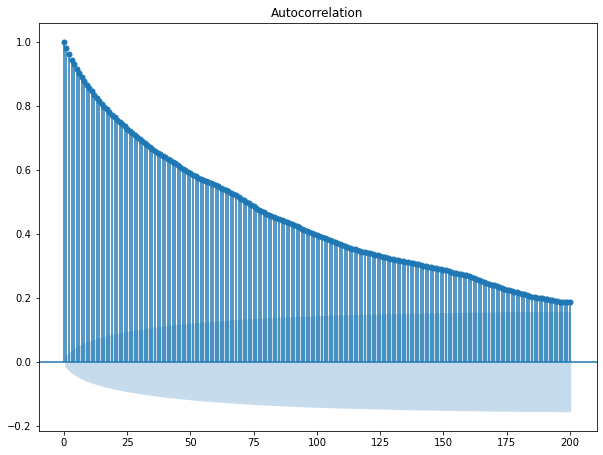

sinus-speed


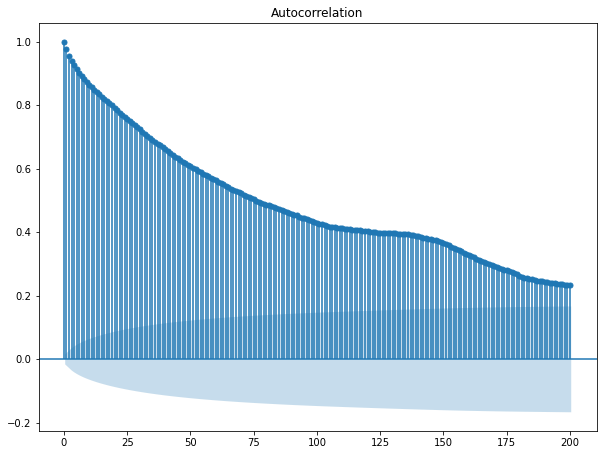

202
cosine-speed


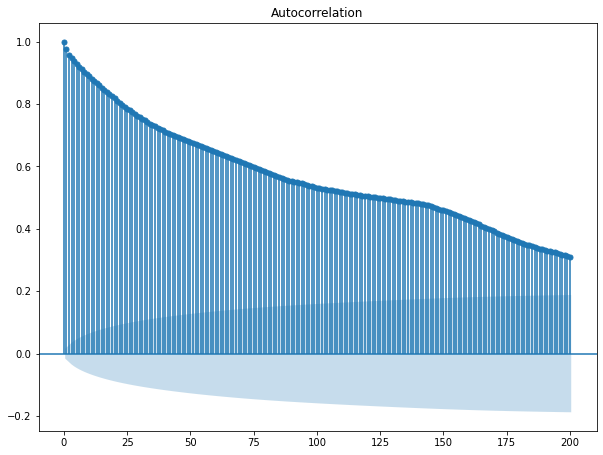

sinus-speed


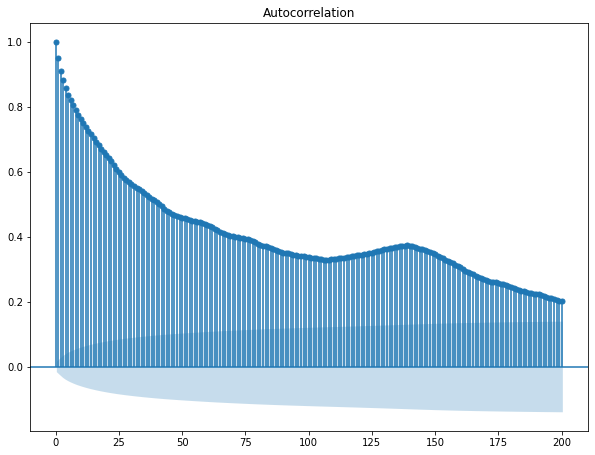

304
cosine-speed


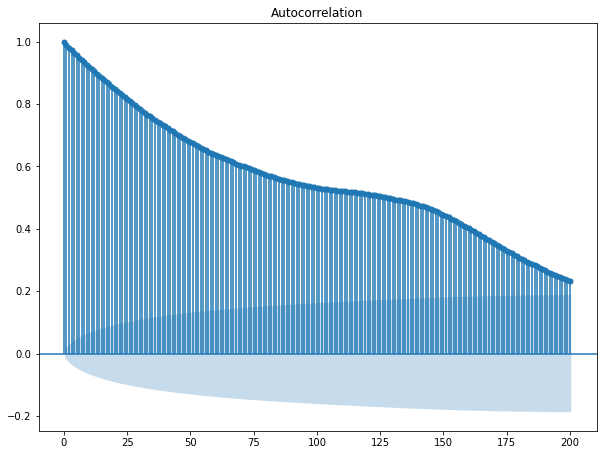

sinus-speed


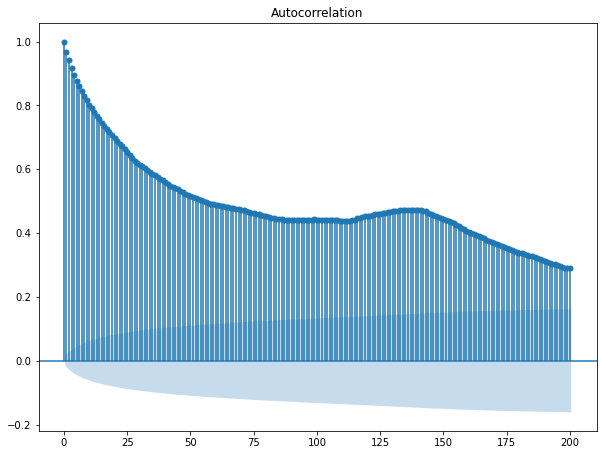

161
cosine-speed


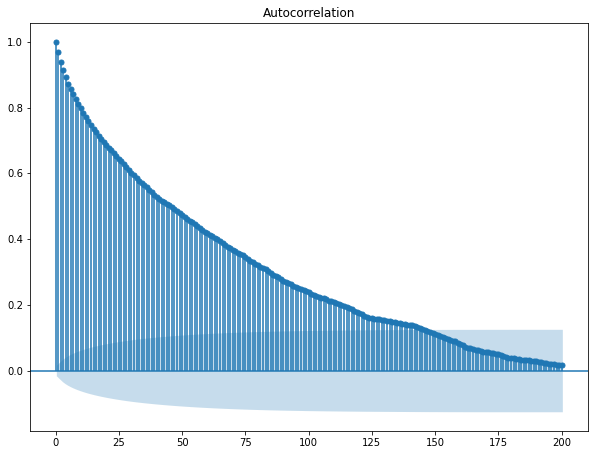

sinus-speed


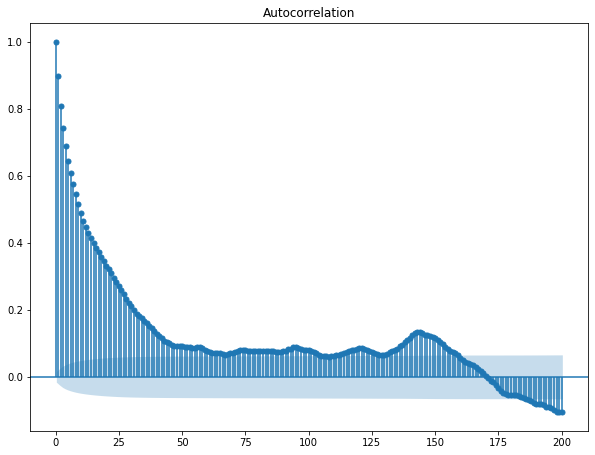

413
cosine-speed


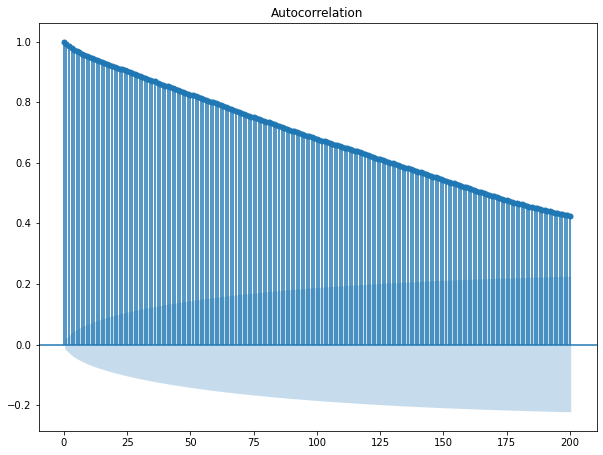

sinus-speed


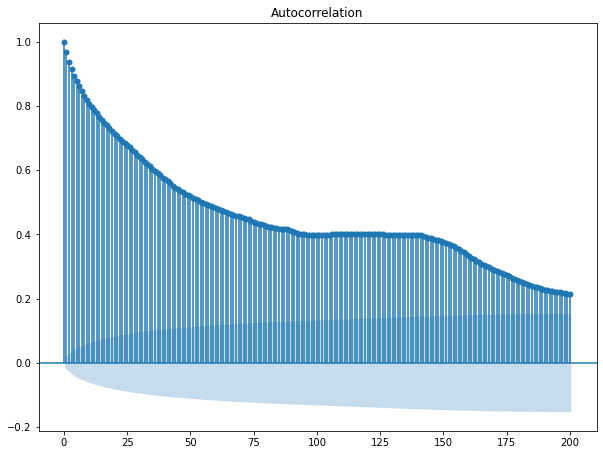

108
cosine-speed


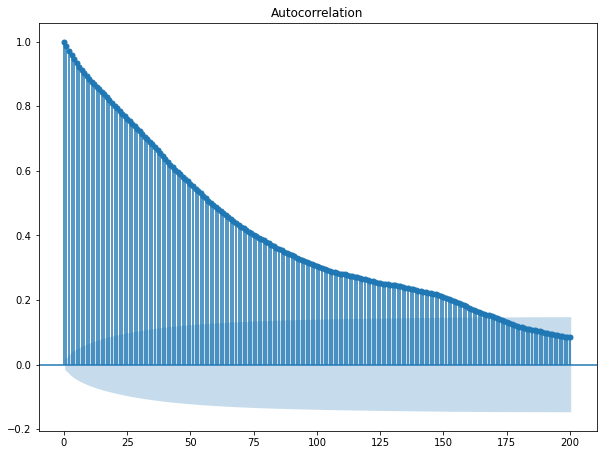

sinus-speed


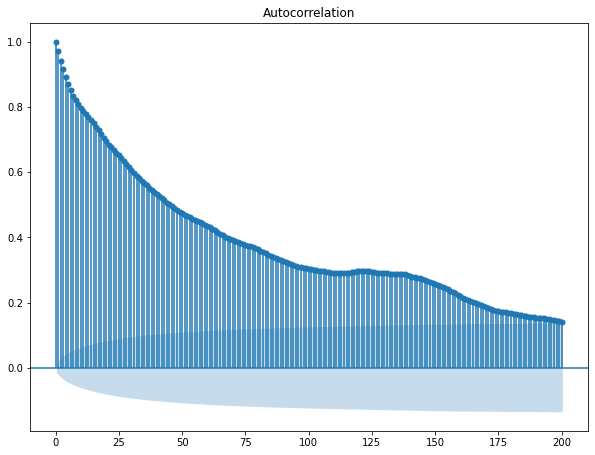

414
cosine-speed


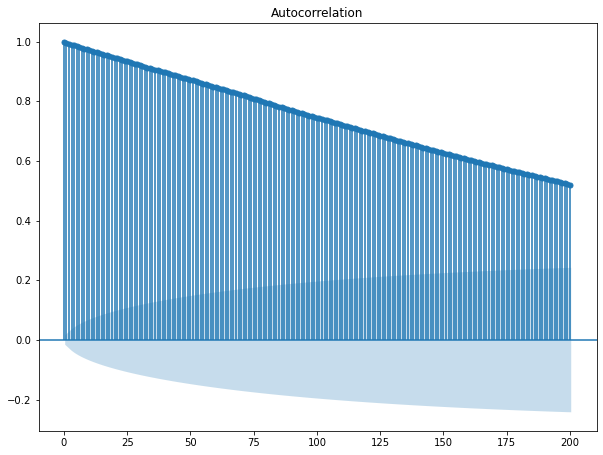

sinus-speed


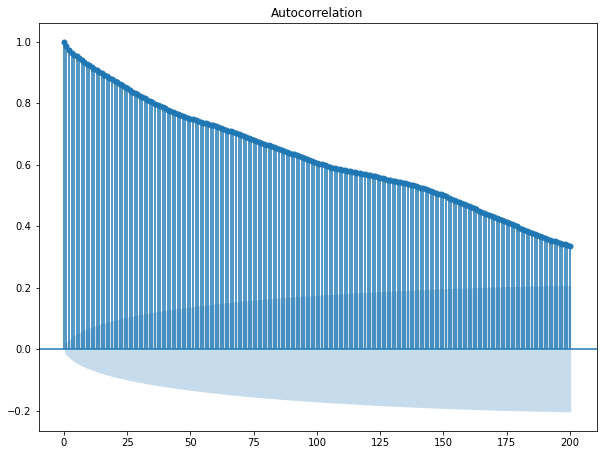

305
cosine-speed


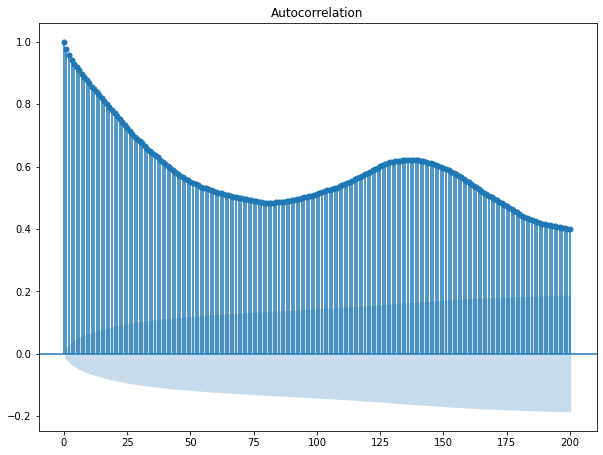

sinus-speed


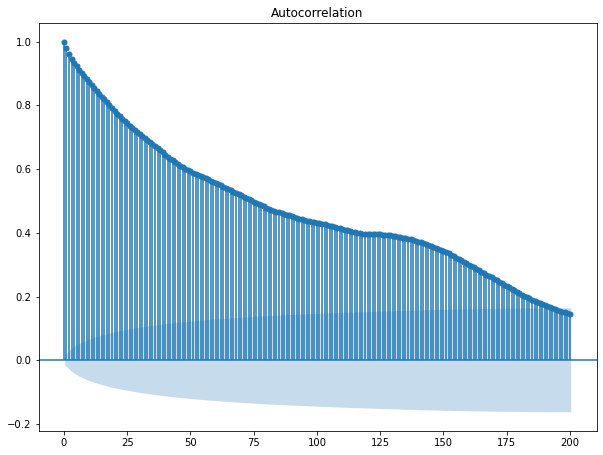

408
cosine-speed


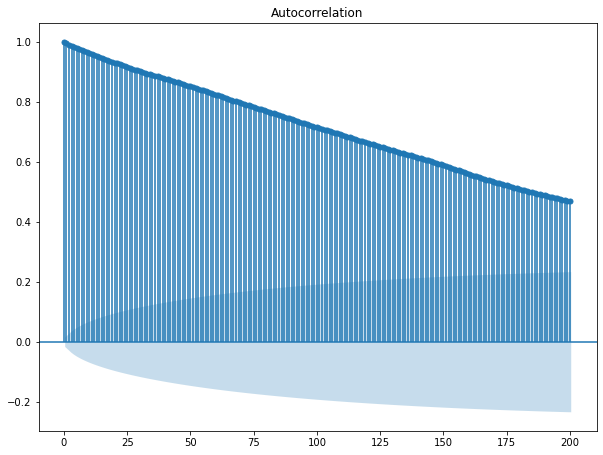

sinus-speed


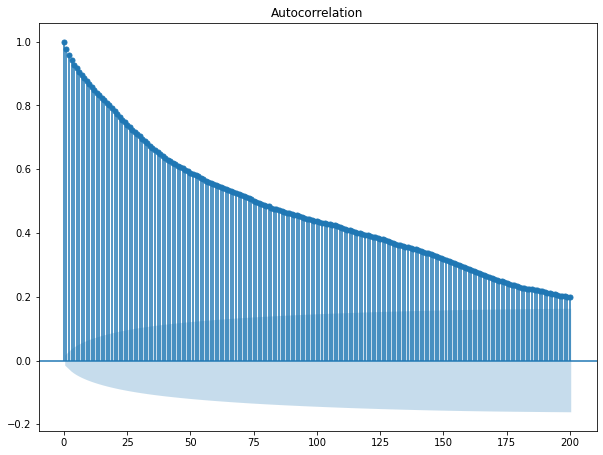

306
cosine-speed


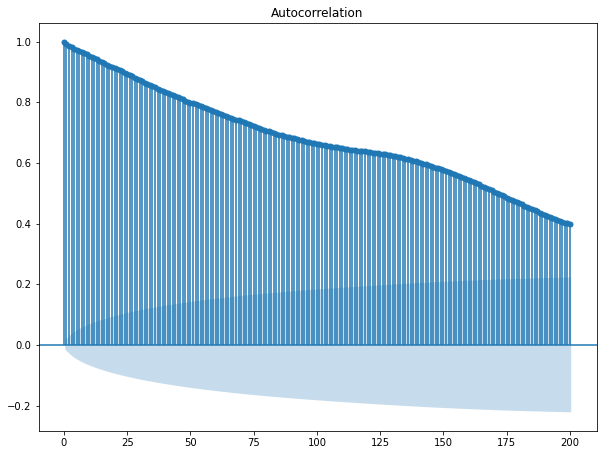

sinus-speed


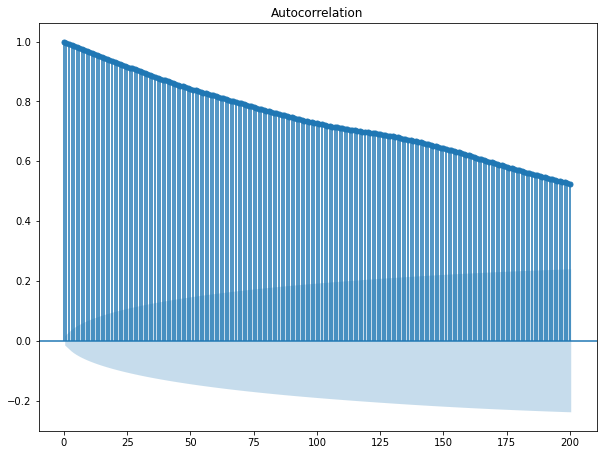

71
cosine-speed


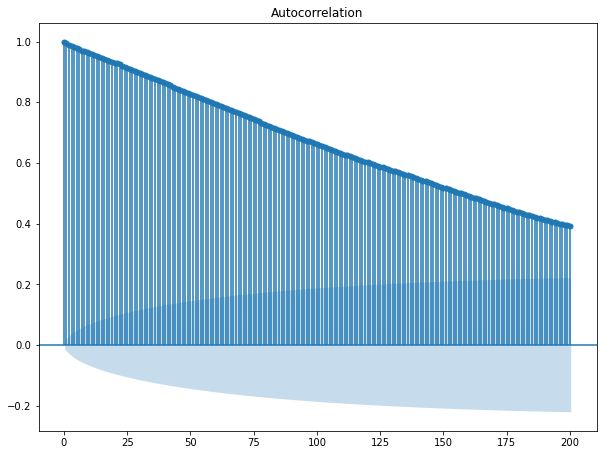

sinus-speed


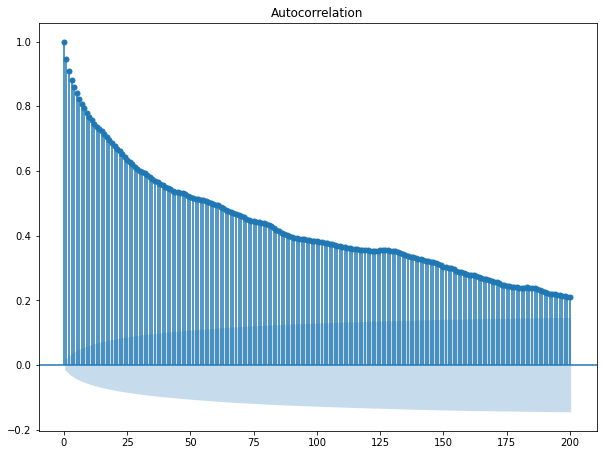

410
cosine-speed


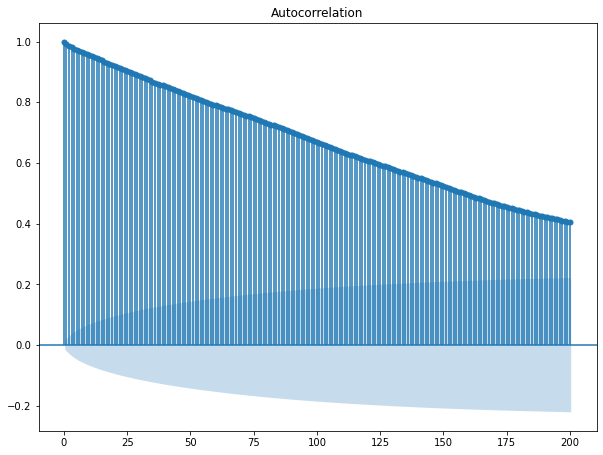

sinus-speed


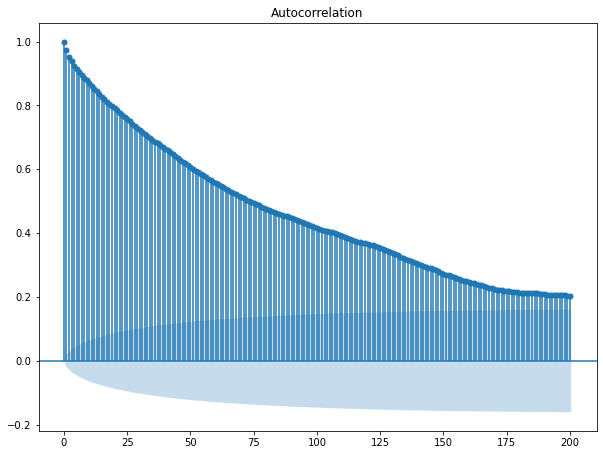

411
cosine-speed


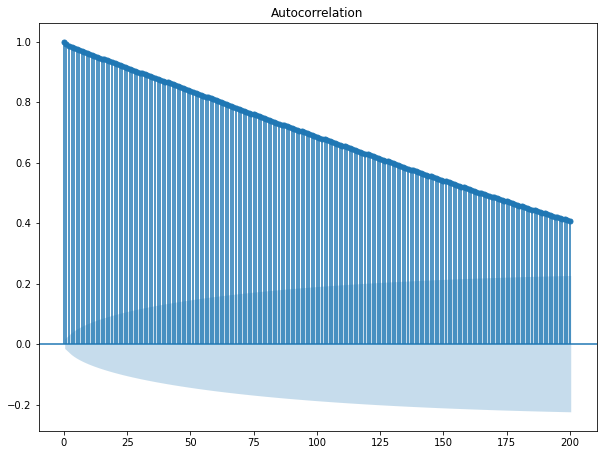

sinus-speed


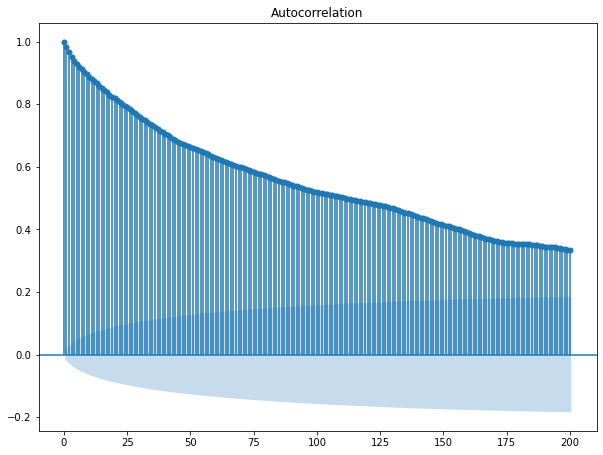

120
cosine-speed


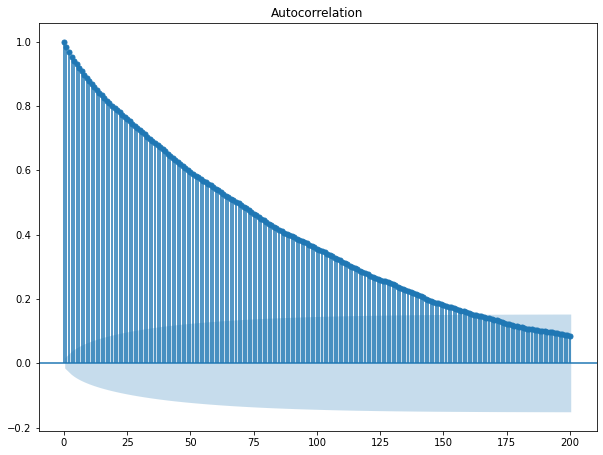

sinus-speed


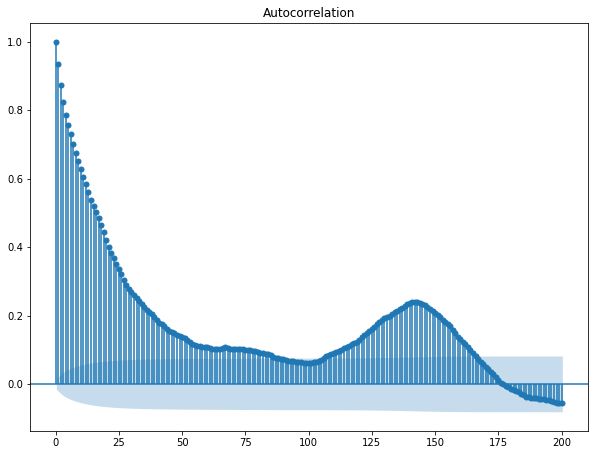

In [163]:
for city_code in final_df['city_code'].unique():
    data = final_df[final_df['city_code'] == city_code]
    data.index = data['date']
    data = data.drop(columns=['date'])
    print(city_code)
    for name, column in data[["cosine-speed","sinus-speed"]].iteritems():
        print(name)
        plot_acf(column,lags=200)
        if city_code == 105:
            plt.savefig('acf_' + name + '.pdf') 
        plt.show()

## Vector Auto Regression (VAR)

### Location-wise

In [90]:
test = 'ssr_chi2test'
maxlag = 6
p_values = []
for city_code in final_df['city_code'].unique():
    data = final_df[final_df['city_code'] == city_code]
    data.index = data['date']
    data = data.drop(columns=['date'])
    test_result = grangercausalitytests(data[["cosine-speed","sinus-speed"]], maxlag=maxlag, verbose=False)
    test_result_1 = grangercausalitytests(data[["sinus-speed","cosine-speed"]], maxlag=maxlag, verbose=False)
    p_values.append(min([min(round(test_result[i+1][0][test][1],4),
                             round(test_result_1[i+1][0][test][1],4)) for i in range(maxlag)]))
all([p_value == 0 for p_value in p_values])

True

In [117]:
for city_code in final_df['city_code'].unique():
    data = final_df[final_df['city_code'] == city_code]
    data.index = data['date']
    data = data.drop(columns=['date'])
    model = VAR(data[["cosine-speed","sinus-speed"]])
    x = model.select_order(maxlags=10)
    print(x.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        4.698       4.699       109.7       4.698
1       -1.333      -1.330      0.2637      -1.332
2       -1.340      -1.335      0.2617      -1.339
3       -1.352      -1.345      0.2588      -1.349
4       -1.358      -1.349      0.2573      -1.355
5       -1.362      -1.351      0.2562      -1.358
6       -1.365      -1.352      0.2554      -1.360
7       -1.368     -1.353*      0.2546      -1.363
8       -1.368      -1.351      0.2545      -1.363
9       -1.370      -1.351      0.2540     -1.364*
10     -1.371*      -1.350     0.2539*      -1.364
--------------------------------------------------
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        4.533       4.534       93.04       4.533
1       -1.127      -1.124     

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        6.274       6.275       530.9       6.275
1      -0.4556     -0.4526      0.6341     -0.4546
2      -0.4575     -0.4525      0.6329     -0.4558
3      -0.4838     -0.4768      0.6164     -0.4815
4      -0.4997     -0.4907      0.6067     -0.4967
5      -0.5048     -0.4938      0.6036     -0.5012
6      -0.5096     -0.4966      0.6007     -0.5053
7      -0.5119    -0.4969*      0.5993     -0.5070
8      -0.5119     -0.4949      0.5994     -0.5063
9      -0.5132     -0.4942      0.5986     -0.5069
10    -0.5139*     -0.4929     0.5981*    -0.5070*
--------------------------------------------------
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        5.225       5.226       185.9       5.226
1       -1.755      -1.752     

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        5.987       5.988       398.0       5.987
1      -0.3320     -0.3290      0.7175     -0.3310
2      -0.3382     -0.3332      0.7130     -0.3366
3      -0.3524     -0.3454      0.7030     -0.3501
4      -0.3542     -0.3452      0.7018     -0.3512
5      -0.3569     -0.3459      0.6998     -0.3533
6      -0.3583     -0.3453      0.6989     -0.3540
7      -0.3614    -0.3464*      0.6967    -0.3564*
8      -0.3619     -0.3449      0.6964     -0.3563
9      -0.3622     -0.3431      0.6962     -0.3559
10    -0.3627*     -0.3417     0.6958*     -0.3558
--------------------------------------------------
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        3.962       3.963       52.55       3.962
1       -1.777      -1.774     

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        4.394       4.395       81.00       4.395
1       -1.447      -1.444      0.2353      -1.446
2       -1.447      -1.442      0.2353      -1.445
3       -1.461      -1.454      0.2320      -1.459
4       -1.466     -1.457*      0.2309      -1.463
5       -1.466      -1.455      0.2309      -1.462
6       -1.468      -1.455      0.2305      -1.463
7       -1.469      -1.454      0.2303     -1.464*
8       -1.469      -1.452      0.2303      -1.463
9      -1.469*      -1.450     0.2302*      -1.463
10      -1.469      -1.448      0.2302      -1.462
--------------------------------------------------
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        4.916       4.917       136.5       4.917
1       -1.355      -1.352     

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        5.724       5.725       306.0       5.724
1      -0.9080     -0.9050      0.4033     -0.9070
2      -0.9235     -0.9185      0.3971     -0.9219
3      -0.9472     -0.9402      0.3878     -0.9448
4      -0.9528     -0.9438      0.3856     -0.9498
5      -0.9563    -0.9453*      0.3843     -0.9527
6      -0.9575     -0.9444      0.3839     -0.9531
7      -0.9583     -0.9433      0.3836     -0.9533
8      -0.9611     -0.9441      0.3825    -0.9555*
9      -0.9610     -0.9420      0.3825     -0.9547
10    -0.9616*     -0.9406     0.3823*     -0.9547
--------------------------------------------------
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        6.723       6.724       831.4       6.723
1      -0.2734     -0.2704     

### Single entity

In [164]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', maxlag=6):    

    df = pd.DataFrame([[np.min([round(grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)[i+1][0][test][1],4) 
            for i in range(maxlag)]) for r in data.columns] for c in data.columns])
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

causation_matrix = grangers_causation_matrix(final_df_grouped, variables = final_df_grouped.columns)

In [174]:
np.mean([sum(causation_matrix.loc[:,i] == 0) for i in causation_matrix.columns])

42.229166666666664

In [175]:
np.mean([sum(causation_matrix.loc[i,:] == 0) for i in causation_matrix.index])

42.229166666666664

In [168]:
causation_matrix

cosine-speed_105_x  sinus-speed_105_x  cosine-speed_314_x  \
cosine-speed_105_y              1.0000             0.0000              0.2121   
sinus-speed_105_y               0.0000             1.0000              0.0000   
cosine-speed_314_y              0.0032             0.0015              1.0000   
sinus-speed_314_y               0.0025             0.0000              0.0000   
cosine-speed_123_y              0.0000             0.0000              0.0915   
...                                ...                ...                 ...   
sinus-speed_410_y               0.7222             0.0000              0.0097   
cosine-speed_411_y              0.0000             0.3077              0.0026   
sinus-speed_411_y               0.0019             0.0000              0.0000   
cosine-speed_120_y              0.0000             0.0132              0.0000   
sinus-speed_120_y               0.0002             0.0098              0.0005   

                    sinus-speed_314_x  cosine-speed_123_x  sinus-speed_123_x  \
cosine-speed_105_y             0.0000              0.0000             0.0000   
sinus-speed_105_y              0.0000              0.0193             0.0000   
cosine-speed_314_y             0.0000              0.0000             0.1736   
sinus-speed_314_y              1.0000              0.1044             0.0084   
cosine-speed_123_y             0.0000              1.0000             0.0000   
...                               ...                 ...                ...   
sinus-speed_410_y              0.0328              0.4562             0.0067   
cosine-speed_411_y             0.1359              0.0000             0.6226   
sinus-speed_411_y              0.0000              0.0005             0.0000   
cosine-speed_120_y             0.0270              0.0000             0.0204   
sinus-speed_120_y              0.0000              0.0000             0.0007   

                    cosine-speed_217_x  sinus-speed_217_x  cosine-speed_211_x  \
cosine-speed_105_y              0.0000             0.0000              0.0000   
sinus-speed_105_y               0.1487             0.0000              0.0718   
cosine-speed_314_y              0.0000             0.0003              0.0000   
sinus-speed_314_y               0.4065             0.0000              0.0297   
cosine-speed_123_y              0.0000             0.0000              0.0000   
...                                ...                ...                 ...   
sinus-speed_410_y               0.2142             0.0234              0.2558   
cosine-speed_411_y              0.0000             0.0005              0.0000   
sinus-speed_411_y               0.0245             0.0000              0.1063   
cosine-speed_120_y              0.0001             0.0640              0.0000   
sinus-speed_120_y               0.0016             0.0000              0.0000   

                    sinus-speed_211_x  ...  cosine-speed_306_x  \
cosine-speed_105_y             0.0012  ...              0.0000   
sinus-speed_105_y              0.0000  ...              0.0979   
cosine-speed_314_y             0.0000  ...              0.0000   
sinus-speed_314_y              0.0000  ...              0.0048   
cosine-speed_123_y             0.1383  ...              0.0000   
...                               ...  ...                 ...   
sinus-speed_410_y              0.0000  ...              0.0777   
cosine-speed_411_y             0.0792  ...              0.0000   
sinus-speed_411_y              0.0000  ...              0.0052   
cosine-speed_120_y             0.0784  ...              0.0040   
sinus-speed_120_y              0.0079  ...              0.0000   

                    sinus-speed_306_x  cosine-speed_71_x  sinus-speed_71_x  \
cosine-speed_105_y             0.0000             0.0000            0.0000   
sinus-speed_105_y              0.0207             0.3835            0.0000   
cosine-speed_314_y             0.0253             0.0000            0.0001   
sinus-sp

In [140]:
model = VAR(final_df_grouped)
x = model.select_order(maxlags=10)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

# Short term prediction

In [134]:
def prediction_to_speed_direction(prediction):
    return np.array([[np.sqrt(pred[0]**2 + pred[1]**2), (np.arctan(pred[1]/pred[0]) + theta_bar) * 180 / math.pi - 90 
                      if (np.arctan(pred[1]/pred[0]) + theta_bar) * 180 / math.pi - 90 > 0 
                      else (np.arctan(pred[1]/pred[0]) + theta_bar) * 180 / math.pi + 270] for pred in prediction])

def direction_error_metric(valid,prediction):
    valid_direction = np.arctan(valid[:,1]/valid[:,0])
    prediction_direction = np.arctan(prediction[:,1]/prediction[:,0])
    return np.array([np.abs(valid_angle-prediction_angle) if np.abs(valid_angle-prediction_angle) < math.pi
                     else 2*math.pi - np.abs(valid_angle-prediction_angle)
                     for valid_angle, prediction_angle in zip(valid_direction,prediction_direction)])

def var_short_term(slice_split,final_df,order,list_city_codes=None):
    distance_error = []
    speed_error = []
    direction_error = []
    for city_code in final_df['city_code'].unique():
        data = final_df[final_df['city_code'] == city_code]
        data.index = data['date']
        data = data.drop(columns=['date'])
        train = data[["cosine-speed","sinus-speed"]][slice_split[0]]
        valid = data[["cosine-speed","sinus-speed"]][slice_split[1]]
        model = VAR(train)
        model_fit = model.fit(order)
        endogs = [model_fit.endog] + [np.vstack([model_fit.endog,y]) for y in valid.values[:-1]]
        prediction = np.vstack([model_fit.forecast(endog, steps=1) for endog in endogs])
        distance_error.append(np.sqrt(np.sum((prediction - valid.values)**2, axis=1)))
        speed_error.append(np.abs(np.sqrt(np.sum(prediction**2,axis=1))-np.sqrt(np.sum(valid.values**2,axis=1))))
        direction_error.append(direction_error_metric(valid.values,prediction))
    df_error = pd.DataFrame([[np.mean(np.mean(distance_error,axis=0)),
                             np.mean(np.mean(speed_error,axis=0)),
                             np.mean(np.mean(direction_error,axis=0))]],
                            columns=["L2 distance", "MAE speed", "MAE direction"],
                            index=["One VAR("+str(order)+") per location"])
    return df_error, prediction
    

def var_short_term_grouped(slice_split,data,order,list_city_codes):
    l2_error = []
    speed_error = []
    direction_error = []
    train = data[slice_split[0]]
    valid = data[slice_split[1]]
    model = VAR(train)
    model_fit = model.fit(order)
    endogs = [model_fit.endog] + [np.vstack([model_fit.endog,y]) for y in valid.values[:-1]]
    prediction = np.vstack([model_fit.forecast(endog, steps=1) for endog in endogs])
    pred = pd.DataFrame(prediction,columns=data.columns)
    l2_error = [np.sqrt(np.sum(np.array([pred["cosine-speed"+"_"+str(city_code)].values  - valid["cosine-speed"+"_"+str(city_code)].values ,
                                                   pred["sinus-speed"+"_"+str(city_code)].values  - valid["sinus-speed"+"_"+str(city_code)].values])**2,axis=0)) 
                            for city_code in list_city_codes]
    speed_error = [np.abs(np.subtract(np.sqrt(pred["cosine-speed"+"_"+str(city_code)].values**2  + pred["sinus-speed"+"_"+str(city_code)].values**2) ,
                            np.sqrt(valid["cosine-speed"+"_"+str(city_code)].values**2  + valid["sinus-speed"+"_"+str(city_code)].values**2))) 
                            for city_code in list_city_codes]
    direction_error = [direction_error_metric(valid[["cosine-speed"+"_"+str(city_code),"sinus-speed"+"_"+str(city_code)]].values,
                                              pred[["cosine-speed"+"_"+str(city_code),"sinus-speed"+"_"+str(city_code)]].values) for city_code in list_city_codes]
    
    df_error = pd.DataFrame([[np.mean(np.mean(l2_error,axis=0)),
                             np.mean(np.mean(speed_error,axis=0)),
                             np.mean(np.mean(direction_error,axis=0))]],
                            columns=["L2 distance", "MAE speed", "MAE direction"],
                            index=["Single VAR("+str(order)+") for all locations"])
    return df_error, prediction

def short_term_last(slice_split,final_df,order=None,list_city_codes=None):
    distance_error = []
    speed_error = []
    direction_error = []
    for city_code in final_df['city_code'].unique():
        data = final_df[final_df['city_code'] == city_code]
        data.index = data['date']
        data = data.drop(columns=['date'])
        train = data[["cosine-speed","sinus-speed"]][slice_split[0]]
        valid = data[["cosine-speed","sinus-speed"]][slice_split[1]]
        prediction = np.array([train.values[-1]] + [y for y in valid.values[:-1]])
        distance_error.append(np.sqrt(np.sum((prediction - valid.values)**2, axis=1)))
        speed_error.append(np.abs(np.sqrt(np.sum(prediction**2,axis=1))-np.sqrt(np.sum(valid.values**2,axis=1))))
        direction_error.append(direction_error_metric(valid.values,prediction))
    df_error = pd.DataFrame([[np.mean(np.mean(distance_error,axis=0)),
                             np.mean(np.mean(speed_error,axis=0)),
                             np.mean(np.mean(direction_error,axis=0))]],
                            columns=["L2 distance", "MAE speed", "MAE direction"],
                            index=["Last baseline"])
    return df_error, prediction

def arma_short_term(slice_split,final_df,order,list_city_codes=None):
    distance_error = []
    speed_error = []
    direction_error = []
    for city_code in final_df['city_code'].unique():
        data = final_df[final_df['city_code'] == city_code]
        data.index = data['date']
        data = data.drop(columns=['date'])
        train = data[["cosine-speed","sinus-speed"]][slice_split[0]]
        valid = data[["cosine-speed","sinus-speed"]][slice_split[1]]
        prediction = []
        for column in ["cosine-speed","sinus-speed"]:
            model = ARIMA(train[column], order=(1,0,order))
            model_fit = model.fit()
            predictions = []
            for y in valid[column].values:
                predictions.append(model_fit.forecast(1).values[0])
                model_fit = model_fit.append([y], refit=False)
            prediction.append(np.array([predictions]).T)
        prediction = np.hstack(prediction)
        distance_error.append(np.sqrt(np.sum((prediction - valid.values)**2, axis=1)))
        speed_error.append(np.abs(np.sqrt(np.sum(prediction**2,axis=1))-np.sqrt(np.sum(valid.values**2,axis=1))))
        direction_error.append(direction_error_metric(valid.values,prediction))
    df_error = pd.DataFrame([[np.mean(np.mean(distance_error,axis=0)),
                             np.mean(np.mean(speed_error,axis=0)),
                             np.mean(np.mean(direction_error,axis=0))]],
                            columns=["L2 distance", "MAE speed", "MAE direction"],
                            index=["One ARMA(1,0,"+str(order)+") per column and per location"])
    return df_error, prediction

def pipeline_short_term(function,split_ratio,final_df,order=None,list_city_codes=None):
    slices_split = [(slice(int(split_ratio*len(final_df_grouped))), slice(int(split_ratio*len(final_df_grouped)),len(final_df_grouped))),
                    (slice(int((1-split_ratio)*len(final_df_grouped))+1,len(final_df_grouped)), slice(int((1-split_ratio)*len(final_df_grouped))+1))]
    
    dfs_errors = []
    predictions = []
    for slice_split in slices_split:
        results = function(slice_split,final_df,order,list_city_codes)
        dfs_errors.append(results[0])
        predictions.append(results[1])
    return sum(dfs_errors)/len(dfs_errors), predictions

def compute_error_bigvar(order):
    
    dfs_errors = []
    predictions = []
    
    for nbr_split, slice_split in enumerate([slice(int(0.2*len(final_df_grouped))+1),
                                             slice(int(0.8*len(final_df_grouped)),len(final_df_grouped))]):
        pred = pd.read_csv('/Users/jimmywilde/Documents/EPFL/PDM/prediction_BigVAR_split_' + str(nbr_split+1) + '_p='+str(order)+'.txt', sep=" ")
        
        valid = final_df_grouped[slice_split]
        pred.columns = final_df_grouped.columns
        list_city_codes = final_df['city_code'].unique()
        l2_error = [np.sqrt(np.sum(np.array([pred["cosine-speed"+"_"+str(city_code)].values  - valid["cosine-speed"+"_"+str(city_code)].values ,
                                                       pred["sinus-speed"+"_"+str(city_code)].values  - valid["sinus-speed"+"_"+str(city_code)].values])**2,axis=0)) 
                                for city_code in list_city_codes]
        speed_error = [np.abs(np.subtract(np.sqrt(pred["cosine-speed"+"_"+str(city_code)].values**2  + pred["sinus-speed"+"_"+str(city_code)].values**2) ,
                                np.sqrt(valid["cosine-speed"+"_"+str(city_code)].values**2  + valid["sinus-speed"+"_"+str(city_code)].values**2))) 
                                for city_code in list_city_codes]
        direction_error = [direction_error_metric(valid[["cosine-speed"+"_"+str(city_code),"sinus-speed"+"_"+str(city_code)]].values,
                                                  pred[["cosine-speed"+"_"+str(city_code),"sinus-speed"+"_"+str(city_code)]].values) for city_code in list_city_codes]

        df_error = pd.DataFrame([[np.mean(np.mean(l2_error,axis=0)),
                                 np.mean(np.mean(speed_error,axis=0)),
                                 np.mean(np.mean(direction_error,axis=0))]],
                                columns=["L2 distance", "MAE speed", "MAE direction"],
                                index=["Same penalized VAR("+str(order)+") for all locations"])
        dfs_errors.append(df_error)
        predictions.append(pred.values)
    return sum(dfs_errors)/len(dfs_errors), predictions

def plot_predictions(dict_predictions,final_df,split_ratio,int_first):
    keys = list(dict_predictions.keys())
    predictions = list(dict_predictions.values())
    if int_first == 0:
        slice_split = slice(int(split_ratio*len(final_df_grouped)),len(final_df_grouped))
    else:
        slice_split = slice(int((1-split_ratio)*len(final_df_grouped)))
    city_code = final_df['city_code'].unique()[-1]
    data = final_df[final_df['city_code'] == city_code]
    data.index = data['date']
    data = data.drop(columns=['date'])
    valid = data[["speed-average","direction-average"]][slice_split]
    predictions = [pd.DataFrame(prediction_to_speed_direction(pred[int_first]),
                                columns=["speed-average","direction-average"],index=valid.index) 
                   if len(pred[int_first][0]) == 2 
                   else pd.DataFrame(prediction_to_speed_direction(pred[int_first][:,-2:]),
                                columns=["speed-average","direction-average"],index=valid.index)
                   for pred in predictions]
    fig, axes = plt.subplots(nrows=2, ncols=1, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(["speed-average","direction-average"], axes.flatten())):
        valid[col][24:90].plot(ax=ax,label="True value")
        for pred, key in zip(predictions,keys):
            pred[col][24:90].plot(ax=ax,label=key).autoscale(axis='x',tight=True)
        ax.set_title(col + ": Forecasts vs Actuals")
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        if col == "speed-average":
            ax.set_ylabel("m/s")
            ax.set_xlabel("")
        else:
            ax.set_ylabel("deg")
            ax.set_xlabel("Forecasting horizon")
        #ax.tick_params(labelsize=6)
        ax.legend()

    plt.tight_layout()
    plt.savefig('forecasts.pdf') 
    plt.show()

## ARMA

### Location-wise

In [82]:
orders=list(range(1,7))
predictions_arma_short = []
dfs_errors_arma = []
for order in orders:
    print(order)
    results = pipeline_short_term(arma_short_term,0.8,final_df,order)
    dfs_errors_arma.append(results[0])
    predictions_arma_short.append(results[1])

4
5
6


In [83]:
pd.concat(dfs_errors_arma)

L2 distance  MAE speed  \
One ARMA(1,0,4) per column and per location     0.800438   0.517045   
One ARMA(1,0,5) per column and per location     0.800324   0.516972   
One ARMA(1,0,6) per column and per location     0.800402   0.517000   

                                             MAE direction  
One ARMA(1,0,4) per column and per location       0.248993  
One ARMA(1,0,5) per column and per location       0.249099  
One ARMA(1,0,6) per column and per location       0.249277

In [195]:
pd.concat(dfs_errors_arma)

L2 distance  MAE speed  \
One ARMA(1,0,1) per column and per location     0.803066   0.517861   
One ARMA(1,0,2) per column and per location     0.801273   0.517387   
One ARMA(1,0,3) per column and per location     0.800711   0.517116   

                                             MAE direction  
One ARMA(1,0,1) per column and per location       0.248723  
One ARMA(1,0,2) per column and per location       0.248537  
One ARMA(1,0,3) per column and per location       0.248676

## VAR

### Location-wise

In [ ]:
orders=list(range(1,7))
predictions_var_short = []
dfs_errors_var = []
for order in orders:
    results = pipeline_short_term(var_short_term,0.8,final_df,order)
    dfs_errors_var.append(results[0])
    predictions_var_short.append(results[1])

In [54]:
pd.concat(dfs_errors_var)

L2 distance  MAE speed  MAE direction
One VAR(1) per location     0.803598   0.517948       0.247986
One VAR(2) per location     1.053954   0.680696       0.317141
One VAR(3) per location     1.086789   0.700558       0.328324
One VAR(4) per location     1.101326   0.709205       0.332606
One VAR(5) per location     1.108210   0.712237       0.335078
One VAR(6) per location     1.110018   0.714282       0.336095

### Single entity

In [12]:
orders=list(range(1,4))
predictions_var_short_grouped = []
dfs_errors_var_grouped = []
for order in orders:
    results = pipeline_short_term(var_short_term_grouped,0.8,final_df_grouped,order,
                                            final_df['city_code'].unique())
    dfs_errors_var_grouped.append(results[0])
    predictions_var_short_grouped.append(results[1])

In [13]:
pd.concat(dfs_errors_var_grouped)

L2 distance  MAE speed  MAE direction
Single VAR(1) for all locations     0.820024   0.530258       0.263657
Single VAR(2) for all locations     1.538455   0.978087       0.429368
Single VAR(3) for all locations     1.541253   0.979707       0.428587

## Penalized VAR

In [80]:
orders=list(range(1,4))
predictions_bigvar = []
dfs_errors_bigvar = []
for order in orders:
    results = compute_error_bigvar(order)
    dfs_errors_bigvar.append(results[0])
    predictions_bigvar.append(results[1])

In [81]:
pd.concat(dfs_errors_bigvar)

L2 distance  MAE speed  MAE direction
Same penalized VAR(1) for all locations     0.926857   0.647318       0.285097
Same penalized VAR(2) for all locations     0.944271   0.663040       0.289627
Same penalized VAR(3) for all locations     0.957836   0.674361       0.293232

## Last baseline

In [127]:
df_error_last, predictions_last = pipeline_short_term(short_term_last,0.8,final_df)
df_error_last

L2 distance  MAE speed  MAE direction
Last baseline     0.806883   0.514049       0.245248

# Plot forecasts

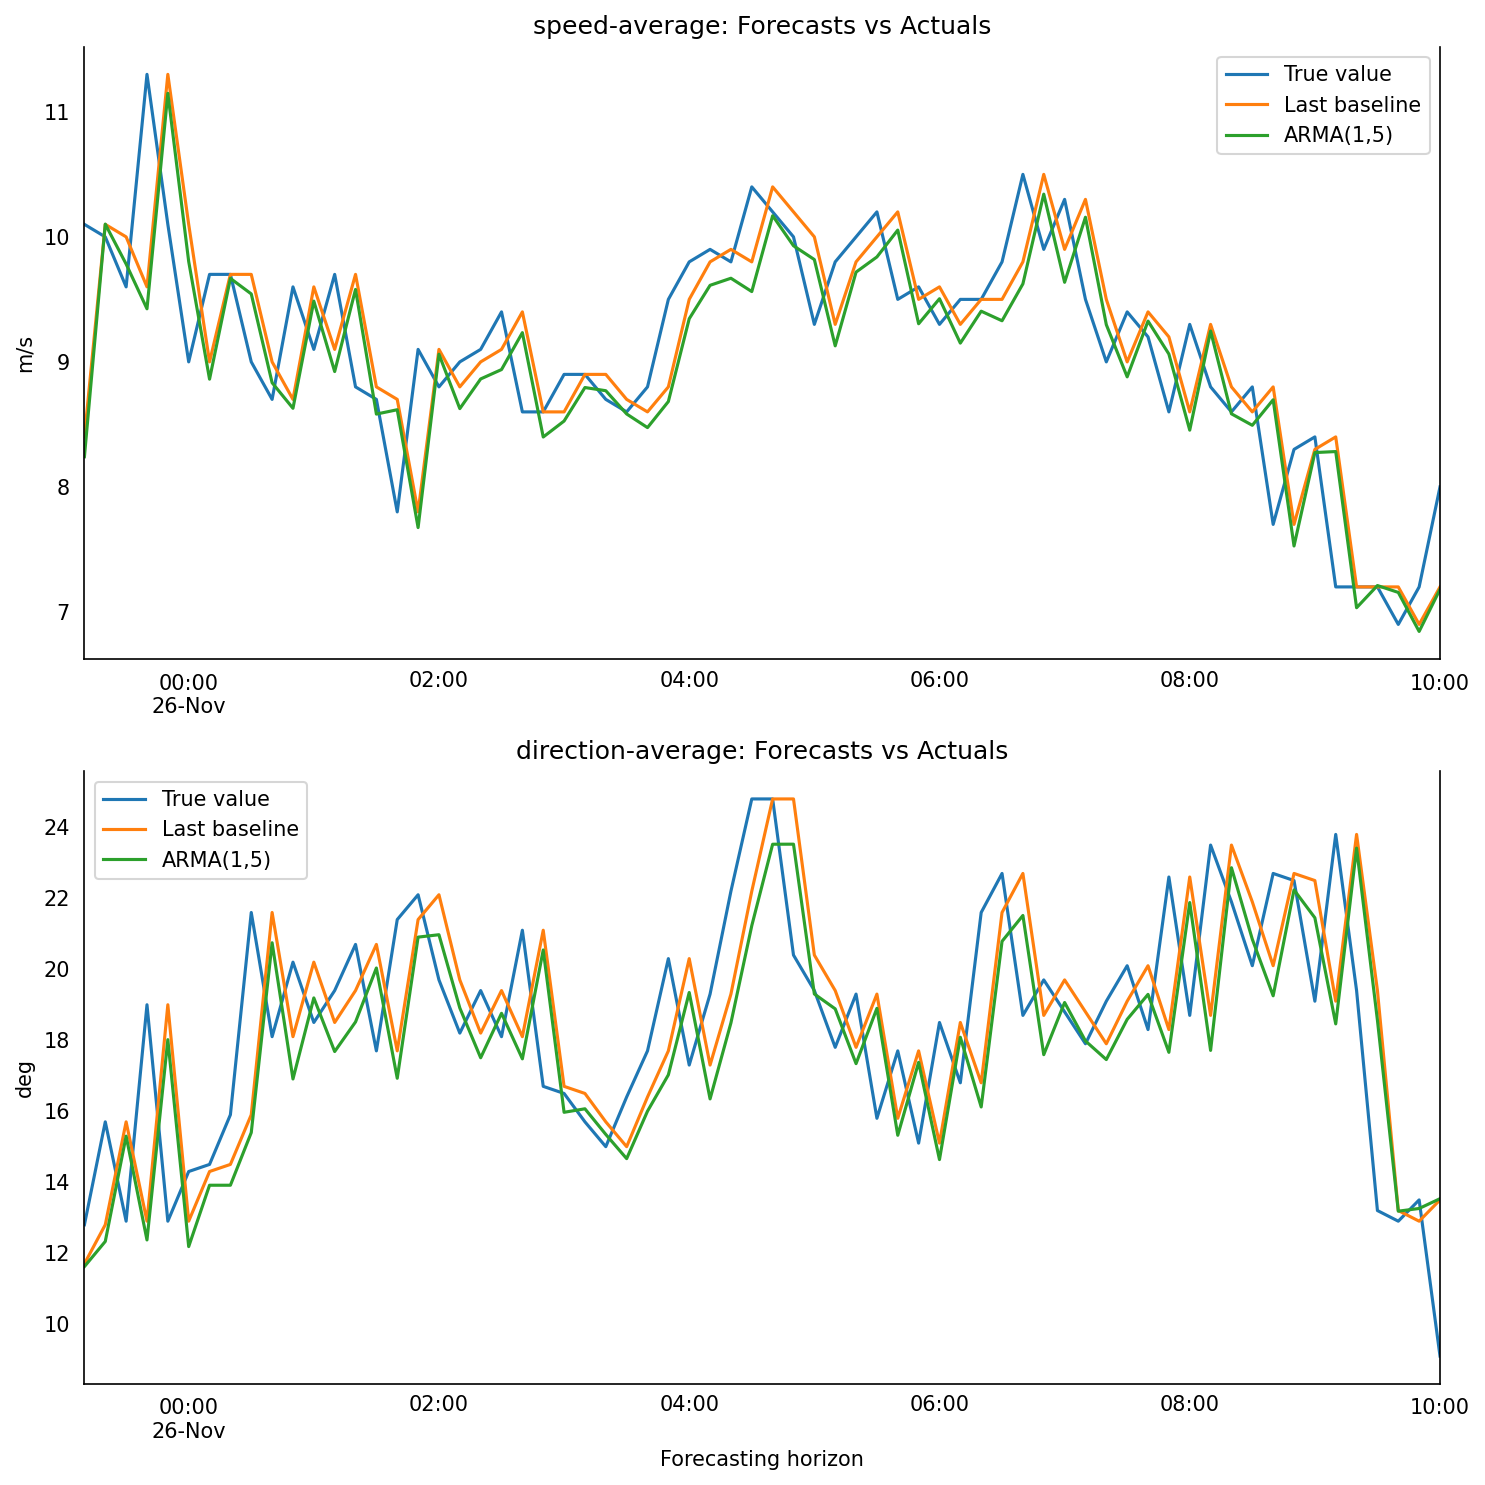

In [135]:
all_predictions = [predictions_last] + [predictions_arma_short[1]]
dict_predictions = {index:pred for index,pred in zip([df_error_last.index[0],"ARMA(1,5)"],
                                                     all_predictions)}
plot_predictions(dict_predictions,final_df,0.8,0)

# Limitation of ARMA and VAR

In [142]:
def l2_error_against_forecasting_time(forecasting_time,final_df):
    l2_error = []
    speed_error = []
    direction_error = []
    for city_code in final_df['city_code'].unique():
        data = final_df[final_df['city_code'] == city_code]
        data.index = data['date']
        data = data.drop(columns=['date'])
        train = data[["cosine-speed","sinus-speed"]][:-forecasting_time]
        valid = data[["cosine-speed","sinus-speed"]][-forecasting_time:]
        model = VAR(train)
        model_fit = model.fit(6)
        prediction = model_fit.forecast(model_fit.endog, steps=len(valid))
        l2_error.append(np.sqrt(np.sum((prediction - valid.values)**2, axis=1)))
        speed_error.append(np.abs(np.sqrt(np.sum(prediction**2,axis=1))-np.sqrt(np.sum(valid.values**2,axis=1))))
        direction_error.append(direction_error_metric(valid.values,prediction))
    print("One VAR per location approach:")
    print("MAE speed : " + str(np.mean(np.mean(speed_error,axis=0))))
    print("MAE direction : " + str(np.mean(np.mean(direction_error,axis=0))))
    print("MAE vector (l2-distance) : " + str(np.mean(np.mean(l2_error,axis=0))))
    print("\n")
    return np.mean(l2_error,axis=0), np.mean(speed_error,axis=0), np.mean(direction_error,axis=0), prediction

def l2_error_against_forecasting_time_grouped(forecasting_time,data,list_city_codes,order):
    l2_error = []
    speed_error = []
    direction_error = []
    train = data[:-forecasting_time]
    valid = data[-forecasting_time:]
    model = VAR(train)
    model_fit = model.fit(order)
    prediction = model_fit.forecast(model_fit.endog, steps=len(valid))
    pred = pd.DataFrame(prediction,columns=data.columns)
    l2_error = [np.sqrt(np.sum(np.array([pred["cosine-speed"+"_"+str(city_code)].values  - valid["cosine-speed"+"_"+str(city_code)].values ,
                                                   pred["sinus-speed"+"_"+str(city_code)].values  - valid["sinus-speed"+"_"+str(city_code)].values])**2,axis=0)) 
                            for city_code in list_city_codes]
    speed_error = [np.abs(np.subtract(np.sqrt(pred["cosine-speed"+"_"+str(city_code)].values**2  + pred["sinus-speed"+"_"+str(city_code)].values**2) ,
                            np.sqrt(valid["cosine-speed"+"_"+str(city_code)].values**2  + valid["sinus-speed"+"_"+str(city_code)].values**2))) 
                            for city_code in list_city_codes]
    direction_error = [direction_error_metric(valid[["cosine-speed"+"_"+str(city_code),"sinus-speed"+"_"+str(city_code)]].values,
                                              pred[["cosine-speed"+"_"+str(city_code),"sinus-speed"+"_"+str(city_code)]].values) for city_code in list_city_codes]
    
    print("Single VAR for all location approach:")
    print("MAE speed : " + str(np.mean(np.mean(speed_error,axis=0))))
    print("MAE direction : " + str(np.mean(np.mean(direction_error,axis=0))))
    print("MAE vector (l2-distance) : " + str(np.mean(np.mean(l2_error,axis=0))))
    print("\n")
    return np.mean(l2_error,axis=0), np.mean(speed_error,axis=0), np.mean(direction_error,axis=0), prediction

def compare_two_approaches(l2_error_1,speed_error_1,direction_error_1,title_1,l2_error_2,speed_error_2,direction_error_2,title_2):

    plt.rcParams["figure.figsize"] = (10,6)
    fig, axs = plt.subplots(1,2, sharey=True)
    axs[0].set_title(title_1)
    axs[0].plot(final_df['date'].unique()[-forecasting_time:],l2_error_1)
    axs[0].plot(final_df['date'].unique()[-forecasting_time:],speed_error_1)
    axs[0].plot(final_df['date'].unique()[-forecasting_time:],direction_error_1)
    axs[0].tick_params(labelsize=10)
    xformatter = mdates.DateFormatter('%H:%M')
    axs[0].xaxis.set_major_formatter(xformatter)
    axs[0].set_xlabel("Forecasting horizon")
    
    axs[1].set_title(title_2)
    axs[1].plot(final_df['date'].unique()[-forecasting_time:],l2_error_2)
    axs[1].plot(final_df['date'].unique()[-forecasting_time:],speed_error_2)
    axs[1].plot(final_df['date'].unique()[-forecasting_time:],direction_error_2)
    axs[1].tick_params(labelsize=10)
    axs[1].xaxis.set_major_formatter(xformatter)
    axs[1].set_xlabel("Forecasting horizon")
    
    
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.15)
    fig.legend(labels=["MDE","MAE speed","MAE direction"], loc="lower center", ncol=3)
    plt.savefig('limitation_var_2.pdf')
    
def plot_predictions_long_term_var(forecasting_time,prediction_1,prediction_2):
  
    figure = plt.figure()
    axe = figure.add_subplot(1, 1, 1)
    xformatter = mdates.DateFormatter('%H:%M')
    axe.xaxis.set_major_formatter(xformatter)
    valid = final_df[final_df["city_code"] == final_df["city_code"].unique()[-1]][-forecasting_time:]
    axe.plot(valid["date"],valid["sinus-speed"])
    axe.plot(valid["date"],prediction_1[:,-1])
    axe.plot(valid["date"],prediction_2[:,-1])
    axe.legend(labels=["True values","Location-wise forecast","Single entity forecast"])
    axe.set_xlabel("Forecasting horizon")
    axe.set_ylabel("Sinus speed (m/s)")
    plt.savefig('limitation_var.pdf')
    plt.show()

In [59]:
order = 6
forecasting_time = 144
l2_error_multiple_var, speed_error_multiple_var, direction_error_multiple_var, prediction_multiple_var = l2_error_against_forecasting_time(forecasting_time,final_df)
l2_error_single_var, speed_error_single_var, direction_error_single_var, prediction_single_var = l2_error_against_forecasting_time_grouped(forecasting_time,
                                                           final_df_grouped,final_df['city_code'].unique(),order)

One VAR per location approach:
MAE speed : 3.706481936586281
MAE direction : 0.4661667885815619
MAE vector (l2-distance) : 4.530057338770888


Single VAR for all location approach:
MAE speed : 2.95993440272507
MAE direction : 0.502101568109905
MAE vector (l2-distance) : 4.628147496081389




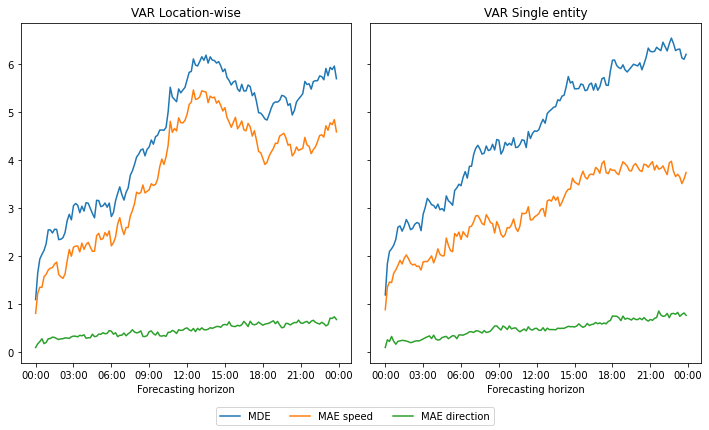

In [141]:
compare_two_approaches(l2_error_multiple_var, speed_error_multiple_var, direction_error_multiple_var, "VAR Location-wise",
                       l2_error_single_var, speed_error_single_var, direction_error_single_var, "VAR Single entity")

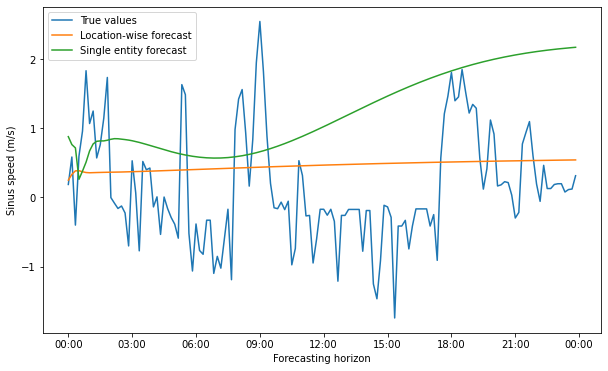

In [143]:
plot_predictions_long_term_var(forecasting_time,prediction_multiple_var,prediction_single_var) 

# Coordinates for Google Maps

In [1016]:
[(latitude,longitude) for latitude, longitude in zip(df['latitude'].unique(),df['longitude'].unique())]

[(37.6375, 26.2780555555556),
 (36.5288888888889, 23.095),
 (36.8216666666667, 25.8972222222222),
 (38.6669444444444, 24.08),
 (39.2005555555556, 23.2472222222222),
 (40.7005555555556, 24.6127777777778),
 (36.7147222222222, 22.8977777777778),
 (39.4355555555556, 22.3269444444444),
 (38.3208333333333, 24.2208333333333),
 (37.9272222222222, 21.1669444444444),
 (37.3819444444444, 21.7777777777778),
 (39.9433333333333, 25.1133333333333),
 (37.4680555555556, 25.4152777777778),
 (37.3738888888889, 24.4280555555556),
 (40.4730555555556, 25.4566666666667),
 (35.9436111111111, 27.7513888888889),
 (39.9836111111111, 23.5119444444444),
 (37.6366666666667, 24.38),
 (38.3361111111111, 24.0830555555556),
 (40.0791666666667, 21.9944444444444),
 (38.3930555555556, 23.5361111111111),
 (36.5625, 27.3263888888889),
 (39.7027777777778, 22.1875),
 (38.8363888888889, 23.4630555555556),
 (36.7683333333333, 23.0902777777778),
 (37.3613888888889, 22.6980555555556),
 (40.2877777777778, 24.225),
 (39.43361111111

In [8]:
[(latitude,longitude) for latitude, longitude in zip(final_df['latitude'].unique(),final_df['longitude'].unique())]

[(40.0113888888889, 23.9441666666667),
 (37.5827777777778, 22.0058333333333),
 (40.9, 25.745),
 (39.6263888888889, 20.5013888888889),
 (39.4336111111111, 22.8569444444444),
 (38.3930555555556, 23.5361111111111),
 (38.3944444444444, 22.2347222222222),
 (35.4461111111111, 27.1322222222222),
 (37.6366666666667, 24.38),
 (36.7394444444444, 25.3136111111111),
 (37.4827777777778, 23.2152777777778),
 (36.4380555555556, 25.3491666666667),
 (35.9436111111111, 27.7513888888889),
 (37.1705555555556, 22.4405555555556),
 (40.1208333333333, 22.5347222222222),
 (39.9433333333333, 25.1133333333333),
 (40.4938888888889, 21.2516666666667),
 (38.3416666666667, 24.0888888888889),
 (38.3361111111111, 24.0830555555556),
 (40.3758333333333, 21.7894444444444),
 (37.9272222222222, 21.1669444444444),
 (38.9633333333333, 23.2891666666667),
 (38.6669444444444, 24.08),
 (41.5127777777778, 26.315),
 (40.7141666666667, 22.1091666666667),
 (37.6322222222222, 22.5077777777778),
 (38.7027777777778, 22.6555555555556),
 

In [1014]:
df['city_name'].unique()

array(['IKARIA', 'Pharmacole', 'AMORGA', 'Cylinder', 'Lady', 'THASSOS',
       'PINALIKI', 'St. Friday', 'ZARAKES', 'KYLLINE', 'Aborton',
       'LIMNOS', 'MYKONOS', 'KYTHNOS', 'SAMOTHRAKI', 'RHODES',
       'KASSANDRA', 'KEA', 'Green', 'Migra', 'Ritsona', 'ASTYPALLAIA',
       'Damn', 'Mandulus', 'MONEMFACE', 'Star', 'Ag. Term', 'Glamor',
       'Ι.Μ. Antiquits', 'CRETE', 'LEGREEN', 'MILL', 'LEFKADA',
       'Hymettus', 'Florina', 'CROWN', 'Woodcutters', 'LESVOS', 'Veloc',
       'Hanging', 'ROUNGIA', 'Vapor', 'Boucher', 'SKOPELOS', 'Origo',
       'A. Mustard', 'TWIN', 'Ship', 'Kastoria', 'NENTRAN', 'Balogen',
       'Geranium', 'SYROS', 'Cheese', 'Whistle', 'Blonde', 'Mr. Pedina',
       'Marble', 'Senate', 'TINOS', 'CHIOS', 'Pella', 'Grevena', 'VIRUS',
       'Sidirokastro', 'Curse', 'Nymphae', 'Plate', 'Orauros',
       'KAROUSTOS', 'PETALIDI', 'Male', 'St. Theodoroi', 'KILKIS',
       'SELLASIA', 'SANTORINI', 'NAXOS', 'KARPATHOS', 'Kozani', 'SAMOS',
       'Sloporic', 'Distomo', 